In [1]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from scipy import stats  # Add this import for the t-distribution

In [2]:
filepath = '/Users/danielseymour/Developer/EC334-Summative/raw_data/productivity_data/total_factor_productivity.csv'

tfp_disp_df = pd.read_csv(filepath, encoding='latin1')

In [3]:
tfp_disp_df.head()

naics4    year      sd   d7525   d9010   d9990   d1001     sd*  d7525*  \
0   3111  1987.0  0.2883  0.2239  0.6477  0.6196  0.1455  0.2789  0.1947   
1   3111  1988.0  0.2782  0.1996  0.5330  0.8425  0.1384  0.3102  0.1529   
2   3111  1989.0  0.3253  0.1840  0.7220  0.7709  0.1533  0.3094  0.1547   
3   3111  1990.0  0.2954  0.2001  0.5154   1.037  0.1929  0.2927  0.1822   
4   3111  1991.0  0.2842  0.2235  0.5372  0.6796  0.2426  0.2842  0.1806   

   d9010*  d9990*  d1001*  
0  0.4894  0.8043  0.1535  
1  0.5752  0.8945  0.1245  
2  0.5261  0.8397  0.1173  
3  0.4714  0.7978  0.1004  
4  0.4711  0.7504  0.2352

In [4]:

filepath = '/Users/danielseymour/Developer/EC334-Summative/processed_data/tfp_four_digit_pivoted.csv'

manufacturing_tfp = pd.read_csv(filepath)


In [5]:
filepath = '/Users/danielseymour/Developer/EC334-Summative/raw_data/dynamism_data/bds2022_vcn4.csv'

bds2022_vcn4 = pd.read_csv(filepath, encoding='latin1')

In [6]:
bds2022_vcn4.head() 

year  vcnaics4  firms  estabs    emp  denom estabs_entry estabs_entry_rate  \
0  1978      1131    193     200   3067   2948           42            21.483   
1  1978      1132     84     100   1745   1762           12            11.707   
2  1978      1133  12079   12196  98382  93837         2382            19.806   
3  1978      1141   1504    1540  10486   9559          383            25.008   
4  1978      1142    147     147    694    650           34            23.368   

  estabs_exit estabs_exit_rate  ...  job_destruction_deaths  \
0          33           16.880  ...                     474   
1          17           16.585  ...                      42   
2        2043           16.987  ...                    7320   
3         366           23.898  ...                    1253   
4          31           21.306  ...                      71   

  job_destruction_continuers job_destruction_rate_deaths job_destruction_rate  \
0                        311                      16.081               26.633   
1                        546                       2.384               33.381   
2                      10648                       7.801               19.148   
3                       1344                      13.108               27.168   
4                        142                      10.931               32.794   

   net_job_creation  net_job_creation_rate reallocation_rate firmdeath_firms  \
0               255                  8.651            53.265              22   
1               -51                 -2.895            60.971              10   
2              9138                  9.738            38.296            1521   
3              1837                 19.217            54.336             272   
4                91                 14.011            65.589              25   

  firmdeath_estabs  firmdeath_emp  
0               22             37  
1               10             25  
2             1524           5347  
3              272            799  
4               25             64  

[5 rows x 26 columns]

In [7]:
# Ensure both keys are strings for merging
tfp_disp_df['naics4'] = tfp_disp_df['naics4'].astype(str)
bds2022_vcn4['vcnaics4'] = bds2022_vcn4['vcnaics4'].astype(str)

temp_df = pd.merge(
	tfp_disp_df, 
	bds2022_vcn4, 
	how='inner', 
	left_on=['naics4', 'year'], 
	right_on=['vcnaics4', 'year']
)

In [8]:
temp_df.columns

Index(['naics4', 'year', 'sd', 'd7525', 'd9010', 'd9990', 'd1001', 'sd*',
       'd7525*', 'd9010*', 'd9990*', 'd1001*', 'vcnaics4', 'firms', 'estabs',
       'emp', 'denom', 'estabs_entry', 'estabs_entry_rate', 'estabs_exit',
       'estabs_exit_rate', 'job_creation', 'job_creation_births',
       'job_creation_continuers', 'job_creation_rate_births',
       'job_creation_rate', 'job_destruction', 'job_destruction_deaths',
       'job_destruction_continuers', 'job_destruction_rate_deaths',
       'job_destruction_rate', 'net_job_creation', 'net_job_creation_rate',
       'reallocation_rate', 'firmdeath_firms', 'firmdeath_estabs',
       'firmdeath_emp'],
      dtype='object')

In [9]:
manufacturing_tfp.columns

Index(['NAICS', 'IndustryTitle', 'Basis', 'year', 'tfp_pct_change',
       'tfp_index_2017'],
      dtype='object')

In [10]:
temp_df.shape

(2924, 37)

In [13]:
# convert to numeric (will error or NaN if something’s not a number)
temp_df['naics4'] = pd.to_numeric(temp_df['naics4'], errors='raise').astype('int64')
manufacturing_tfp['NAICS'] = pd.to_numeric(manufacturing_tfp['NAICS'], errors='raise').astype('int64')

# if your 'year' columns aren’t already integers, do the same:
temp_df['year'] = temp_df['year'].astype(int)
# manufacturing_tfp['year'] may be float or string like '1988.0', so convert carefully:
manufacturing_tfp['year'] = pd.to_numeric(manufacturing_tfp['year'], errors='coerce').astype('Int64')
manufacturing_tfp = manufacturing_tfp.dropna(subset=['year'])
manufacturing_tfp['year'] = manufacturing_tfp['year'].astype(int)

# now merge
merged_df = pd.merge(
    temp_df,
    manufacturing_tfp,
    how='inner',
    left_on = ['naics4', 'year'],
    right_on= ['NAICS',  'year']
)

In [14]:
merged_df.head()

naics4  year      sd   d7525   d9010   d9990   d1001     sd*  d7525*  \
0    3111  1987  0.2883  0.2239  0.6477  0.6196  0.1455  0.2789  0.1947   
1    3111  1988  0.2782  0.1996  0.5330  0.8425  0.1384  0.3102  0.1529   
2    3111  1989  0.3253  0.1840  0.7220  0.7709  0.1533  0.3094  0.1547   
3    3111  1990  0.2954  0.2001  0.5154   1.037  0.1929  0.2927  0.1822   
4    3111  1991  0.2842  0.2235  0.5372  0.6796  0.2426  0.2842  0.1806   

   d9010*  ... net_job_creation_rate reallocation_rate firmdeath_firms  \
0  0.4894  ...                -0.703            23.690              72   
1  0.5752  ...                -1.347            26.411              76   
2  0.5261  ...                -2.389            20.768              70   
3  0.4714  ...                 2.093            20.153              76   
4  0.4711  ...                -0.703            21.388              61   

   firmdeath_estabs  firmdeath_emp  NAICS              IndustryTitle  \
0                75            619   3111  Animal food manufacturing   
1                77           1085   3111  Animal food manufacturing   
2                70            704   3111  Animal food manufacturing   
3                77            690   3111  Animal food manufacturing   
4                63            745   3111  Animal food manufacturing   

         Basis tfp_pct_change tfp_index_2017  
0  All workers           N.A.          102.8  
1  All workers           -1.6        101.189  
2  All workers            1.4        102.619  
3  All workers            3.0        105.689  
4  All workers           -3.7        101.807  

[5 rows x 42 columns]

In [16]:
merged_df.columns

Index(['naics4', 'year', 'sd', 'd7525', 'd9010', 'd9990', 'd1001', 'sd*',
       'd7525*', 'd9010*', 'd9990*', 'd1001*', 'vcnaics4', 'firms', 'estabs',
       'emp', 'denom', 'estabs_entry', 'estabs_entry_rate', 'estabs_exit',
       'estabs_exit_rate', 'job_creation', 'job_creation_births',
       'job_creation_continuers', 'job_creation_rate_births',
       'job_creation_rate', 'job_destruction', 'job_destruction_deaths',
       'job_destruction_continuers', 'job_destruction_rate_deaths',
       'job_destruction_rate', 'net_job_creation', 'net_job_creation_rate',
       'reallocation_rate', 'firmdeath_firms', 'firmdeath_estabs',
       'firmdeath_emp', 'NAICS', 'IndustryTitle', 'Basis', 'tfp_pct_change',
       'tfp_index_2017'],
      dtype='object')

In [19]:
merged_df['tfp_pct_change'] = pd.to_numeric(
    merged_df['tfp_pct_change'],
    errors='coerce'
)
merged_df['tfp_index_2017'] = pd.to_numeric(
    merged_df['tfp_index_2017'],
    errors='coerce')

In [21]:
# List of columns that should be numeric based on the aggregation dictionary
columns_to_convert = [
    # Dispersion measures
    'd9990', 'd1001', 'd9990*', 'd1001*',
    
    # Entry/exit counts
    'estabs_entry', 'estabs_exit',
    'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
    
    # Entry/exit rates  
    'estabs_entry_rate', 'estabs_exit_rate',
    
    # Job flow counts
    'job_creation_births', 'job_creation_continuers',
    'job_destruction_deaths', 'job_destruction_continuers',
    
    # Job flow rates
    'job_creation_rate_births', 'job_destruction_rate_deaths'
]

# Convert each column to numeric
print("Converting object columns to numeric...")
for col in columns_to_convert:
    if col in merged_df.columns and merged_df[col].dtype == 'object':
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
        nan_count = merged_df[col].isna().sum()
        if nan_count > 0:
            print(f"  {col}: converted ({nan_count} NaN values created)")
        else:
            print(f"  {col}: converted successfully")

Converting object columns to numeric...
  d9990: converted (17 NaN values created)
  d1001: converted (16 NaN values created)
  d9990*: converted (8 NaN values created)
  d1001*: converted (8 NaN values created)
  estabs_entry: converted successfully
  estabs_exit: converted successfully
  firmdeath_firms: converted (4 NaN values created)
  firmdeath_estabs: converted (4 NaN values created)
  firmdeath_emp: converted (4 NaN values created)
  estabs_entry_rate: converted successfully
  estabs_exit_rate: converted successfully
  job_creation_births: converted successfully
  job_creation_continuers: converted successfully
  job_destruction_deaths: converted successfully
  job_destruction_continuers: converted successfully
  job_creation_rate_births: converted successfully
  job_destruction_rate_deaths: converted successfully


In [22]:
merged_df.describe()

naics4         year           sd        d7525        d9010  \
count  2924.000000  2924.000000  2924.000000  2924.000000  2924.000000   
mean   3266.453488  2003.500000     0.438629     0.500009     1.049623   
std      89.749796     9.812386     0.149306     0.213762     0.389669   
min    3111.000000  1987.000000     0.158000     0.085440     0.348700   
25%    3169.000000  1995.000000     0.342675     0.372500     0.810275   
50%    3295.000000  2003.500000     0.409700     0.451950     0.968750   
75%    3341.000000  2012.000000     0.496425     0.566825     1.178000   
max    3399.000000  2020.000000     1.726000     2.125000     4.182000   

             d9990        d1001          sd*       d7525*       d9010*  ...  \
count  2907.000000  2908.000000  2924.000000  2924.000000  2924.000000  ...   
mean      0.766493     0.310975     0.361527     0.468077     0.874176  ...   
std       0.451225     0.189244     0.135884     0.274022     0.358649  ...   
min       0.002956     0.002989     0.118400     0.063080     0.223600  ...   
25%       0.461050     0.215100     0.285450     0.330700     0.671175  ...   
50%       0.662900     0.290700     0.339850     0.415750     0.812300  ...   
75%       0.952200     0.375500     0.406150     0.534175     1.003000  ...   
max       4.010000     4.321000     1.574000     3.243000     3.756000  ...   

       job_destruction_rate  net_job_creation  net_job_creation_rate  \
count           2924.000000       2924.000000            2924.000000   
mean              11.059133      -1776.145007              -1.445345   
std                4.577867      10892.721269               5.360380   
min                1.869000    -152430.000000             -33.949000   
25%                7.995750      -3609.500000              -3.676000   
50%               10.089500       -436.500000              -0.606000   
75%               12.967250       1863.000000               1.776750   
max               41.635000      40502.000000              20.283000   

       reallocation_rate  firmdeath_firms  firmdeath_estabs  firmdeath_emp  \
count        2924.000000      2920.000000       2920.000000    2920.000000   
mean           16.838861       222.292123        224.005137    2432.108904   
std             5.126989       383.068255        385.090653    3920.690916   
min             3.738000         3.000000          3.000000       5.000000   
25%            13.478250        47.000000         48.000000     552.000000   
50%            16.347500        93.000000         94.500000    1213.000000   
75%            19.738250       207.000000        208.000000    2721.250000   
max            40.673000      3468.000000       3476.000000   43304.000000   

             NAICS  tfp_pct_change  tfp_index_2017  
count  2924.000000     2838.000000     2924.000000  
mean   3266.453488        0.595137       95.339770  
std      89.749796        4.991368       14.763867  
min    3111.000000      -31.900000        3.493000  
25%    3169.000000       -2.000000       89.187250  
50%    3295.000000        0.500000       97.224500  
75%    3341.000000        2.800000      102.803250  
max    3399.000000       41.600000      155.354000  

[8 rows x 39 columns]

In [16]:
# # Create a clean copy to work with
# df = merged_df.copy()

# ##############################################################################
# # 1. CREATE TWO-YEAR WINDOWS
# ##############################################################################
# BASE_YEAR = df['year'].min()
# df = df.sort_values(['naics4', 'year'])

# # # Create window identifiers
# # df['window_id'] = ((df['year'] - BASE_YEAR) // 2).astype(int)
# # df['window_end_year'] = BASE_YEAR + df['window_id'] * 2 + 1

# # print(f"Years span from {df['year'].min()} to {df['year'].max()}")
# # print(f"This creates {df['window_id'].max() + 1} two-year windows")

Years span from 1987.0 to 2020.0
This creates 17 two-year windows


In [23]:
agg_dict = {
   # DISPERSION MEASURES - AVERAGE within 2-year window
   'sd': 'mean',                    # Standard deviation - average
   'd7525': 'mean',                 # IQR (75-25 percentile) - average
   'd9010': 'mean',                 # 90-10 percentile - average 
   'd9990': 'mean',                 # 99-90 percentile - average
   'd1001': 'mean',                 # 10-01 percentile - average
   'sd*': 'mean',                   # Weighted SD - average
   'd7525*': 'mean',                # Weighted IQR - average
   'd9010*': 'mean',                # Weighted 90-10 - average
   'd9990*': 'mean',                # Weighted 99-90 - average
   'd1001*': 'mean',                # Weighted 10-01 - average
  
   # STOCK VARIABLES - LAST value (end of period snapshot)
   'firms': 'last',                 # Number of firms - end of period
   'estabs': 'last',                # Number of establishments - end of period
   'emp': 'last',                   # Employment - end of period
   'denom': 'last',                 # Denominator for rates - end of period
  
   # ENTRY/EXIT COUNTS - SUM across 2 years
   'estabs_entry': 'sum',           # Count of entering establishments - total over 2 years
   'estabs_exit': 'sum',            # Count of exiting establishments - total over 2 years
   'firmdeath_firms': 'sum',        # Count of dying firms - total over 2 years
   'firmdeath_estabs': 'sum',       # Establishments from dying firms - total over 2 years
   'firmdeath_emp': 'sum',          # Employment from dying firms - total over 2 years
  
   # ENTRY/EXIT RATES - AVERAGE across 2 years
   'estabs_entry_rate': 'mean',    # Establishment entry rate - average annual rate
   'estabs_exit_rate': 'mean',     # Establishment exit rate - average annual rate
  
   # JOB FLOW COUNTS - SUM across 2 years
   'job_creation': 'sum',           # Total jobs created - sum over 2 years
   'job_creation_births': 'sum',    # Jobs from new establishments - sum over 2 years
   'job_creation_continuers': 'sum', # Jobs from continuing establishments - sum
   'job_destruction': 'sum',        # Total jobs destroyed - sum over 2 years
   'job_destruction_deaths': 'sum', # Jobs lost from deaths - sum over 2 years
   'job_destruction_continuers': 'sum', # Jobs lost from continuers - sum
   'net_job_creation': 'sum',      # Net job change - sum over 2 years
  
   # JOB FLOW RATES - AVERAGE across 2 years
   'job_creation_rate': 'mean',    # Job creation rate - average annual rate
   'job_creation_rate_births': 'mean', # Job creation rate from births - average
   'job_destruction_rate': 'mean', # Job destruction rate - average annual rate
   'job_destruction_rate_deaths': 'mean', # Destruction rate from deaths - average
   'net_job_creation_rate': 'mean', # Net job creation rate - average annual rate
   'reallocation_rate': 'mean',    # Job reallocation rate - average annual rate
}



In [24]:

# # The 'vcnaics4' column is likely non-numeric, so we exclude it
# # If you need it, you could add: 'vcnaics4': 'first' or 'last'


# print("AGGREGATION RULES BY CATEGORY:")
# print("="*60)


# print("\n1. DISPERSION MEASURES (AVERAGE):")
# print("   These are averaged because we want the typical dispersion level during the 2-year period")
# for col in ['sd', 'd7525', 'd9010', 'd9990', 'd1001', 'sd*', 'd7525*', 'd9010*', 'd9990*', 'd1001*']:
#    if col in agg_dict:
#        print(f"   {col:12} -> {agg_dict[col]}")


# print("\n2. STOCK VARIABLES (LAST VALUE):")
# print("   These are end-of-period snapshots")
# for col in ['firms', 'estabs', 'emp', 'denom']:
#    if col in agg_dict:
#        print(f"   {col:12} -> {agg_dict[col]}")


# print("\n3. FLOW COUNTS (SUM):")
# print("   These are cumulative flows over the 2-year period")
# flow_counts = ['estabs_entry', 'estabs_exit', 'job_creation', 'job_creation_births',
#               'job_creation_continuers', 'job_destruction', 'job_destruction_deaths',
#               'job_destruction_continuers', 'net_job_creation', 'firmdeath_firms',
#               'firmdeath_estabs', 'firmdeath_emp']
# for col in flow_counts:
#    if col in agg_dict:
#        print(f"   {col:30} -> {agg_dict[col]}")


# print("\n4. RATES (AVERAGE):")
# print("   These are averaged to get typical annual rates during the period")
# rate_vars = ['estabs_entry_rate', 'estabs_exit_rate', 'job_creation_rate',
#             'job_creation_rate_births', 'job_destruction_rate',
#             'job_destruction_rate_deaths', 'net_job_creation_rate', 'reallocation_rate']
# for col in rate_vars:
#    if col in agg_dict:
#        print(f"   {col:30} -> {agg_dict[col]}")


# print(f"\nTotal columns with aggregation rules: {len(agg_dict)}")

# two_yr = df.groupby(['naics4', 'window_id', 'window_end_year'], as_index=False).agg(agg_dict)

In [25]:
import numpy as np
import pandas as pd

# 1) Define the mapping from period ID → window_end_year and labels
period_map = {
     1: 1983,  2: 1985,  3: 1987,  4: 1989,
     5: 1991,  6: 1993,  7: 1995,  8: 1997,
     9: 1999, 10: 2001, 11: 2003, 12: 2005,
    13: 2007, 14: 2009, 15: 2011, 16: 2013,
    17: 2015, 18: 2017
}

period_labels = {
     i: f"{end-2}-{end}" for i, end in period_map.items()
}

# 2) For each year, find which window it falls into:
#    i.e. year ∈ [window_end_year-2, window_end_year]
def assign_window_id(year):
    for pid, end in period_map.items():
        if end - 2 <= year <= end:
            return pid
    return np.nan

merged_df['window_id'] = merged_df['year'].apply(assign_window_id)
merged_df = merged_df.dropna(subset=['window_id']).copy()
merged_df['window_id'] = merged_df['window_id'].astype(int)
merged_df['window_end_year'] = merged_df['window_id'].map(period_map)

# 3) Now group by naics4, window_id, window_end_year
two_yr = merged_df.groupby(
    ['naics4','window_id','window_end_year'], 
    as_index=False
).agg(agg_dict)

# 4) Attach the human‐readable “period” label, as an ordered categorical
two_yr['period'] = two_yr['window_id'].map(period_labels)
two_yr['period'] = pd.Categorical(
    two_yr['period'],
    categories=[period_labels[i] for i in sorted(period_labels)],
    ordered=True
)

# 5) Inspect
print(two_yr[['window_id','window_end_year','period']].drop_duplicates())

    window_id  window_end_year     period
0           3             1987  1985-1987
1           4             1989  1987-1989
2           5             1991  1989-1991
3           6             1993  1991-1993
4           7             1995  1993-1995
5           8             1997  1995-1997
6           9             1999  1997-1999
7          10             2001  1999-2001
8          11             2003  2001-2003
9          12             2005  2003-2005
10         13             2007  2005-2007
11         14             2009  2007-2009
12         15             2011  2009-2011
13         16             2013  2011-2013
14         17             2015  2013-2015
15         18             2017  2015-2017


In [26]:
two_yr.head(10)

naics4  window_id  window_end_year       sd    d7525    d9010   d9990  \
0    3111          3             1987  0.28830  0.22390  0.64770  0.6196   
1    3111          4             1989  0.30175  0.19180  0.62750  0.8067   
2    3111          5             1991  0.28980  0.21180  0.52630  0.8583   
3    3111          6             1993  0.36960  0.22710  0.63660  1.2993   
4    3111          7             1995  0.54690  0.25555  1.02740  1.4375   
5    3111          8             1997  0.46120  0.27285  0.88560  1.3380   
6    3111          9             1999  0.45205  0.24010  0.62340  2.0970   
7    3111         10             2001  0.45995  0.23565  0.61435  1.8070   
8    3111         11             2003  0.60755  0.34940  0.96460  2.5335   
9    3111         12             2005  0.94890  0.44005  1.68250  3.0630   

     d1001      sd*   d7525*  ...  job_destruction_deaths  \
0  0.14550  0.27890  0.19470  ...                    1802   
1  0.14585  0.30980  0.15380  ...                    5240   
2  0.21775  0.28845  0.18140  ...                    3701   
3  0.36765  0.31840  0.20010  ...                    2145   
4  0.26705  0.36560  0.21865  ...                    2566   
5  0.40045  0.35815  0.20480  ...                    2878   
6  0.23810  0.27375  0.20950  ...                    2936   
7  0.78385  0.30160  0.21690  ...                    3364   
8  0.30065  0.35605  0.25990  ...                    4037   
9  0.11805  0.38145  0.28075  ...                    3182   

   job_destruction_continuers  net_job_creation  job_creation_rate  \
0                        4282              -341            11.8450   
1                        7962             -1804            11.7945   
2                        6800               665            11.4315   
3                        7605              -867             9.1665   
4                        5921                 4             8.7890   
5                        7269             -1021             9.8390   
6                        6572              2399            12.4900   
7                        7836              -282            11.1520   
8                       10212             -3627            11.2370   
9                        6518              1583            12.1010   

   job_creation_rate_births  job_destruction_rate  \
0                    3.9040               12.5480   
1                    3.9845               13.6630   
2                    2.9705               10.7370   
3                    2.0770               10.0615   
4                    2.2505                8.7955   
5                    3.3685               10.9410   
6                    4.1560                9.9620   
7                    3.4020               11.4370   
8                    3.4920               15.0570   
9                    4.1190               10.4010   

   job_destruction_rate_deaths  net_job_creation_rate  reallocation_rate  \
0                       3.7170                -0.7030            23.6900   
1                       5.4215                -1.8680            23.5895   
2                       3.7805                 0.6950            20.7705   
3                       2.2135                -0.8950            18.3335   
4                       2.6585                -0.0060            15.5340   
5                       3.1040                -1.1015            19.6790   
6                       3.0670                 2.5290            19.9230   
7                       3.4350                -0.2855            20.1950   
8                       4.2620                -3.8200            22.4750   
9                       3.4135                 1.7000            20.8020   

      period  
0  1985-1987  
1  1987-1989  
2  1989-1991  
3  1991-1993  
4  1993-1995  
5  1995-1997  
6  1997-1999  
7  1999-2001  
8  2001-2003  
9  2003-2005  

[10 rows x 38 columns]

In [27]:
two_yr.describe()

naics4    window_id  window_end_year           sd        d7525  \
count  1376.000000  1376.000000      1376.000000  1376.000000  1376.000000   
mean   3266.453488    10.500000      2002.000000     0.430586     0.496151   
std      89.767072     4.611448         9.222896     0.136077     0.200414   
min    3111.000000     3.000000      1987.000000     0.199750     0.117500   
25%    3169.000000     6.750000      1994.500000     0.340350     0.373375   
50%    3295.000000    10.500000      2002.000000     0.404425     0.452375   
75%    3341.000000    14.250000      2009.500000     0.480375     0.554088   
max    3399.000000    18.000000      2017.000000     1.167000     2.041000   

             d9010        d9990        d1001          sd*       d7525*  ...  \
count  1376.000000  1374.000000  1375.000000  1376.000000  1376.000000  ...   
mean      1.033012     0.744098     0.308310     0.358527     0.465397  ...   
std       0.352187     0.407895     0.153157     0.131468     0.263054  ...   
min       0.416400     0.027960     0.035600     0.142000     0.099200  ...   
25%       0.809575     0.467300     0.225400     0.282713     0.330912  ...   
50%       0.963200     0.646900     0.292050     0.335875     0.413925  ...   
75%       1.161000     0.921463     0.370625     0.402863     0.529675  ...   
max       3.198500     3.421000     2.286700     1.423500     2.881000  ...   

       job_destruction  job_destruction_deaths  job_destruction_continuers  \
count      1376.000000             1376.000000                 1376.000000   
mean      36296.939680            10883.260901                25413.678779   
std       39068.007729            13281.027037                26815.312218   
min         534.000000               81.000000                  416.000000   
25%       12374.500000             3458.000000                 8785.000000   
50%       23689.500000             6730.000000                16607.000000   
75%       44468.750000            13086.750000                31651.000000   
max      294750.000000           124456.000000               197317.000000   

       net_job_creation  job_creation_rate  job_creation_rate_births  \
count       1376.000000        1376.000000               1376.000000   
mean       -3977.925872           9.728015                  2.385953   
std        18936.335027           2.938726                  1.174647   
min      -203498.000000           1.994000                  0.157000   
25%        -7467.250000           7.748750                  1.596500   
50%        -1320.500000           9.329750                  2.161250   
75%         2494.500000          11.423625                  2.971000   
max        78419.000000          25.038500                  9.600000   

       job_destruction_rate  job_destruction_rate_deaths  \
count           1376.000000                  1376.000000   
mean              11.334020                     3.403142   
std                4.068415                     1.811461   
min                2.567000                     0.178000   
25%                8.601500                     2.265875   
50%               10.568000                     3.026750   
75%               13.266625                     4.108625   
max               36.397500                    16.265500   

       net_job_creation_rate  reallocation_rate  
count            1376.000000        1376.000000  
mean               -1.606000          17.129645  
std                 4.516923           4.859496  
min               -28.395500           3.987500  
25%                -3.749625          13.865875  
50%                -0.917250          16.784750  
75%                 1.304000          19.928875  
max                13.399000          39.944000  

[8 rows x 37 columns]

In [28]:
two_yr.columns

Index(['naics4', 'window_id', 'window_end_year', 'sd', 'd7525', 'd9010',
       'd9990', 'd1001', 'sd*', 'd7525*', 'd9010*', 'd9990*', 'd1001*',
       'firms', 'estabs', 'emp', 'denom', 'estabs_entry', 'estabs_exit',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
       'estabs_entry_rate', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'net_job_creation', 'job_creation_rate', 'job_creation_rate_births',
       'job_destruction_rate', 'job_destruction_rate_deaths',
       'net_job_creation_rate', 'reallocation_rate', 'period'],
      dtype='object')

In [29]:
# -------------------------------------------------------
# 1. START WITH YOUR AGGREGATED DATA (two_yr)
# -------------------------------------------------------
print("="*60)
print("PREPARING DATA FOR REGRESSION")
print("="*60)

# Create a working copy
df = two_yr.copy()

# -------------------------------------------------------
# 2. CALCULATE GROWTH FOR BOTH IQR AND 90-10 MEASURES
# -------------------------------------------------------

# First make sure the data is sorted properly
df_sorted = df.sort_values(['naics4', 'window_end_year'])

if 'd7525*' in df_sorted.columns:
    # Calculate growth matching paper's formula for IQR with 2-period lag
    df_sorted['iqr_growth_weighted'] = (
        (df_sorted.groupby('naics4')['d7525*'].transform(
            lambda x: (x / x.shift(2))**0.5 - 1
        )) * 100
    )
    
    print(f"IQR Growth with 2-period lag: {df_sorted['iqr_growth_weighted'].describe()}")
    
    # Calculate growth for 90-10 percentile difference with 2-period lag
    if 'd9010*' in df_sorted.columns:
        df_sorted['d9010_growth_weighted'] = (
            (df_sorted.groupby('naics4')['d9010*'].transform(
                lambda x: (x / x.shift(2))**0.5 - 1
            )) * 100
        )
        
        print(f"\n90-10 Growth with 2-period lag: {df_sorted['d9010_growth_weighted'].describe()}")
    else:
        print("\n90-10 weighted variable not found in dataset")
    
    # Use the sorted dataframe
    df = df_sorted.copy()
else:
    print("IQR weighted variable not found in dataset")

PREPARING DATA FOR REGRESSION
IQR Growth with 2-period lag: count    1204.000000
mean        0.790181
std        10.878294
min       -46.601117
25%        -5.691127
50%         0.492199
75%         6.210579
max        63.937587
Name: iqr_growth_weighted, dtype: float64

90-10 Growth with 2-period lag: count    1204.000000
mean        0.787929
std         8.236131
min       -27.796370
25%        -3.962496
50%         0.511936
75%         4.567838
max        50.135218
Name: d9010_growth_weighted, dtype: float64


In [30]:
# -------------------------------------------------------
# 3. CREATE LAGGED ENTRY RATE VARIABLES
# -------------------------------------------------------
# Sort by industry and time to ensure proper lagging
df = df.sort_values(['naics4', 'window_end_year'])

# Create lagged entry rates
df['estabs_entry_rate_lag1'] = df.groupby('naics4')['estabs_entry_rate'].shift(1)
df['estabs_entry_rate_lag2'] = df.groupby('naics4')['estabs_entry_rate'].shift(2)
df['estabs_entry_rate_lag3'] = df.groupby('naics4')['estabs_entry_rate'].shift(3)

print(f"Created lagged entry rate variables")
print(f"Missing values created:")
print(f"  Lag 1: {df['estabs_entry_rate_lag1'].isna().sum()}")
print(f"  Lag 2: {df['estabs_entry_rate_lag2'].isna().sum()}")
print(f"  Lag 3: {df['estabs_entry_rate_lag3'].isna().sum()}")

# -------------------------------------------------------
# 4. CREATE SHORTER NAMES FOR LAGS (for cleaner output)
# -------------------------------------------------------
df['entry_lag1'] = df['estabs_entry_rate_lag1']
df['entry_lag2'] = df['estabs_entry_rate_lag2']
df['entry_lag3'] = df['estabs_entry_rate_lag3']

print(f"\nCreated shorter lag names")

Created lagged entry rate variables
Missing values created:
  Lag 1: 86
  Lag 2: 172
  Lag 3: 258

Created shorter lag names


In [31]:
df.head()

naics4  window_id  window_end_year       sd    d7525   d9010   d9990  \
0    3111          3             1987  0.28830  0.22390  0.6477  0.6196   
1    3111          4             1989  0.30175  0.19180  0.6275  0.8067   
2    3111          5             1991  0.28980  0.21180  0.5263  0.8583   
3    3111          6             1993  0.36960  0.22710  0.6366  1.2993   
4    3111          7             1995  0.54690  0.25555  1.0274  1.4375   

     d1001      sd*   d7525*  ...  reallocation_rate     period  \
0  0.14550  0.27890  0.19470  ...            23.6900  1985-1987   
1  0.14585  0.30980  0.15380  ...            23.5895  1987-1989   
2  0.21775  0.28845  0.18140  ...            20.7705  1989-1991   
3  0.36765  0.31840  0.20010  ...            18.3335  1991-1993   
4  0.26705  0.36560  0.21865  ...            15.5340  1993-1995   

   iqr_growth_weighted  d9010_growth_weighted  estabs_entry_rate_lag1  \
0                  NaN                    NaN                     NaN   
1                  NaN                    NaN                  5.7860   
2            -3.475921              -1.871830                  5.7330   
3            14.063154               3.230310                  5.8085   
4             9.788310              29.340297                  5.0485   

   estabs_entry_rate_lag2  estabs_entry_rate_lag3  entry_lag1  entry_lag2  \
0                     NaN                     NaN         NaN         NaN   
1                     NaN                     NaN      5.7860         NaN   
2                  5.7860                     NaN      5.7330      5.7860   
3                  5.7330                   5.786      5.8085      5.7330   
4                  5.8085                   5.733      5.0485      5.8085   

   entry_lag3  
0         NaN  
1         NaN  
2         NaN  
3       5.786  
4       5.733  

[5 rows x 46 columns]

In [32]:
df.columns

Index(['naics4', 'window_id', 'window_end_year', 'sd', 'd7525', 'd9010',
       'd9990', 'd1001', 'sd*', 'd7525*', 'd9010*', 'd9990*', 'd1001*',
       'firms', 'estabs', 'emp', 'denom', 'estabs_entry', 'estabs_exit',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
       'estabs_entry_rate', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'net_job_creation', 'job_creation_rate', 'job_creation_rate_births',
       'job_destruction_rate', 'job_destruction_rate_deaths',
       'net_job_creation_rate', 'reallocation_rate', 'period',
       'iqr_growth_weighted', 'd9010_growth_weighted',
       'estabs_entry_rate_lag1', 'estabs_entry_rate_lag2',
       'estabs_entry_rate_lag3', 'entry_lag1', 'entry_lag2', 'entry_lag3'],
      dtype='object')

In [33]:
# -------------------------------------------------------
# 4. CREATE HIGH-TECH INDICATOR
# -------------------------------------------------------
# Define high-tech industries exactly as in the paper
high_tech_naics4 = [3241, 3251, 3252, 3254, 3332, 3333, 3336, 3339, 
                    3341, 3342, 3343, 3344, 3345, 3346, 3353, 3364]

# Convert naics4 to int if it's stored as string
df['naics4_int'] = df['naics4'].astype(int)
df['hightech'] = df['naics4_int'].isin(high_tech_naics4).astype(int)

print(f"\nHigh-tech distribution:")
print(f"Total obs: {len(df)}")
print(f"High-tech: {df['hightech'].sum()} ({df['hightech'].mean()*100:.1f}%)")

# -------------------------------------------------------
# 5. CREATE INTERACTION TERMS
# -------------------------------------------------------
# Using the shorter names
df['entry_lag1_x_hightech'] = df['entry_lag1'] * df['hightech']
df['entry_lag2_x_hightech'] = df['entry_lag2'] * df['hightech']
df['entry_lag3_x_hightech'] = df['entry_lag3'] * df['hightech']

print(f"\nCreated interaction terms")


High-tech distribution:
Total obs: 1376
High-tech: 256 (18.6%)

Created interaction terms


In [34]:
# -------------------------------------------------------
# 6. DROP MISSING VALUES
# -------------------------------------------------------
# Drop rows where we can't calculate growth or don't have all lags
print(f"\nObservations before dropping NAs: {len(df)}")
df_clean = df.dropna(subset=['iqr_growth_weighted', 'entry_lag1', 'entry_lag2', 'entry_lag3'])
print(f"Observations after dropping NAs: {len(df_clean)}")


Observations before dropping NAs: 1376
Observations after dropping NAs: 1118


In [35]:
df_clean.describe()

naics4    window_id  window_end_year           sd        d7525  \
count  1118.000000  1118.000000      1118.000000  1118.000000  1118.000000   
mean   3266.453488    12.000000      2005.000000     0.443247     0.502237   
std      89.774606     3.743332         7.486664     0.139739     0.204519   
min    3111.000000     6.000000      1993.000000     0.199750     0.117500   
25%    3169.000000     9.000000      1999.000000     0.354000     0.381025   
50%    3295.000000    12.000000      2005.000000     0.415000     0.458800   
75%    3341.000000    15.000000      2011.000000     0.494688     0.555612   
max    3399.000000    18.000000      2017.000000     1.167000     2.041000   

             d9010        d9990        d1001          sd*       d7525*  ...  \
count  1118.000000  1117.000000  1118.000000  1118.000000  1118.000000  ...   
mean      1.054307     0.797744     0.312156     0.363811     0.467642  ...   
std       0.363045     0.422817     0.157398     0.133542     0.265630  ...   
min       0.425900     0.027960     0.035600     0.143250     0.099200  ...   
25%       0.833213     0.515200     0.230775     0.289637     0.333025  ...   
50%       0.980250     0.698850     0.297525     0.343025     0.419200  ...   
75%       1.171500     0.985050     0.373088     0.406225     0.532637  ...   
max       3.198500     3.421000     2.286700     1.423500     2.881000  ...   

       estabs_entry_rate_lag2  estabs_entry_rate_lag3   entry_lag1  \
count             1118.000000             1118.000000  1118.000000   
mean                 7.571091                7.812007     7.322573   
std                  2.650702                2.704530     2.641114   
min                  1.808500                1.808500     1.808500   
25%                  5.744125                5.957000     5.553750   
50%                  7.054750                7.242250     6.827750   
75%                  8.808000                9.115625     8.530750   
max                 21.996500               21.996500    22.629000   

        entry_lag2   entry_lag3   naics4_int     hightech  \
count  1118.000000  1118.000000  1118.000000  1118.000000   
mean      7.571091     7.812007  3266.453488     0.186047   
std       2.650702     2.704530    89.774606     0.389318   
min       1.808500     1.808500  3111.000000     0.000000   
25%       5.744125     5.957000  3169.000000     0.000000   
50%       7.054750     7.242250  3295.000000     0.000000   
75%       8.808000     9.115625  3341.000000     0.000000   
max      21.996500    21.996500  3399.000000     1.000000   

       entry_lag1_x_hightech  entry_lag2_x_hightech  entry_lag3_x_hightech  
count            1118.000000            1118.000000            1118.000000  
mean                1.356486               1.420649               1.477219  
std                 3.022613               3.177794               3.303366  
min                 0.000000               0.000000               0.000000  
25%                 0.000000               0.000000               0.000000  
50%                 0.000000               0.000000               0.000000  
75%                 0.000000               0.000000               0.000000  
max                14.918000              16.542000              17.862000  

[8 rows x 50 columns]

In [36]:
print(df_clean.columns)# Convert 'window_end_year' to a numeric data type
df_clean['window_end_year'] = pd.to_numeric(df_clean['window_end_year'], errors='coerce')

# Verify the data type and check for any NaN values introduced during conversion
print(df_clean['window_end_year'].dtype)
print(f"Number of NaN values in 'window_end_year': {df_clean['window_end_year'].isna().sum()}")

Index(['naics4', 'window_id', 'window_end_year', 'sd', 'd7525', 'd9010',
       'd9990', 'd1001', 'sd*', 'd7525*', 'd9010*', 'd9990*', 'd1001*',
       'firms', 'estabs', 'emp', 'denom', 'estabs_entry', 'estabs_exit',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
       'estabs_entry_rate', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'net_job_creation', 'job_creation_rate', 'job_creation_rate_births',
       'job_destruction_rate', 'job_destruction_rate_deaths',
       'net_job_creation_rate', 'reallocation_rate', 'period',
       'iqr_growth_weighted', 'd9010_growth_weighted',
       'estabs_entry_rate_lag1', 'estabs_entry_rate_lag2',
       'estabs_entry_rate_lag3', 'entry_lag1', 'entry_lag2', 'entry_lag3',
       'naics4_int', 'hightech', 'entry_lag1_x_hightech',
       'entry_lag2_x_hightech', 'entry_lag3_x_hightech'],
      dtyp

/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_19627/2722325257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['window_end_year'] = pd.to_numeric(df_clean['window_end_year'], errors='coerce')


In [46]:
# Set up panel
df_panel = df_clean.set_index(['naics4', 'window_id'])

In [47]:
df_panel.head()

window_end_year       sd    d7525    d9010   d9990    d1001  \
naics4 window_id                                                                
3111   6                     1993  0.36960  0.22710  0.63660  1.2993  0.36765   
       7                     1995  0.54690  0.25555  1.02740  1.4375  0.26705   
       8                     1997  0.46120  0.27285  0.88560  1.3380  0.40045   
       9                     1999  0.45205  0.24010  0.62340  2.0970  0.23810   
       10                    2001  0.45995  0.23565  0.61435  1.8070  0.78385   

                      sd*   d7525*   d9010*   d9990*  ...  \
naics4 window_id                                      ...   
3111   6          0.31840  0.20010  0.58680  0.81240  ...   
       7          0.36560  0.21865  0.78835  0.94185  ...   
       8          0.35815  0.20480  0.70145  0.81490  ...   
       9          0.27375  0.20950  0.61895  0.44590  ...   
       10         0.30160  0.21690  0.58360  0.64715  ...   

                  estabs_entry_rate_lag2  estabs_entry_rate_lag3  entry_lag1  \
naics4 window_id                                                               
3111   6                          5.7330                  5.7860      5.8085   
       7                          5.8085                  5.7330      5.0485   
       8                          5.0485                  5.8085      4.9105   
       9                          4.9105                  5.0485      4.8275   
       10                         4.8275                  4.9105      5.8605   

                  entry_lag2  entry_lag3  naics4_int  hightech  \
naics4 window_id                                                 
3111   6              5.7330      5.7860        3111         0   
       7              5.8085      5.7330        3111         0   
       8              5.0485      5.8085        3111         0   
       9              4.9105      5.0485        3111         0   
       10             4.8275      4.9105        3111         0   

                  entry_lag1_x_hightech  entry_lag2_x_hightech  \
naics4 window_id                                                 
3111   6                            0.0                    0.0   
       7                            0.0                    0.0   
       8                            0.0                    0.0   
       9                            0.0                    0.0   
       10                           0.0                    0.0   

                  entry_lag3_x_hightech  
naics4 window_id                         
3111   6                            0.0  
       7                            0.0  
       8                            0.0  
       9                            0.0  
       10                           0.0  

[5 rows x 49 columns]

In [39]:
from linearmodels.panel import PanelOLS

# Define your variables
y = df_panel['iqr_growth_weighted']
X = df_panel[['entry_lag1', 'entry_lag2', 'entry_lag3', 
              'entry_lag1_x_hightech', 'entry_lag2_x_hightech', 'entry_lag3_x_hightech']]

# Create the model
model = PanelOLS(y, X, entity_effects=True, time_effects=True)

# Fit with clustering at entity (naics4) level
results = model.fit(cov_type='clustered', cluster_entity=True)

# Display the results
print(results)

# To verify clustering details:
print("\n" + "="*60)
print("REGRESSION DETAILS")
print("="*60)
print(f"Entity dimension: {results.entity_info['total']}")  # Number of naics4 codes
print(f"Time dimension: {results.time_info['total']}")      # Number of time periods
print(f"Total observations: {results.nobs}")
print(f"Covariance type: {results._cov_type}")            # Should show 'clustered'


                           PanelOLS Estimation Summary                           
Dep. Variable:     iqr_growth_weighted   R-squared:                        0.0258
Estimator:                    PanelOLS   R-squared (Between):             -13.268
No. Observations:                 1118   R-squared (Within):               0.0169
Date:                 Mon, May 26 2025   R-squared (Overall):             -0.8948
Time:                         22:07:55   Log-likelihood                   -4197.5
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      4.4839
Entities:                           86   P-value                           0.0002
Avg Obs:                        13.000   Distribution:                  F(6,1014)
Min Obs:                        13.000                                           
Max Obs:                        13.000   F-statistic (robust):             7.1089
                

In [36]:
# Print regression results in LaTeX format
latex_output = results.summary.as_latex()
print(latex_output)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}           & iqr\_growth\_weighted & \textbf{  R-squared:         }   &      0.0203      \\
\textbf{Estimator:}               &        PanelOLS       & \textbf{  R-squared (Between):}  &     -7.6798      \\
\textbf{No. Observations:}        &          1204         & \textbf{  R-squared (Within):}   &      0.0148      \\
\textbf{Date:}                    &    Mon, May 26 2025   & \textbf{  R-squared (Overall):}  &     -0.4979      \\
\textbf{Time:}                    &        20:19:26       & \textbf{  Log-likelihood     }   &     -4595.2      \\
\textbf{Cov. Estimator:}          &       Clustered       & \textbf{                     }   &                  \\
\textbf{}                         &                       & \textbf{  F-statistic:       }   &      3.7939      \\
\textbf{Entities:}                &           86          & \textbf{  P-value            }   &      0.0010      \\
\textbf{Avg Obs:}                 

In [41]:
import numpy as np
from scipy import stats

# Make sure 'results' refers to Model 1 (1204 observations)
# If you need to reassign it:
# results = results_model1  # Uncomment if needed

def lincom(results, params, hypothesis_name=""):
    """Calculate linear combination of parameters and test significance"""
    # Calculate the combined coefficient
    beta = sum(results.params[p] for p in params)
    
    # Get variance-covariance matrix
    vcov = results.cov
    
    # Calculate variance of linear combination
    variance = 0
    for i in params:
        for j in params:
            variance += vcov.loc[i, j]
    
    # Calculate standard error
    se = np.sqrt(variance)
    
    # Calculate t-statistic
    t_stat = beta / se
    
    # Calculate p-value (two-tailed)
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), results.df_resid))
    
    return beta, se, t_stat, p_value

# Calculate total effects for high-tech industries
lag1_total, lag1_se, lag1_t, lag1_p = lincom(
    results, 
    ['entry_lag1', 'entry_lag1_x_hightech']
)

lag2_total, lag2_se, lag2_t, lag2_p = lincom(
    results, 
    ['entry_lag2', 'entry_lag2_x_hightech']
)

lag3_total, lag3_se, lag3_t, lag3_p = lincom(
    results, 
    ['entry_lag3', 'entry_lag3_x_hightech']
)

# Function to add significance stars
def add_stars(p_value):
    if p_value < 0.01:
        return "***"
    elif p_value < 0.05:
        return "**"
    elif p_value < 0.10:
        return "*"
    return ""

# Create a formatted table with hypothesis tests
print("=" * 80)
print("               MODEL 1: PRODUCTIVITY DISPERSION GROWTH AND ENTRY RATES")
print("                         (FULL SAMPLE: 1204 OBSERVATIONS)")
print("=" * 80)
print("\nPanel A: Regression Coefficients")
print("-" * 80)
print(f"{'Parameter':<25} {'Coefficient':<15} {'Std. Error':<15} {'t-statistic':<15} {'p-value':<10}")
print("-" * 80)

# Non-tech industries
print(f"{'NON-TECH INDUSTRIES:':<25}")
print(f"{'  Lag 1 Entry':<25} {results.params['entry_lag1']:.4f}{add_stars(results.pvalues['entry_lag1']):<5} {results.std_errors['entry_lag1']:.4f}{' ':<10} {results.tstats['entry_lag1']:.4f}{' ':<10} {results.pvalues['entry_lag1']:.4f}")
print(f"{'  Lag 2 Entry':<25} {results.params['entry_lag2']:.4f}{add_stars(results.pvalues['entry_lag2']):<5} {results.std_errors['entry_lag2']:.4f}{' ':<10} {results.tstats['entry_lag2']:.4f}{' ':<10} {results.pvalues['entry_lag2']:.4f}")
print(f"{'  Lag 3 Entry':<25} {results.params['entry_lag3']:.4f}{add_stars(results.pvalues['entry_lag3']):<5} {results.std_errors['entry_lag3']:.4f}{' ':<10} {results.tstats['entry_lag3']:.4f}{' ':<10} {results.pvalues['entry_lag3']:.4f}")

print(f"\n{'INTERACTIONS:':<25}")
print(f"{'  Lag 1 Entry × Tech':<25} {results.params['entry_lag1_x_hightech']:.4f}{add_stars(results.pvalues['entry_lag1_x_hightech']):<5} {results.std_errors['entry_lag1_x_hightech']:.4f}{' ':<10} {results.tstats['entry_lag1_x_hightech']:.4f}{' ':<10} {results.pvalues['entry_lag1_x_hightech']:.4f}")
print(f"{'  Lag 2 Entry × Tech':<25} {results.params['entry_lag2_x_hightech']:.4f}{add_stars(results.pvalues['entry_lag2_x_hightech']):<5} {results.std_errors['entry_lag2_x_hightech']:.4f}{' ':<10} {results.tstats['entry_lag2_x_hightech']:.4f}{' ':<10} {results.pvalues['entry_lag2_x_hightech']:.4f}")
print(f"{'  Lag 3 Entry × Tech':<25} {results.params['entry_lag3_x_hightech']:.4f}{add_stars(results.pvalues['entry_lag3_x_hightech']):<5} {results.std_errors['entry_lag3_x_hightech']:.4f}{' ':<10} {results.tstats['entry_lag3_x_hightech']:.4f}{' ':<10} {results.pvalues['entry_lag3_x_hightech']:.4f}")

print("\nPanel B: Joint Hypothesis Tests (High-Tech Total Effects)")
print("-" * 80)
print(f"{'Hypothesis':<25} {'Coefficient':<15} {'Std. Error':<15} {'t-statistic':<15} {'p-value':<10}")
print("-" * 80)
print(f"{'Lag 1 Entry + Tech':<25} {lag1_total:.4f}{add_stars(lag1_p):<5} {lag1_se:.4f}{' ':<10} {lag1_t:.4f}{' ':<10} {lag1_p:.4f}")
print(f"{'Lag 2 Entry + Tech':<25} {lag2_total:.4f}{add_stars(lag2_p):<5} {lag2_se:.4f}{' ':<10} {lag2_t:.4f}{' ':<10} {lag2_p:.4f}")
print(f"{'Lag 3 Entry + Tech':<25} {lag3_total:.4f}{add_stars(lag3_p):<5} {lag3_se:.4f}{' ':<10} {lag3_t:.4f}{' ':<10} {lag3_p:.4f}")

print("\nPanel C: Model Information")
print("-" * 80)
print(f"{'Observations:':<25} {results.nobs}")
print(f"{'Industries:':<25} {results.entity_info['total']}")
print(f"{'Time Periods:':<25} {results.time_info['total']}")
print(f"{'R-squared:':<25} {results.rsquared:.4f}")
print(f"{'R-squared (Within):':<25} {results.rsquared_within:.4f}")

print("\nPanel D: Innovation-Experimentation-Shakeout Hypothesis")
print("-" * 80)
print("HYPOTHESIS TEST RESULTS:")
print("-" * 80)
print("1. EXPERIMENTATION PHASE:")
print(f"   H₀: No increase in dispersion after entry in high-tech industries")
print(f"   H₁: Increase in dispersion after entry in high-tech industries")
print(f"   Result: Lag 1 coefficient = {lag1_total:.4f} (SE: {lag1_se:.4f}, p-value: {lag1_p:.4f})")
print(f"   {'REJECTED' if lag1_total > 0 and lag1_p < 0.05 else 'NOT REJECTED' if lag1_total <= 0 else 'PARTIALLY SUPPORTED'} at α = 0.05")

print("\n2. SHAKEOUT PHASE:")
print(f"   H₀: No decrease in dispersion in second period after entry in high-tech industries")
print(f"   H₁: Decrease in dispersion in second period after entry in high-tech industries")
print(f"   Result: Lag 2 coefficient = {lag2_total:.4f} (SE: {lag2_se:.4f}, p-value: {lag2_p:.4f})")
print(f"   {'REJECTED' if lag2_total < 0 and lag2_p < 0.05 else 'NOT REJECTED'} at α = 0.05")

print("\n3. STABILIZATION PHASE:")
print(f"   H₀: Dispersion effect disappears in third period after entry in high-tech industries")
print(f"   H₁: Dispersion effect persists in third period after entry in high-tech industries")
print(f"   Result: Lag 3 coefficient = {lag3_total:.4f} (SE: {lag3_se:.4f}, p-value: {lag3_p:.4f})")
lag3_insig = abs(lag3_t) < stats.t.ppf(0.975, results.df_resid)
print(f"   {'NOT REJECTED' if lag3_insig else 'REJECTED'} at α = 0.05")

print("\n4. DIFFERENT PATTERNS ACROSS INDUSTRY TYPES:")
print(f"   H₀: High-tech and non-tech industries show same dispersion patterns")
print(f"   H₁: High-tech and non-tech industries show different dispersion patterns")
interaction_significant = (results.pvalues['entry_lag1_x_hightech'] < 0.1 or 
                          results.pvalues['entry_lag2_x_hightech'] < 0.1 or 
                          results.pvalues['entry_lag3_x_hightech'] < 0.1)
print(f"   Result: Lag 2 interaction = {results.params['entry_lag2_x_hightech']:.4f} (SE: {results.std_errors['entry_lag2_x_hightech']:.4f}, p-value: {results.pvalues['entry_lag2_x_hightech']:.4f})")
print(f"   {'REJECTED' if interaction_significant else 'NOT REJECTED'} at α = 0.1")

               MODEL 1: PRODUCTIVITY DISPERSION GROWTH AND ENTRY RATES
                         (FULL SAMPLE: 1204 OBSERVATIONS)

Panel A: Regression Coefficients
--------------------------------------------------------------------------------
Parameter                 Coefficient     Std. Error      t-statistic     p-value   
--------------------------------------------------------------------------------
NON-TECH INDUSTRIES:     
  Lag 1 Entry             -0.5809***   0.2201           -2.6396           0.0084
  Lag 2 Entry             0.0719      0.3228           0.2226           0.8239
  Lag 3 Entry             -0.0592      0.3121           -0.1897           0.8496

INTERACTIONS:            
  Lag 1 Entry × Tech      0.6458      1.3722           0.4707           0.6380
  Lag 2 Entry × Tech      -2.2583***   0.5571           -4.0536           0.0001
  Lag 3 Entry × Tech      -0.3576      0.6398           -0.5589           0.5764

Panel B: Joint Hypothesis Tests (High-Tech Total Effec

In [43]:
df_panel.head()

window_end_year       sd    d7525    d9010   d9990    d1001  \
naics4 window_id                                                                
3111   6                     1993  0.36960  0.22710  0.63660  1.2993  0.36765   
       7                     1995  0.54690  0.25555  1.02740  1.4375  0.26705   
       8                     1997  0.46120  0.27285  0.88560  1.3380  0.40045   
       9                     1999  0.45205  0.24010  0.62340  2.0970  0.23810   
       10                    2001  0.45995  0.23565  0.61435  1.8070  0.78385   

                      sd*   d7525*   d9010*   d9990*  ...  \
naics4 window_id                                      ...   
3111   6          0.31840  0.20010  0.58680  0.81240  ...   
       7          0.36560  0.21865  0.78835  0.94185  ...   
       8          0.35815  0.20480  0.70145  0.81490  ...   
       9          0.27375  0.20950  0.61895  0.44590  ...   
       10         0.30160  0.21690  0.58360  0.64715  ...   

                  estabs_entry_rate_lag2  estabs_entry_rate_lag3  entry_lag1  \
naics4 window_id                                                               
3111   6                          5.7330                  5.7860      5.8085   
       7                          5.8085                  5.7330      5.0485   
       8                          5.0485                  5.8085      4.9105   
       9                          4.9105                  5.0485      4.8275   
       10                         4.8275                  4.9105      5.8605   

                  entry_lag2  entry_lag3  naics4_int  hightech  \
naics4 window_id                                                 
3111   6              5.7330      5.7860        3111         0   
       7              5.8085      5.7330        3111         0   
       8              5.0485      5.8085        3111         0   
       9              4.9105      5.0485        3111         0   
       10             4.8275      4.9105        3111         0   

                  entry_lag1_x_hightech  entry_lag2_x_hightech  \
naics4 window_id                                                 
3111   6                            0.0                    0.0   
       7                            0.0                    0.0   
       8                            0.0                    0.0   
       9                            0.0                    0.0   
       10                           0.0                    0.0   

                  entry_lag3_x_hightech  
naics4 window_id                         
3111   6                            0.0  
       7                            0.0  
       8                            0.0  
       9                            0.0  
       10                           0.0  

[5 rows x 49 columns]

In [ ]:
from linearmodels.panel import PanelOLS

# Define your variables
y = df_panel['tfp_pct_change']
X = df_panel[['entry_lag1', 'entry_lag2', 'entry_lag3', 
              'entry_lag1_x_hightech', 'entry_lag2_x_hightech', 'entry_lag3_x_hightech']]

# Create the model
model = PanelOLS(y, X, entity_effects=True, time_effects=True)

# Fit with clustering at entity (naics4) level
results = model.fit(cov_type='clustered', cluster_entity=True)

# Display the results
print(results)

# To verify clustering details:
print("\n" + "="*60)
print("REGRESSION DETAILS")
print("="*60)
print(f"Entity dimension: {results.entity_info['total']}")  # Number of naics4 codes
print(f"Time dimension: {results.time_info['total']}")      # Number of time periods
print(f"Total observations: {results.nobs}")
print(f"Covariance type: {results._cov_type}")            # Should show 'clustered'


KeyError: 'tfp_pct_change'

Try previous preferred measures of business dynamism

In [36]:
df_panel.head(10)

window_id       sd    d7525    d9010   d9990    d1001  \
naics4 window_end_year                                                          
3111   1994.0                   3  0.46585  0.22875  0.79560  1.5510  0.23295   
       1996.0                   4  0.55025  0.27605  1.02215  1.5145  0.38375   
       1998.0                   5  0.45445  0.27590  0.78005  1.8695  0.29495   
       2000.0                   6  0.43095  0.22190  0.59480  1.7650  0.55190   
       2002.0                   7  0.55375  0.28385  0.80635  2.1800  0.56580   
       2004.0                   8  0.73610  0.36300  1.12210  3.0110  0.13120   
       2006.0                   9  0.99065  0.46260  1.82800  2.9415  0.16020   
       2008.0                  10  0.70835  0.40945  1.05405  2.8995  0.22285   
       2010.0                  11  0.84335  0.34120  1.13915  2.9745  0.16235   
       2012.0                  12  0.68130  0.39245  1.08095  2.0800  0.37620   

                            sd*   d7525*   d9010*   d9990*  ...  \
naics4 window_end_year                                      ...   
3111   1994.0           0.34450  0.21130  0.72180  0.95430  ...   
       1996.0           0.38755  0.21315  0.74915  0.96240  ...   
       1998.0           0.31090  0.22045  0.70320  0.53445  ...   
       2000.0           0.28085  0.20160  0.55600  0.54360  ...   
       2002.0           0.32710  0.25075  0.71495  0.66580  ...   
       2004.0           0.36055  0.22750  0.85260  0.51180  ...   
       2006.0           0.37625  0.31540  0.88865  0.46255  ...   
       2008.0           0.37980  0.28600  0.93500  0.52500  ...   
       2010.0           0.33855  0.32935  0.80825  0.41490  ...   
       2012.0           0.32875  0.34385  0.71355  0.62485  ...   

                        estabs_entry_rate_lag2  estabs_entry_rate_lag3  \
naics4 window_end_year                                                   
3111   1994.0                           5.3165                  6.1835   
       1996.0                           5.3335                  5.3165   
       1998.0                           4.9785                  5.3335   
       2000.0                           4.6725                  4.9785   
       2002.0                           5.8395                  4.6725   
       2004.0                           5.9745                  5.8395   
       2006.0                           7.1335                  5.9745   
       2008.0                           5.7250                  7.1335   
       2010.0                           6.9405                  5.7250   
       2012.0                           5.4750                  6.9405   

                        entry_lag1  entry_lag2  entry_lag3  naics4_int  \
naics4 window_end_year                                                   
3111   1994.0               5.3335      5.3165      6.1835        3111   
       1996.0               4.9785      5.3335      5.3165        3111   
       1998.0               4.6725      4.9785      5.3335        3111   
       2000.0               5.8395      4.6725      4.9785        3111   
       2002.0               5.9745      5.8395      4.6725        3111   
       2004.0               7.1335      5.9745      5.8395        3111   
       2006.0               5.7250      7.1335      5.9745        3111   
       2008.0               6.9405      5.7250      7.1335        3111   
       2010.0               5.4750      6.9405      5.7250        3111   
       2012.0               4.6135      5.4750      6.9405        3111   

                        hightech  entry_lag1_x_hightech  \
naics4 window_end_year                                    
3111   1994.0                  0                    0.0   
       1996.0                  0                    0.0   
       1998.0                  0                    0.0   
       2000.0                  0                    0.0   
       2002.0                  0                    0.0   
       2004.0                  0                    0.0

In [37]:
df_reset = df_panel.reset_index()

In [38]:
df_reset.head(10)

naics4  window_end_year  window_id       sd    d7525    d9010   d9990  \
0   3111           1994.0          3  0.46585  0.22875  0.79560  1.5510   
1   3111           1996.0          4  0.55025  0.27605  1.02215  1.5145   
2   3111           1998.0          5  0.45445  0.27590  0.78005  1.8695   
3   3111           2000.0          6  0.43095  0.22190  0.59480  1.7650   
4   3111           2002.0          7  0.55375  0.28385  0.80635  2.1800   
5   3111           2004.0          8  0.73610  0.36300  1.12210  3.0110   
6   3111           2006.0          9  0.99065  0.46260  1.82800  2.9415   
7   3111           2008.0         10  0.70835  0.40945  1.05405  2.8995   
8   3111           2010.0         11  0.84335  0.34120  1.13915  2.9745   
9   3111           2012.0         12  0.68130  0.39245  1.08095  2.0800   

     d1001      sd*   d7525*  ...  estabs_entry_rate_lag2  \
0  0.23295  0.34450  0.21130  ...                  5.3165   
1  0.38375  0.38755  0.21315  ...                  5.3335   
2  0.29495  0.31090  0.22045  ...                  4.9785   
3  0.55190  0.28085  0.20160  ...                  4.6725   
4  0.56580  0.32710  0.25075  ...                  5.8395   
5  0.13120  0.36055  0.22750  ...                  5.9745   
6  0.16020  0.37625  0.31540  ...                  7.1335   
7  0.22285  0.37980  0.28600  ...                  5.7250   
8  0.16235  0.33855  0.32935  ...                  6.9405   
9  0.37620  0.32875  0.34385  ...                  5.4750   

   estabs_entry_rate_lag3  entry_lag1  entry_lag2  entry_lag3  naics4_int  \
0                  6.1835      5.3335      5.3165      6.1835        3111   
1                  5.3165      4.9785      5.3335      5.3165        3111   
2                  5.3335      4.6725      4.9785      5.3335        3111   
3                  4.9785      5.8395      4.6725      4.9785        3111   
4                  4.6725      5.9745      5.8395      4.6725        3111   
5                  5.8395      7.1335      5.9745      5.8395        3111   
6                  5.9745      5.7250      7.1335      5.9745        3111   
7                  7.1335      6.9405      5.7250      7.1335        3111   
8                  5.7250      5.4750      6.9405      5.7250        3111   
9                  6.9405      4.6135      5.4750      6.9405        3111   

   hightech  entry_lag1_x_hightech  entry_lag2_x_hightech  \
0         0                    0.0                    0.0   
1         0                    0.0                    0.0   
2         0                    0.0                    0.0   
3         0                    0.0                    0.0   
4         0                    0.0                    0.0   
5         0                    0.0                    0.0   
6         0                    0.0                    0.0   
7         0                    0.0                    0.0   
8         0                    0.0                    0.0   
9         0                    0.0                    0.0   

   entry_lag3_x_hightech  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
5                    0.0  
6                    0.0  
7                    0.0  
8                    0.0  
9                    0.0  

[10 rows x 50 columns]

In [39]:
df_reset.columns

Index(['naics4', 'window_end_year', 'window_id', 'sd', 'd7525', 'd9010',
       'd9990', 'd1001', 'sd*', 'd7525*', 'd9010*', 'd9990*', 'd1001*',
       'firms', 'estabs', 'emp', 'denom', 'estabs_entry', 'estabs_exit',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
       'estabs_entry_rate', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'net_job_creation', 'job_creation_rate', 'job_creation_rate_births',
       'job_destruction_rate', 'job_destruction_rate_deaths',
       'net_job_creation_rate', 'reallocation_rate', 'iqr_growth_weighted',
       'd9010_growth_weighted', 'estabs_entry_rate_lag1',
       'estabs_entry_rate_lag2', 'estabs_entry_rate_lag3', 'entry_lag1',
       'entry_lag2', 'entry_lag3', 'naics4_int', 'hightech',
       'entry_lag1_x_hightech', 'entry_lag2_x_hightech',
       'entry_lag3_x_hightech'],
      dtype='object'

In [40]:
# Create high growth firms share variable

filepath = '/Users/danielseymour/Developer/EC334-Summative/processed_data/hgfs_by_industry_naics4.csv'
high_growth_firms = pd.read_csv(filepath)
high_growth_firms.head()


year  vcnaics4  pct_high_growth_emp
0  1978      1131             5.738507
1  1978      1132             8.400927
2  1978      1133            18.464760
3  1978      1141            33.797444
4  1978      1142            45.389049

In [41]:
high_growth_firms.dtypes

year                     int64
vcnaics4                 int64
pct_high_growth_emp    float64
dtype: object

In [42]:
df_reset.dtypes

naics4                          object
window_end_year                float64
window_id                        int64
sd                             float64
d7525                          float64
d9010                          float64
d9990                          float64
d1001                          float64
sd*                            float64
d7525*                         float64
d9010*                         float64
d9990*                         float64
d1001*                         float64
firms                            int64
estabs                           int64
emp                              int64
denom                            int64
estabs_entry                     int64
estabs_exit                      int64
firmdeath_firms                float64
firmdeath_estabs               float64
firmdeath_emp                  float64
estabs_entry_rate              float64
estabs_exit_rate               float64
job_creation                     int64
job_creation_births      

In [43]:
# Convert data types to match
# For high_growth_firms: vcnaics4 is already int64, year is int64
# For df_reset: naics4 is object (string), window_end_year is float64

# Option 1: Convert both to numeric
high_growth_firms['vcnaics4'] = high_growth_firms['vcnaics4'].astype(float)
high_growth_firms['year'] = high_growth_firms['year'].astype(float)
df_reset['naics4'] = pd.to_numeric(df_reset['naics4'], errors='coerce')

# Now merge
df_merged = df_reset.merge(
    high_growth_firms,
    left_on=['naics4', 'window_end_year'],
    right_on=['vcnaics4', 'year'],
    how='left'
)

# Drop duplicate columns
df_merged = df_merged.drop(columns=['vcnaics4', 'year'])

In [44]:
df_merged

naics4  window_end_year  window_id       sd    d7525    d9010    d9990  \
0       3111           1994.0          3  0.46585  0.22875  0.79560  1.55100   
1       3111           1996.0          4  0.55025  0.27605  1.02215  1.51450   
2       3111           1998.0          5  0.45445  0.27590  0.78005  1.86950   
3       3111           2000.0          6  0.43095  0.22190  0.59480  1.76500   
4       3111           2002.0          7  0.55375  0.28385  0.80635  2.18000   
...      ...              ...        ...      ...      ...      ...      ...   
1199    3399           2012.0         12  0.43245  0.42785  0.96275  1.06435   
1200    3399           2014.0         13  0.42515  0.42050  1.00855  0.88490   
1201    3399           2016.0         14  0.38380  0.42665  0.89615  0.79195   
1202    3399           2018.0         15  0.41295  0.39210  0.95680  0.87205   
1203    3399           2020.0         16  0.37260  0.33255  0.89615  0.76060   

        d1001      sd*   d7525*  ...  estabs_entry_rate_lag3  entry_lag1  \
0     0.23295  0.34450  0.21130  ...                  6.1835      5.3335   
1     0.38375  0.38755  0.21315  ...                  5.3165      4.9785   
2     0.29495  0.31090  0.22045  ...                  5.3335      4.6725   
3     0.55190  0.28085  0.20160  ...                  4.9785      5.8395   
4     0.56580  0.32710  0.25075  ...                  4.6725      5.9745   
...       ...      ...      ...  ...                     ...         ...   
1199  0.35835  0.39735  0.48640  ...                  9.1685      7.0690   
1200  0.41645  0.43285  0.56200  ...                  9.6865     11.2800   
1201  0.39255  0.40825  0.54655  ...                  7.0690      9.9690   
1202  0.38270  0.40835  0.52400  ...                 11.2800     10.2005   
1203  0.37540  0.40285  0.50385  ...                  9.9690     10.7450   

      entry_lag2  entry_lag3  naics4_int  hightech  entry_lag1_x_hightech  \
0         5.3165      6.1835        3111         0                    0.0   
1         5.3335      5.3165        3111         0                    0.0   
2         4.9785      5.3335        3111         0                    0.0   
3         4.6725      4.9785        3111         0                    0.0   
4         5.8395      4.6725        3111         0                    0.0   
...          ...         ...         ...       ...                    ...   
1199      9.6865      9.1685        3399         0                    0.0   
1200      7.0690      9.6865        3399         0                    0.0   
1201     11.2800      7.0690        3399         0                    0.0   
1202      9.9690     11.2800        3399         0                    0.0   
1203     10.2005      9.9690        3399         0                    0.0   

      entry_lag2_x_hightech  entry_lag3_x_hightech  pct_high_growth_emp  
0                       0.0                    0.0             1.949509  
1                       0.0                    0.0             1.645263  
2                       0.0                    0.0             2.159723  
3                       0.0                    0.0             2.331276  
4                       0.0                    0.0             2.524056  
...                     ...                    ...                  ...  
1199                    0.0                    0.0             5.458954  
1200                    0.0                    0.0             3.870521  
1201                    0.0                    0.0             3.532045  
1202                    0.0                    0.0             3.597424  
1203                    0.0                    0.0             2.736625  

[1204 rows x 51 columns]

In [45]:
# Create share of employment at new firms 

# df is the DataFrame you showed
df_merged['eer'] = (df_merged['job_creation_births'] / df_merged['denom'])*100

In [46]:
df_merged.columns

Index(['naics4', 'window_end_year', 'window_id', 'sd', 'd7525', 'd9010',
       'd9990', 'd1001', 'sd*', 'd7525*', 'd9010*', 'd9990*', 'd1001*',
       'firms', 'estabs', 'emp', 'denom', 'estabs_entry', 'estabs_exit',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
       'estabs_entry_rate', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'net_job_creation', 'job_creation_rate', 'job_creation_rate_births',
       'job_destruction_rate', 'job_destruction_rate_deaths',
       'net_job_creation_rate', 'reallocation_rate', 'iqr_growth_weighted',
       'd9010_growth_weighted', 'estabs_entry_rate_lag1',
       'estabs_entry_rate_lag2', 'estabs_entry_rate_lag3', 'entry_lag1',
       'entry_lag2', 'entry_lag3', 'naics4_int', 'hightech',
       'entry_lag1_x_hightech', 'entry_lag2_x_hightech',
       'entry_lag3_x_hightech', 'pct_high_growth_emp'

In [47]:
# Create lagged variables for reallocation_rate
df_merged['reallocation_lag1'] = df_merged.groupby('naics4')['reallocation_rate'].shift(1)
df_merged['reallocation_lag2'] = df_merged.groupby('naics4')['reallocation_rate'].shift(2)
df_merged['reallocation_lag3'] = df_merged.groupby('naics4')['reallocation_rate'].shift(3)

# Create interaction terms with hightech
df_merged['reallocation_lag1_x_hightech'] = df_merged['reallocation_lag1'] * df_merged['hightech']
df_merged['reallocation_lag2_x_hightech'] = df_merged['reallocation_lag2'] * df_merged['hightech']
df_merged['reallocation_lag3_x_hightech'] = df_merged['reallocation_lag3'] * df_merged['hightech']

In [53]:
import numpy as np
from scipy import stats
import pandas as pd

# First, create ALL the lag variables
df_merged['hgf_lag1'] = df_merged.groupby('naics4')['pct_high_growth_emp'].shift(1)
df_merged['hgf_lag2'] = df_merged.groupby('naics4')['pct_high_growth_emp'].shift(2)
df_merged['hgf_lag3'] = df_merged.groupby('naics4')['pct_high_growth_emp'].shift(3)
df_merged['hgf_lag4'] = df_merged.groupby('naics4')['pct_high_growth_emp'].shift(4)
df_merged['hgf_lag5'] = df_merged.groupby('naics4')['pct_high_growth_emp'].shift(5)

# Create interaction terms with hightech
df_merged['hgf_x_hightech'] = df_merged['pct_high_growth_emp'] * df_merged['hightech']
df_merged['hgf_lag1_x_hightech'] = df_merged['hgf_lag1'] * df_merged['hightech']
df_merged['hgf_lag2_x_hightech'] = df_merged['hgf_lag2'] * df_merged['hightech']
df_merged['hgf_lag3_x_hightech'] = df_merged['hgf_lag3'] * df_merged['hightech']
df_merged['hgf_lag4_x_hightech'] = df_merged['hgf_lag4'] * df_merged['hightech']
df_merged['hgf_lag5_x_hightech'] = df_merged['hgf_lag5'] * df_merged['hightech']

In [49]:
df_merged.head()

naics4  window_end_year  window_id       sd    d7525    d9010   d9990  \
0    3111           1994.0          3  0.46585  0.22875  0.79560  1.5510   
1    3111           1996.0          4  0.55025  0.27605  1.02215  1.5145   
2    3111           1998.0          5  0.45445  0.27590  0.78005  1.8695   
3    3111           2000.0          6  0.43095  0.22190  0.59480  1.7650   
4    3111           2002.0          7  0.55375  0.28385  0.80635  2.1800   

     d1001      sd*   d7525*  ...  reallocation_lag2_x_hightech  \
0  0.23295  0.34450  0.21130  ...                           NaN   
1  0.38375  0.38755  0.21315  ...                           NaN   
2  0.29495  0.31090  0.22045  ...                           0.0   
3  0.55190  0.28085  0.20160  ...                           0.0   
4  0.56580  0.32710  0.25075  ...                           0.0   

   reallocation_lag3_x_hightech  hgf_lag1  hgf_lag2  hgf_lag3  hgf_lag4  \
0                           NaN       NaN       NaN       NaN       NaN   
1                           NaN  1.949509       NaN       NaN       NaN   
2                           NaN  1.645263  1.949509       NaN       NaN   
3                           0.0  2.159723  1.645263  1.949509       NaN   
4                           0.0  2.331276  2.159723  1.645263  1.949509   

   hgf_lag5  hgf_lag1_x_hightech  hgf_lag2_x_hightech  hgf_lag3_x_hightech  
0       NaN                  NaN                  NaN                  NaN  
1       NaN                  0.0                  NaN                  NaN  
2       NaN                  0.0                  0.0                  NaN  
3       NaN                  0.0                  0.0                  0.0  
4       NaN                  0.0                  0.0                  0.0  

[5 rows x 66 columns]

In [ ]:
Index(['naics4', 'window_end_year', 'window_id', 'sd', 'd7525', 'd9010',
       'd9990', 'd1001', 'sd*', 'd7525*', 'd9010*', 'd9990*', 'd1001*',
       'firms', 'estabs', 'emp', 'denom', 'estabs_entry', 'estabs_exit',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
       'estabs_entry_rate', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'net_job_creation', 'job_creation_rate', 'job_creation_rate_births',
       'job_destruction_rate', 'job_destruction_rate_deaths',
       'net_job_creation_rate', 'reallocation_rate', 'iqr_growth_weighted',
       'd9010_growth_weighted', 'estabs_entry_rate_lag1',
       'estabs_entry_rate_lag2', 'estabs_entry_rate_lag3', 'entry_lag1',
       'entry_lag2', 'entry_lag3', 'naics4_int', 'hightech',
       'entry_lag1_x_hightech', 'entry_lag2_x_hightech',
       'entry_lag3_x_hightech', 'pct_high_growth_emp', 'eer'],
      dtype='object')

In [68]:
import numpy as np
from scipy import stats
import pandas as pd
import linearmodels as lm

# Create df_model from df_merged
df_model = df_merged.copy()

# Set the index
df_model = df_model.set_index(['naics4', 'window_end_year'])

# Set up the model with contemporaneous and lagged HGF employment plus interactions
exog_vars = ['hgf_lag1', 'hgf_lag2', 'hgf_lag3', 'hgf_lag4', 'hgf_lag5',
             'hgf_x_hightech', 'hgf_lag1_x_hightech', 'hgf_lag2_x_hightech', 
             'hgf_lag3_x_hightech', 'hgf_lag4_x_hightech', 'hgf_lag5_x_hightech']

model = lm.PanelOLS(
    dependent=df_model['d1001*'],
    exog=df_model[exog_vars],
    entity_effects=True,
    time_effects=True,
    drop_absorbed=True
)

# Fit the model
results = model.fit(cov_type='clustered', cluster_entity=True)

# Define the lincom function for calculating total effects
def lincom(results, params):
    """Calculate linear combination of parameters and test significance"""
    beta = sum(results.params[p] for p in params)
    vcov = results.cov
    variance = 0
    for i in params:
        for j in params:
            variance += vcov.loc[i, j]
    se = np.sqrt(variance)
    t_stat = beta / se
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), results.df_resid))
    return beta, se, t_stat, p_value

# Calculate total effects for high-tech industries
total_lag1, se_lag1, t_lag1, p_lag1 = lincom(results, ['hgf_lag1', 'hgf_lag1_x_hightech'])
total_lag2, se_lag2, t_lag2, p_lag2 = lincom(results, ['hgf_lag2', 'hgf_lag2_x_hightech'])
total_lag3, se_lag3, t_lag3, p_lag3 = lincom(results, ['hgf_lag3', 'hgf_lag3_x_hightech'])
total_lag4, se_lag4, t_lag4, p_lag4 = lincom(results, ['hgf_lag4', 'hgf_lag4_x_hightech'])
total_lag5, se_lag5, t_lag5, p_lag5 = lincom(results, ['hgf_lag5', 'hgf_lag5_x_hightech'])

# Function to add significance stars
def add_stars(p_value):
    if p_value < 0.01:
        return "***"
    elif p_value < 0.05:
        return "**"
    elif p_value < 0.10:
        return "*"
    return ""

/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [67]:
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 d9010*   R-squared:                        0.0235
Estimator:                   PanelOLS   R-squared (Between):             -0.0605
No. Observations:                 774   R-squared (Within):               0.0245
Date:                Mon, May 26 2025   R-squared (Overall):             -0.0592
Time:                        19:05:39   Log-likelihood                    550.96
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.4612
Entities:                          86   P-value                           0.1415
Avg Obs:                       9.0000   Distribution:                  F(11,669)
Min Obs:                       9.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             2.7071
                            

In [58]:
# Create df_model from df_merged
df_model2 = df_merged.copy()

# Set the index
df_model = df_model2.set_index(['naics4', 'window_end_year'])

# IMPORTANT: Set the index BEFORE creating the model
df_model2 = df_model2.set_index(['naics4', 'window_end_year'])

# Set up the model with HGF and reallocation variables
exog_vars2 = ['reallocation_lag1', 'reallocation_lag2', 'reallocation_lag3',
              'reallocation_lag1_x_hightech', 'reallocation_lag2_x_hightech', 'reallocation_lag3_x_hightech']

model2 = lm.PanelOLS(
    dependent=df_model2['iqr_growth_weighted'],
    exog=df_model2[exog_vars2],
    entity_effects=True,
    time_effects=True,
    drop_absorbed=True
)

# Fit the model
results2 = model2.fit(cov_type='clustered', cluster_entity=True)

# Calculate total effects for high-tech industries
# HGF effects

# Reallocation persistence effects
lag1_total_real, lag1_se_real, lag1_t_real, lag1_p_real = lincom(
    results2, 
    ['reallocation_lag1', 'reallocation_lag1_x_hightech']
)

lag2_total_real, lag2_se_real, lag2_t_real, lag2_p_real = lincom(
    results2, 
    ['reallocation_lag2', 'reallocation_lag2_x_hightech']
)

lag3_total_real, lag3_se_real, lag3_t_real, lag3_p_real = lincom(
    results2, 
    ['reallocation_lag3', 'reallocation_lag3_x_hightech']
)


/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [59]:
# View the full regression results
print(results2)

                           PanelOLS Estimation Summary                           
Dep. Variable:     iqr_growth_weighted   R-squared:                        0.0078
Estimator:                    PanelOLS   R-squared (Between):             -2.2736
No. Observations:                  946   R-squared (Within):               0.0030
Date:                 Mon, May 26 2025   R-squared (Overall):             -0.2093
Time:                         19:03:12   Log-likelihood                   -3630.7
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1.1073
Entities:                           86   P-value                           0.3560
Avg Obs:                        11.000   Distribution:                   F(6,844)
Min Obs:                        11.000                                           
Max Obs:                        11.000   F-statistic (robust):             1.8123
                

Productivity dispersion plots

In [69]:
df_merged.columns

Index(['naics4', 'window_end_year', 'window_id', 'sd', 'd7525', 'd9010',
       'd9990', 'd1001', 'sd*', 'd7525*', 'd9010*', 'd9990*', 'd1001*',
       'firms', 'estabs', 'emp', 'denom', 'estabs_entry', 'estabs_exit',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
       'estabs_entry_rate', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'net_job_creation', 'job_creation_rate', 'job_creation_rate_births',
       'job_destruction_rate', 'job_destruction_rate_deaths',
       'net_job_creation_rate', 'reallocation_rate', 'iqr_growth_weighted',
       'd9010_growth_weighted', 'estabs_entry_rate_lag1',
       'estabs_entry_rate_lag2', 'estabs_entry_rate_lag3', 'entry_lag1',
       'entry_lag2', 'entry_lag3', 'naics4_int', 'hightech',
       'entry_lag1_x_hightech', 'entry_lag2_x_hightech',
       'entry_lag3_x_hightech', 'pct_high_growth_emp'

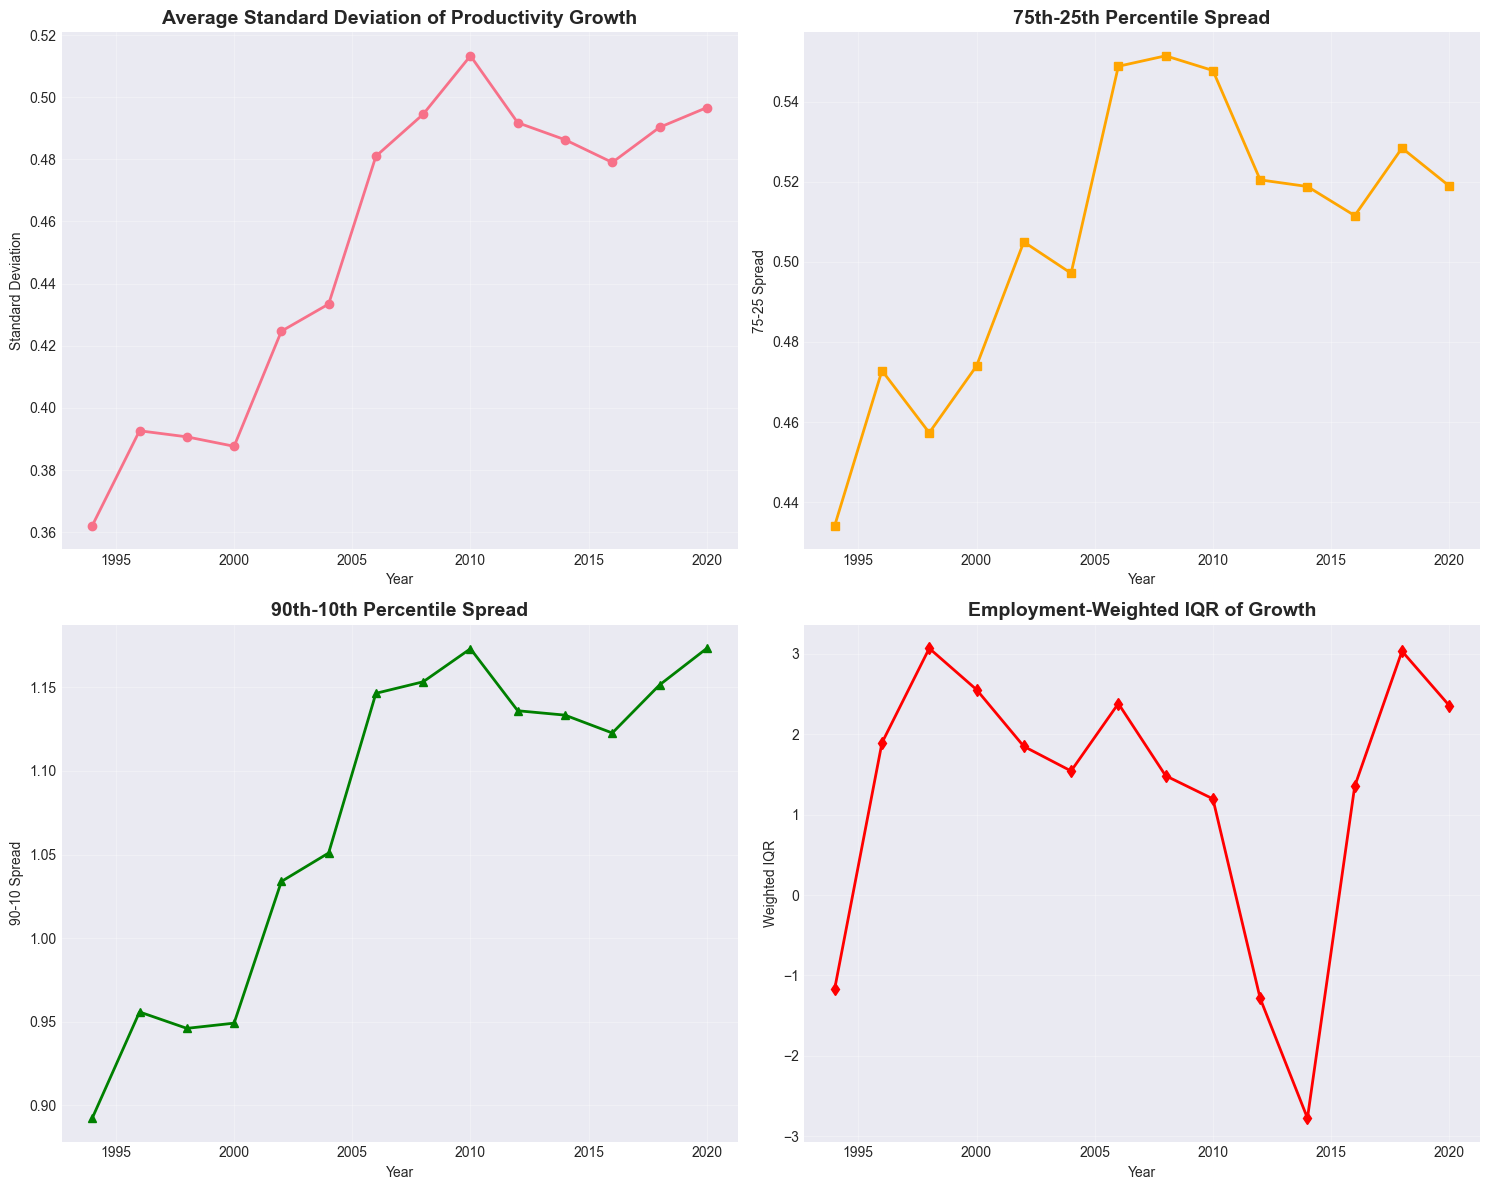

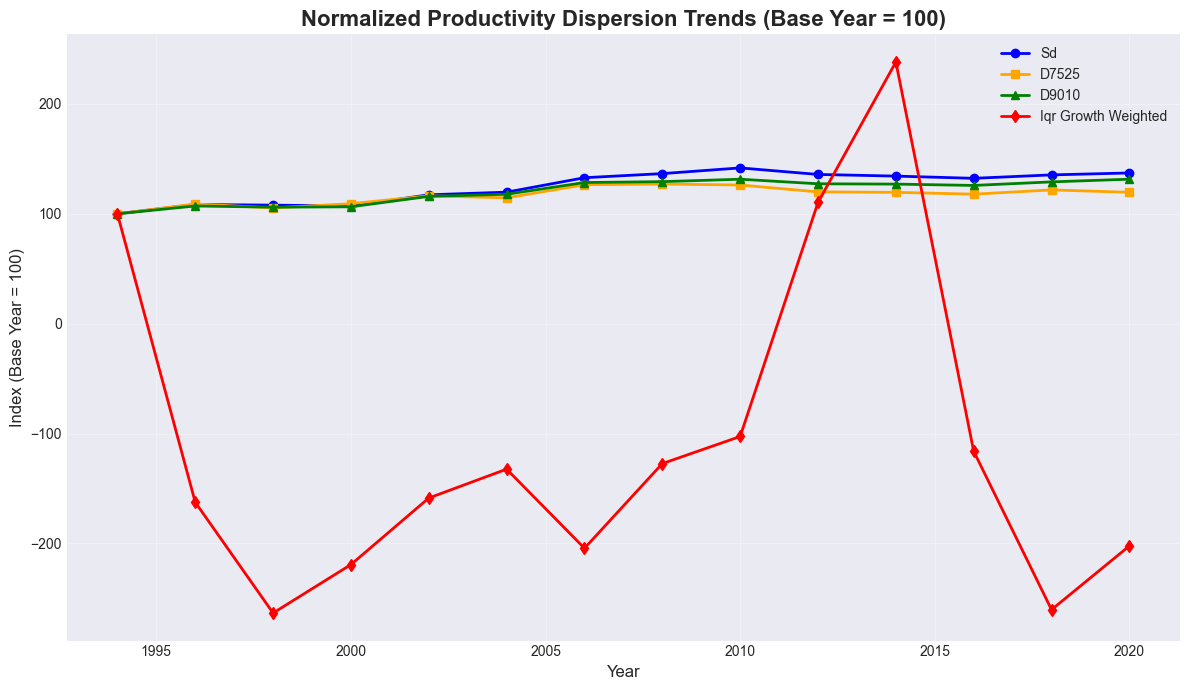

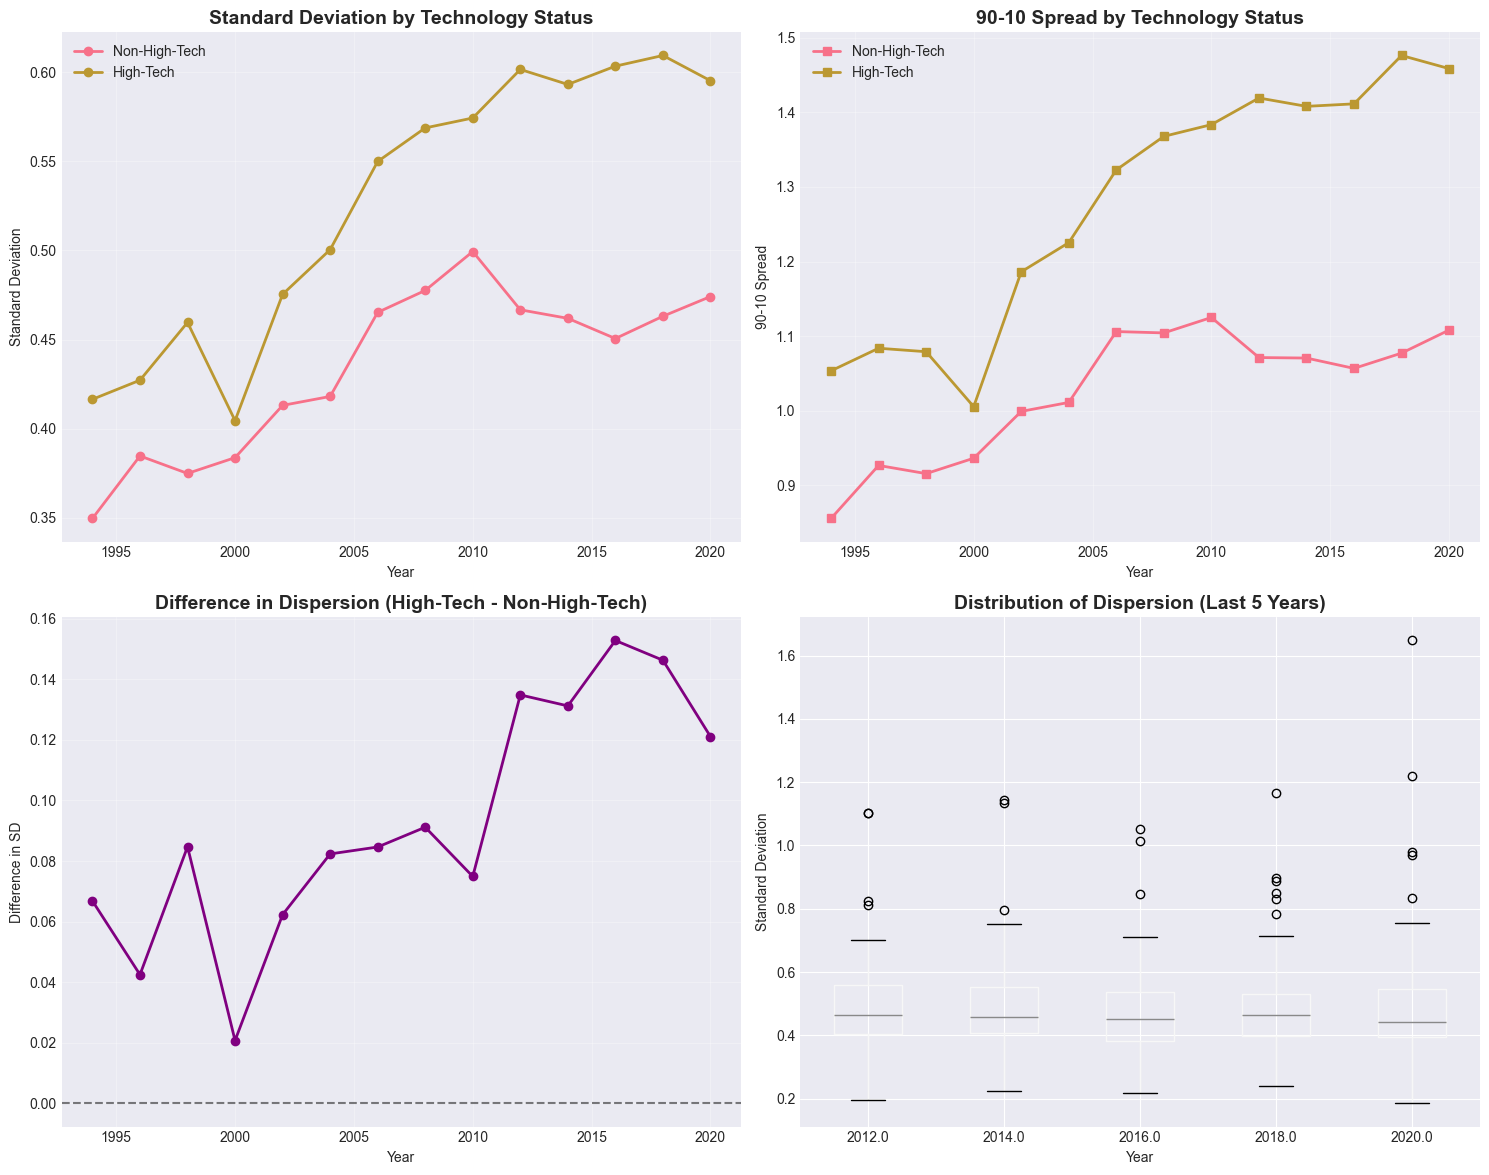

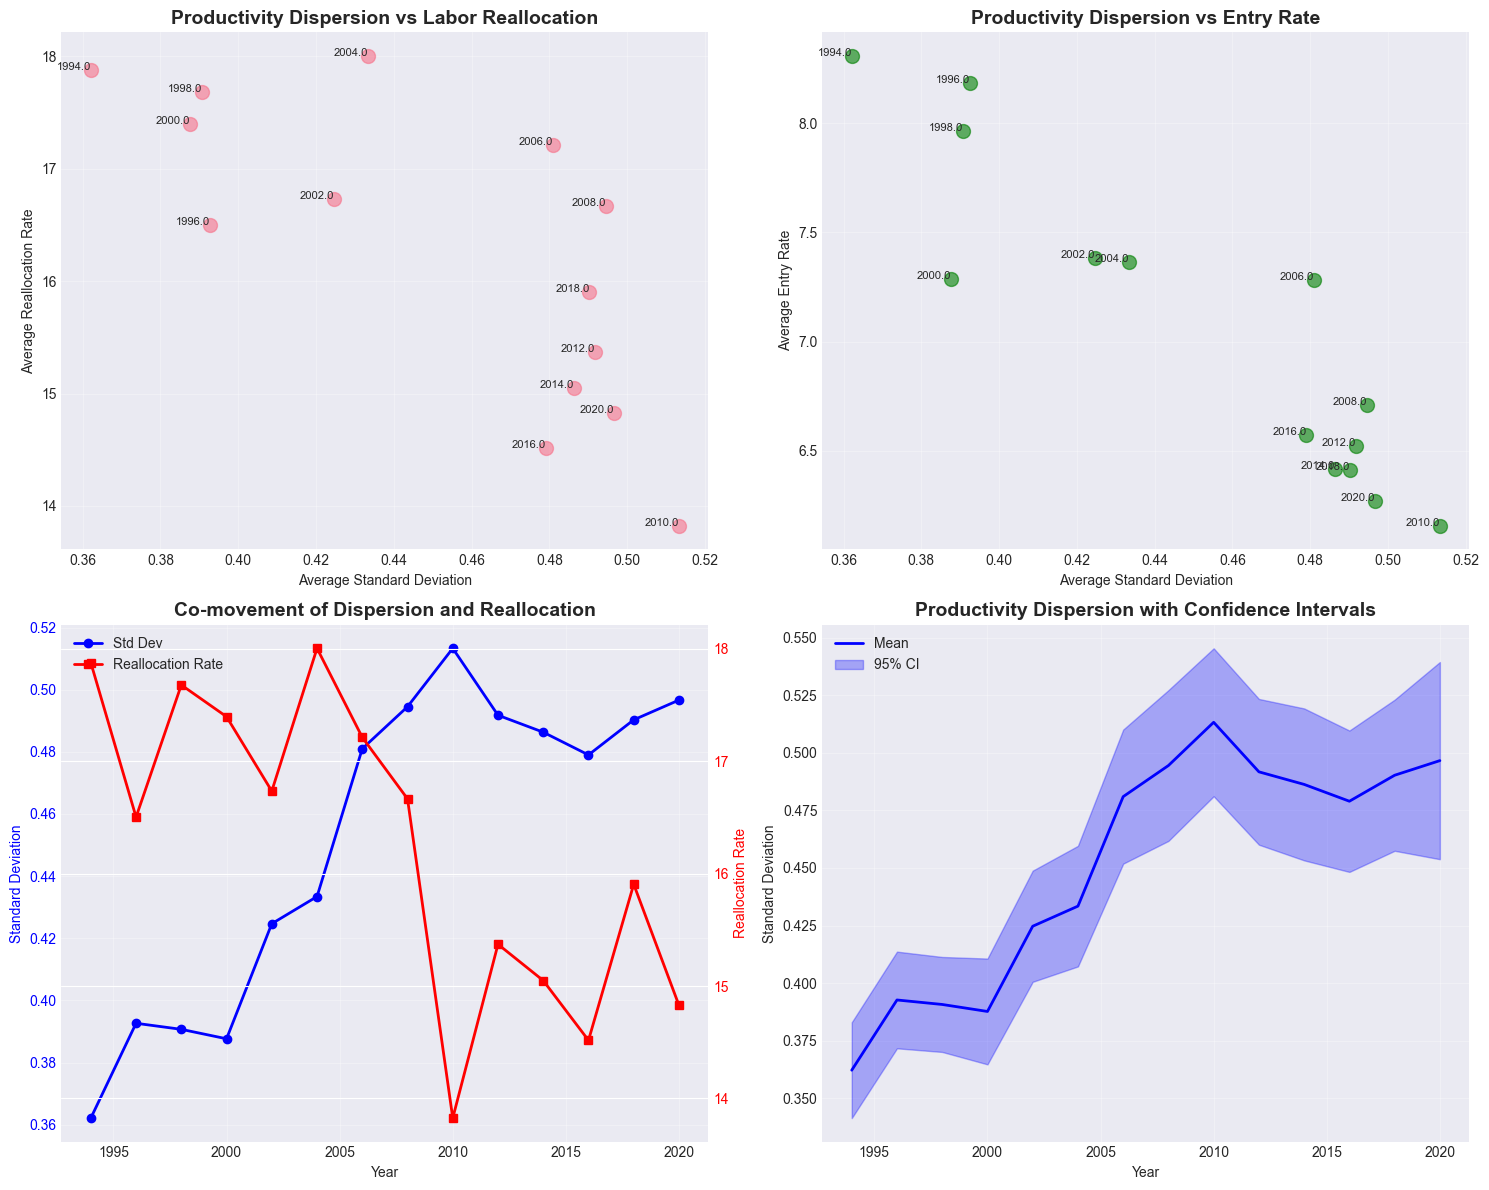

Summary Statistics of Dispersion Measures
              sd      d7525      d9010      d9990  iqr_growth_weighted
count  1204.0000  1204.0000  1204.0000  1204.0000            1204.0000
mean      0.4517     0.5062     1.0727     0.8162               1.2491
std       0.1463     0.2059     0.3834     0.4312              11.5711
min       0.1851     0.1151     0.4294     0.0179             -50.0902
25%       0.3602     0.3846     0.8462     0.5277              -5.0159
50%       0.4227     0.4595     0.9991     0.7227               0.9238
75%       0.5084     0.5556     1.1997     1.0054               6.6562
max       1.6475     2.0000     3.8610     3.4310              55.6066

Correlation Matrix of Dispersion Measures
                        sd  d7525  d9010  d9990  iqr_growth_weighted
sd                   1.000  0.759  0.928  0.484                0.107
d7525                0.759  1.000  0.823  0.055                0.107
d9010                0.928  0.823  1.000  0.174                0.116


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Overall Dispersion Trends
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Standard Deviation
ax1 = axes[0, 0]
yearly_sd = df_merged.groupby('window_end_year')['sd'].mean()
ax1.plot(yearly_sd.index, yearly_sd.values, marker='o', linewidth=2, markersize=6)
ax1.set_title('Average Standard Deviation of Productivity Growth', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Standard Deviation')
ax1.grid(True, alpha=0.3)

# 75-25 Percentile Spread
ax2 = axes[0, 1]
yearly_d7525 = df_merged.groupby('window_end_year')['d7525'].mean()
ax2.plot(yearly_d7525.index, yearly_d7525.values, marker='s', linewidth=2, markersize=6, color='orange')
ax2.set_title('75th-25th Percentile Spread', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('75-25 Spread')
ax2.grid(True, alpha=0.3)

# 90-10 Percentile Spread
ax3 = axes[1, 0]
yearly_d9010 = df_merged.groupby('window_end_year')['d9010'].mean()
ax3.plot(yearly_d9010.index, yearly_d9010.values, marker='^', linewidth=2, markersize=6, color='green')
ax3.set_title('90th-10th Percentile Spread', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('90-10 Spread')
ax3.grid(True, alpha=0.3)

# IQR Growth Weighted
ax4 = axes[1, 1]
yearly_iqr = df_merged.groupby('window_end_year')['iqr_growth_weighted'].mean()
ax4.plot(yearly_iqr.index, yearly_iqr.values, marker='d', linewidth=2, markersize=6, color='red')
ax4.set_title('Employment-Weighted IQR of Growth', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Weighted IQR')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Compare All Dispersion Measures on Same Scale (Normalized)
fig, ax = plt.subplots(figsize=(12, 7))

# Normalize each series to start at 100
measures = ['sd', 'd7525', 'd9010', 'iqr_growth_weighted']
colors = ['blue', 'orange', 'green', 'red']
markers = ['o', 's', '^', 'd']

for measure, color, marker in zip(measures, colors, markers):
    yearly_data = df_merged.groupby('window_end_year')[measure].mean()
    # Normalize to 100 at first year
    normalized = (yearly_data / yearly_data.iloc[0]) * 100
    ax.plot(normalized.index, normalized.values, marker=marker, 
            linewidth=2, markersize=6, color=color, label=measure.replace('_', ' ').title())

ax.set_title('Normalized Productivity Dispersion Trends (Base Year = 100)', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Index (Base Year = 100)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. High-Tech vs Non-High-Tech Dispersion Trends
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Standard Deviation by tech status
ax1 = axes[0, 0]
for tech_status, group in df_merged.groupby('hightech'):
    yearly_sd = group.groupby('window_end_year')['sd'].mean()
    label = 'High-Tech' if tech_status == 1 else 'Non-High-Tech'
    ax1.plot(yearly_sd.index, yearly_sd.values, marker='o', linewidth=2, 
             markersize=6, label=label)
ax1.set_title('Standard Deviation by Technology Status', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Standard Deviation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 90-10 spread by tech status
ax2 = axes[0, 1]
for tech_status, group in df_merged.groupby('hightech'):
    yearly_d9010 = group.groupby('window_end_year')['d9010'].mean()
    label = 'High-Tech' if tech_status == 1 else 'Non-High-Tech'
    ax2.plot(yearly_d9010.index, yearly_d9010.values, marker='s', linewidth=2, 
             markersize=6, label=label)
ax2.set_title('90-10 Spread by Technology Status', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('90-10 Spread')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Difference in dispersion (High-Tech minus Non-High-Tech)
ax3 = axes[1, 0]
hightech_sd = df_merged[df_merged['hightech']==1].groupby('window_end_year')['sd'].mean()
nonhightech_sd = df_merged[df_merged['hightech']==0].groupby('window_end_year')['sd'].mean()
diff_sd = hightech_sd - nonhightech_sd
ax3.plot(diff_sd.index, diff_sd.values, marker='o', linewidth=2, markersize=6, color='purple')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.set_title('Difference in Dispersion (High-Tech - Non-High-Tech)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Difference in SD')
ax3.grid(True, alpha=0.3)

# Box plot of dispersion by year (last 5 years)
ax4 = axes[1, 1]
recent_years = sorted(df_merged['window_end_year'].unique())[-5:]
recent_data = df_merged[df_merged['window_end_year'].isin(recent_years)]
recent_data.boxplot(column='sd', by='window_end_year', ax=ax4)
ax4.set_title('Distribution of Dispersion (Last 5 Years)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Standard Deviation')
plt.suptitle('')  # Remove the automatic title

plt.tight_layout()
plt.show()

# 4. Relationship between Dispersion and Labor Market Dynamics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Dispersion vs Reallocation Rate
ax1 = axes[0, 0]
yearly_data = df_merged.groupby('window_end_year')[['sd', 'reallocation_rate']].mean()
ax1.scatter(yearly_data['sd'], yearly_data['reallocation_rate'], s=100, alpha=0.6)
for idx, year in enumerate(yearly_data.index):
    ax1.annotate(str(year), (yearly_data['sd'].iloc[idx], yearly_data['reallocation_rate'].iloc[idx]),
                 fontsize=8, ha='right')
ax1.set_xlabel('Average Standard Deviation')
ax1.set_ylabel('Average Reallocation Rate')
ax1.set_title('Productivity Dispersion vs Labor Reallocation', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Dispersion vs Entry Rate
ax2 = axes[0, 1]
yearly_data = df_merged.groupby('window_end_year')[['sd', 'estabs_entry_rate']].mean()
ax2.scatter(yearly_data['sd'], yearly_data['estabs_entry_rate'], s=100, alpha=0.6, color='green')
for idx, year in enumerate(yearly_data.index):
    ax2.annotate(str(year), (yearly_data['sd'].iloc[idx], yearly_data['estabs_entry_rate'].iloc[idx]),
                 fontsize=8, ha='right')
ax2.set_xlabel('Average Standard Deviation')
ax2.set_ylabel('Average Entry Rate')
ax2.set_title('Productivity Dispersion vs Entry Rate', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Time series of dispersion and reallocation
ax3 = axes[1, 0]
yearly_sd = df_merged.groupby('window_end_year')['sd'].mean()
yearly_realloc = df_merged.groupby('window_end_year')['reallocation_rate'].mean()

ax3_twin = ax3.twinx()
line1 = ax3.plot(yearly_sd.index, yearly_sd.values, 'b-', marker='o', linewidth=2, label='Std Dev')
line2 = ax3_twin.plot(yearly_realloc.index, yearly_realloc.values, 'r-', marker='s', linewidth=2, label='Reallocation Rate')

ax3.set_xlabel('Year')
ax3.set_ylabel('Standard Deviation', color='b')
ax3_twin.set_ylabel('Reallocation Rate', color='r')
ax3.tick_params(axis='y', labelcolor='b')
ax3_twin.tick_params(axis='y', labelcolor='r')
ax3.set_title('Co-movement of Dispersion and Reallocation', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='upper left')

# Dispersion trends with confidence intervals
ax4 = axes[1, 1]
yearly_stats = df_merged.groupby('window_end_year')['sd'].agg(['mean', 'std', 'count'])
yearly_stats['se'] = yearly_stats['std'] / np.sqrt(yearly_stats['count'])
yearly_stats['ci_lower'] = yearly_stats['mean'] - 1.96 * yearly_stats['se']
yearly_stats['ci_upper'] = yearly_stats['mean'] + 1.96 * yearly_stats['se']

ax4.plot(yearly_stats.index, yearly_stats['mean'], 'b-', linewidth=2, label='Mean')
ax4.fill_between(yearly_stats.index, yearly_stats['ci_lower'], yearly_stats['ci_upper'], 
                 alpha=0.3, color='blue', label='95% CI')
ax4.set_xlabel('Year')
ax4.set_ylabel('Standard Deviation')
ax4.set_title('Productivity Dispersion with Confidence Intervals', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Summary Statistics Table
print("Summary Statistics of Dispersion Measures")
print("=" * 60)
dispersion_cols = ['sd', 'd7525', 'd9010', 'd9990', 'iqr_growth_weighted']
summary_stats = df_merged[dispersion_cols].describe()
print(summary_stats.round(4))

# Correlation matrix
print("\nCorrelation Matrix of Dispersion Measures")
print("=" * 60)
corr_matrix = df_merged[dispersion_cols].corr()
print(corr_matrix.round(3))

# Trends summary
print("\nTrends Summary (% change from first to last year)")
print("=" * 60)
for col in dispersion_cols:
    yearly_mean = df_merged.groupby('window_end_year')[col].mean()
    pct_change = ((yearly_mean.iloc[-1] - yearly_mean.iloc[0]) / yearly_mean.iloc[0]) * 100
    print(f"{col}: {pct_change:.1f}%")

INVESTIGATION OF IQR_GROWTH_WEIGHTED

Basic Statistics:
Mean: 1.2491
Median: 0.9238
Std Dev: 11.5711
Min: -50.0902
Max: 55.6066

Extreme Values Analysis:
Number of negative values: 548
Number of values < -10: 152
Number of values > 10: 175

Percentile Analysis:
1th percentile: -26.0800
5th percentile: -15.3656
10th percentile: -11.4805
25th percentile: -5.0159
50th percentile: 0.9238
75th percentile: 6.6562
90th percentile: 13.2957
95th percentile: 18.3823
99th percentile: 41.7434


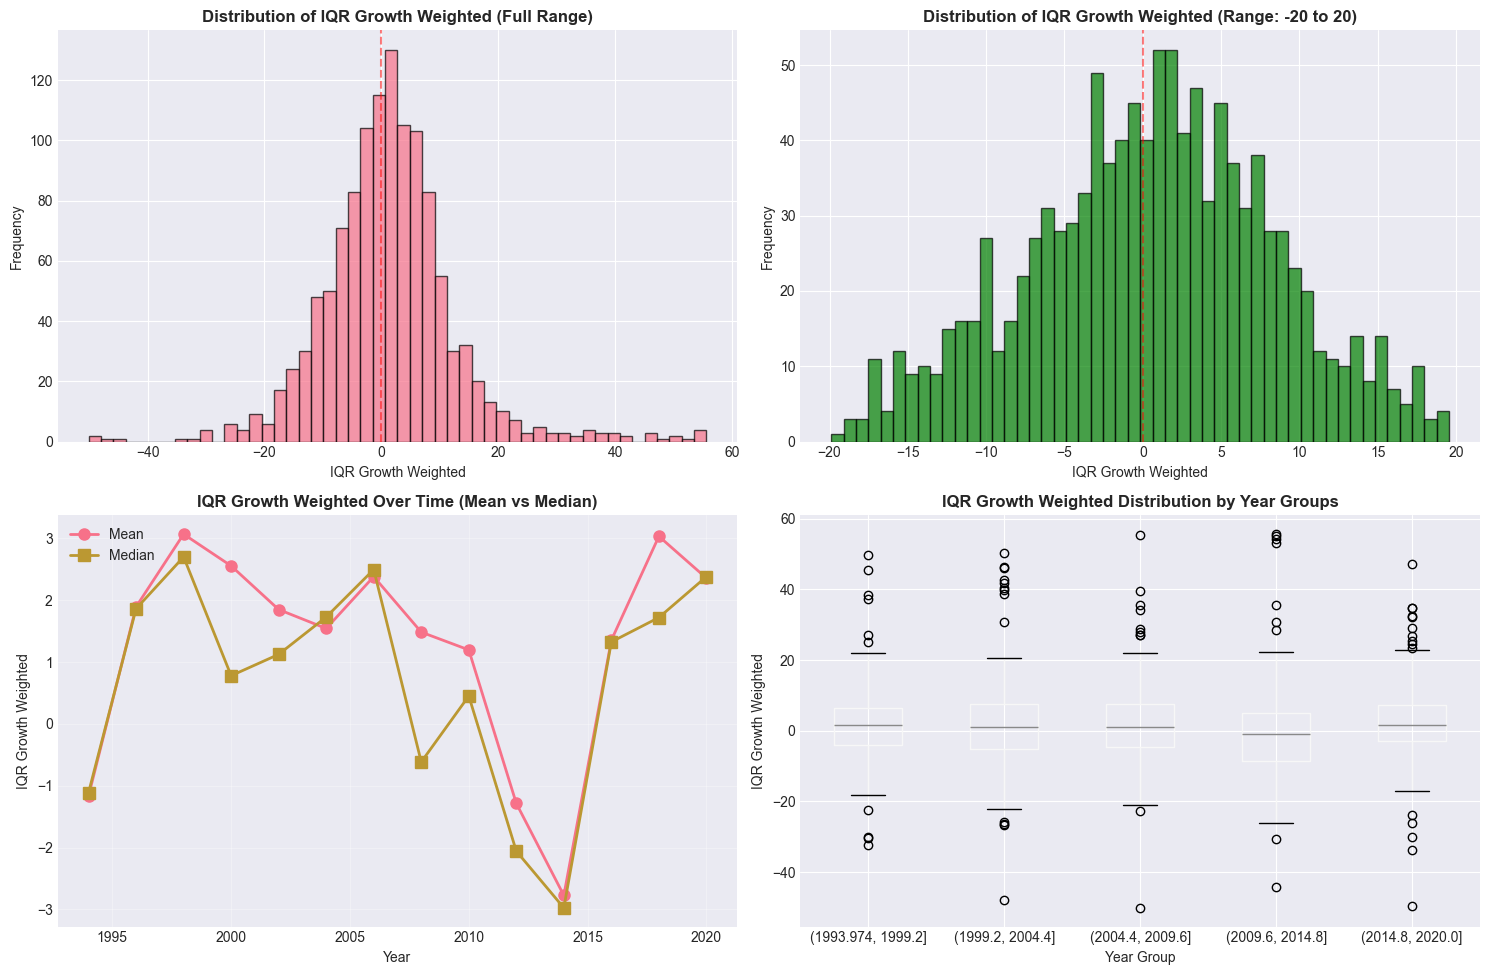


COMPARISON WITH OTHER DISPERSION MEASURES


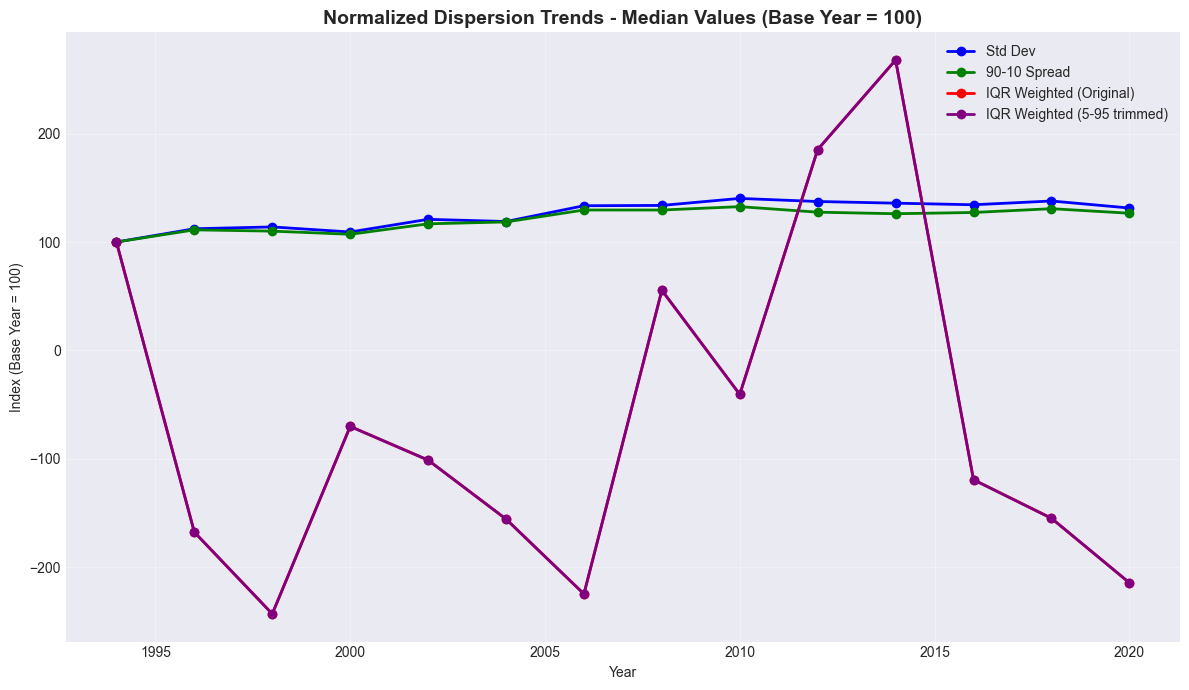


Most Extreme Observations:
Top 5 highest values:
     naics4  window_end_year  iqr_growth_weighted  firms    emp
906    3341           2014.0            55.606575    955  43155
931    3343           2008.0            55.313515    437  13944
148    3122           2010.0            55.067440     76  14064
905    3341           2012.0            54.268162    970  63862
974    3346           2010.0            52.999142    540  19147

Bottom 5 lowest values:
     naics4  window_end_year  iqr_growth_weighted  firms    emp
146    3122           2006.0           -50.090240     84  21223
909    3341           2020.0           -49.415698    758  38804
145    3122           2004.0           -47.724849    104  21822
933    3343           2012.0           -44.245569    420   9289
236    3151           2018.0           -33.716284    194  10584

RELATIONSHIP WITH SAMPLE SIZE


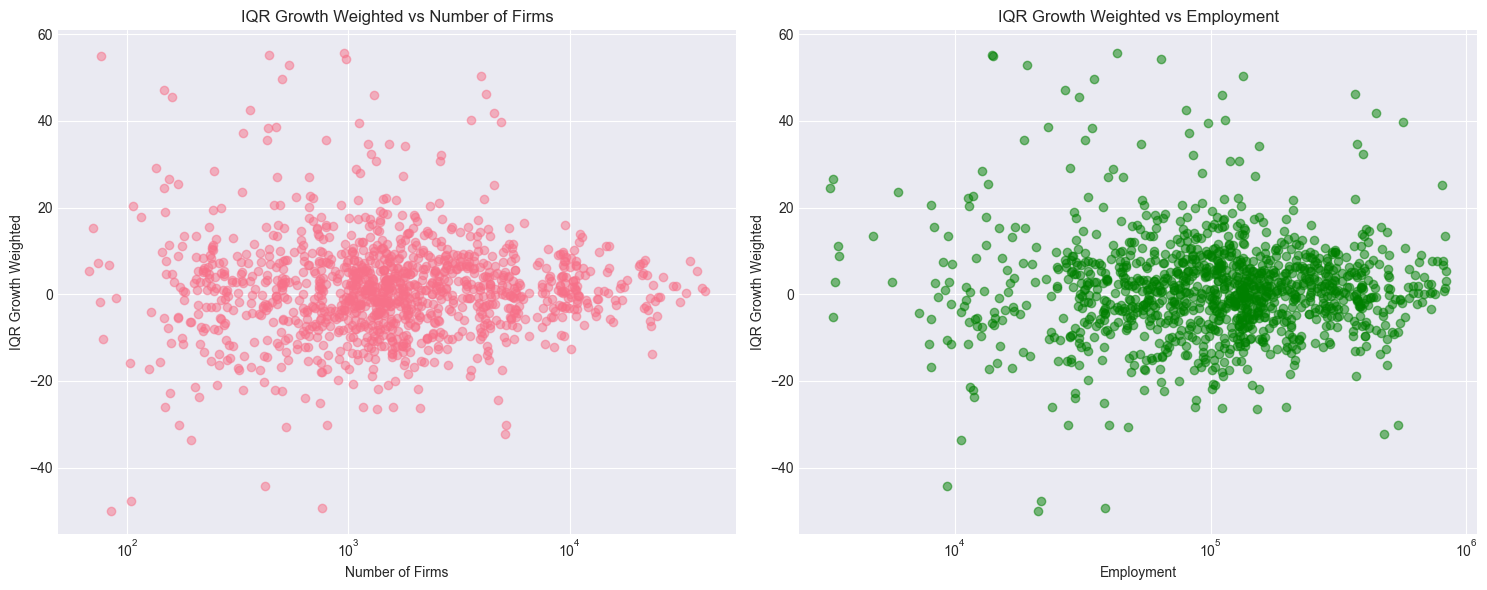


Year-by-Year Statistics:
                 mean  median    std    min    max  count
window_end_year                                          
1994.0          -1.17   -1.11   9.82 -32.22  38.27     86
1996.0           1.89    1.86   9.14 -30.16  49.78     86
1998.0           3.07    2.70  11.28 -22.38  45.48     86
2000.0           2.55    0.78  13.11 -25.92  50.32     86
2002.0           1.85    1.12   9.62 -26.57  41.79     86
2004.0           1.54    1.73  13.22 -47.72  46.24     86
2006.0           2.38    2.50  12.08 -50.09  39.56     86
2008.0           1.48   -0.62  11.88 -22.82  55.31     86
2010.0           1.20    0.45  12.36 -26.04  55.07     86
2012.0          -1.29   -2.06  13.21 -44.25  54.27     86
2014.0          -2.77   -2.98  11.72 -22.11  55.61     86
2016.0           1.35    1.33   9.83 -26.08  34.74     86
2018.0           3.03    1.72  11.51 -33.72  47.24     86
2020.0           2.36    2.38  11.28 -49.42  32.43     86

Correlation between iqr_growth_weighted and d

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Detailed examination of iqr_growth_weighted
print("INVESTIGATION OF IQR_GROWTH_WEIGHTED")
print("=" * 80)

# Basic statistics
print("\nBasic Statistics:")
print(f"Mean: {df_merged['iqr_growth_weighted'].mean():.4f}")
print(f"Median: {df_merged['iqr_growth_weighted'].median():.4f}")
print(f"Std Dev: {df_merged['iqr_growth_weighted'].std():.4f}")
print(f"Min: {df_merged['iqr_growth_weighted'].min():.4f}")
print(f"Max: {df_merged['iqr_growth_weighted'].max():.4f}")

# Check for extreme values
print("\nExtreme Values Analysis:")
print(f"Number of negative values: {(df_merged['iqr_growth_weighted'] < 0).sum()}")
print(f"Number of values < -10: {(df_merged['iqr_growth_weighted'] < -10).sum()}")
print(f"Number of values > 10: {(df_merged['iqr_growth_weighted'] > 10).sum()}")

# Percentile analysis
print("\nPercentile Analysis:")
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    val = df_merged['iqr_growth_weighted'].quantile(p/100)
    print(f"{p}th percentile: {val:.4f}")

# 2. Visualize the distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram with full range
ax1 = axes[0, 0]
ax1.hist(df_merged['iqr_growth_weighted'], bins=50, edgecolor='black', alpha=0.7)
ax1.set_title('Distribution of IQR Growth Weighted (Full Range)', fontsize=12, fontweight='bold')
ax1.set_xlabel('IQR Growth Weighted')
ax1.set_ylabel('Frequency')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Histogram with restricted range (-20 to 20)
ax2 = axes[0, 1]
restricted_data = df_merged['iqr_growth_weighted'][(df_merged['iqr_growth_weighted'] >= -20) & 
                                                    (df_merged['iqr_growth_weighted'] <= 20)]
ax2.hist(restricted_data, bins=50, edgecolor='black', alpha=0.7, color='green')
ax2.set_title('Distribution of IQR Growth Weighted (Range: -20 to 20)', fontsize=12, fontweight='bold')
ax2.set_xlabel('IQR Growth Weighted')
ax2.set_ylabel('Frequency')
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Time series with outliers highlighted
ax3 = axes[1, 0]
yearly_mean = df_merged.groupby('window_end_year')['iqr_growth_weighted'].mean()
yearly_median = df_merged.groupby('window_end_year')['iqr_growth_weighted'].median()
ax3.plot(yearly_mean.index, yearly_mean.values, marker='o', linewidth=2, label='Mean', markersize=8)
ax3.plot(yearly_median.index, yearly_median.values, marker='s', linewidth=2, label='Median', markersize=8)
ax3.set_title('IQR Growth Weighted Over Time (Mean vs Median)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('IQR Growth Weighted')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Box plot by year
ax4 = axes[1, 1]
# Create year groups for better visualization
year_groups = pd.cut(df_merged['window_end_year'], bins=5)
df_merged['year_group'] = year_groups
df_merged.boxplot(column='iqr_growth_weighted', by='year_group', ax=ax4)
ax4.set_title('IQR Growth Weighted Distribution by Year Groups', fontsize=12, fontweight='bold')
ax4.set_xlabel('Year Group')
ax4.set_ylabel('IQR Growth Weighted')
plt.suptitle('')

plt.tight_layout()
plt.show()

# 3. Compare with other measures
print("\n" + "=" * 80)
print("COMPARISON WITH OTHER DISPERSION MEASURES")
print("=" * 80)

# Create a trimmed version (removing extreme outliers)
iqr_p5 = df_merged['iqr_growth_weighted'].quantile(0.05)
iqr_p95 = df_merged['iqr_growth_weighted'].quantile(0.95)
df_merged['iqr_trimmed'] = df_merged['iqr_growth_weighted'].clip(lower=iqr_p5, upper=iqr_p95)

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 7))

# Normalize all measures to compare trends
measures = ['sd', 'd9010', 'iqr_growth_weighted', 'iqr_trimmed']
colors = ['blue', 'green', 'red', 'purple']
labels = ['Std Dev', '90-10 Spread', 'IQR Weighted (Original)', 'IQR Weighted (5-95 trimmed)']

for measure, color, label in zip(measures, colors, labels):
    yearly_data = df_merged.groupby('window_end_year')[measure].median()  # Using median for robustness
    if yearly_data.iloc[0] != 0:  # Avoid division by zero
        normalized = (yearly_data / yearly_data.iloc[0]) * 100
        ax.plot(normalized.index, normalized.values, marker='o', 
                linewidth=2, markersize=6, color=color, label=label)

ax.set_title('Normalized Dispersion Trends - Median Values (Base Year = 100)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Index (Base Year = 100)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Identify problematic observations
print("\nMost Extreme Observations:")
extreme_obs = df_merged.nlargest(5, 'iqr_growth_weighted')[['naics4', 'window_end_year', 'iqr_growth_weighted', 'firms', 'emp']]
print("Top 5 highest values:")
print(extreme_obs)

print("\nBottom 5 lowest values:")
extreme_obs_low = df_merged.nsmallest(5, 'iqr_growth_weighted')[['naics4', 'window_end_year', 'iqr_growth_weighted', 'firms', 'emp']]
print(extreme_obs_low)

# 5. Check if it's related to sample size
print("\n" + "=" * 80)
print("RELATIONSHIP WITH SAMPLE SIZE")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot: IQR vs number of firms
ax1 = axes[0]
ax1.scatter(df_merged['firms'], df_merged['iqr_growth_weighted'], alpha=0.5)
ax1.set_xlabel('Number of Firms')
ax1.set_ylabel('IQR Growth Weighted')
ax1.set_title('IQR Growth Weighted vs Number of Firms')
ax1.set_xscale('log')

# Scatter plot: IQR vs employment
ax2 = axes[1]
ax2.scatter(df_merged['emp'], df_merged['iqr_growth_weighted'], alpha=0.5, color='green')
ax2.set_xlabel('Employment')
ax2.set_ylabel('IQR Growth Weighted')
ax2.set_title('IQR Growth Weighted vs Employment')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

# 6. Year-by-year analysis
print("\nYear-by-Year Statistics:")
yearly_stats = df_merged.groupby('window_end_year')['iqr_growth_weighted'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
print(yearly_stats.round(2))

# Check correlation with d9010_growth_weighted if it exists
if 'd9010_growth_weighted' in df_merged.columns:
    corr = df_merged[['iqr_growth_weighted', 'd9010_growth_weighted']].corr()
    print(f"\nCorrelation between iqr_growth_weighted and d9010_growth_weighted: {corr.iloc[0,1]:.3f}")

# Recommendation
print("\n" + "=" * 80)
print("RECOMMENDATIONS:")
print("=" * 80)
print("1. The IQR weighted measure shows extreme values and high variance")
print("2. The -302% change suggests the measure may be switching from positive to negative")
print("3. Consider using median instead of mean for this variable")
print("4. May want to investigate the calculation methodology or use trimmed versions")
print("5. Check if negative values are meaningful in your context")

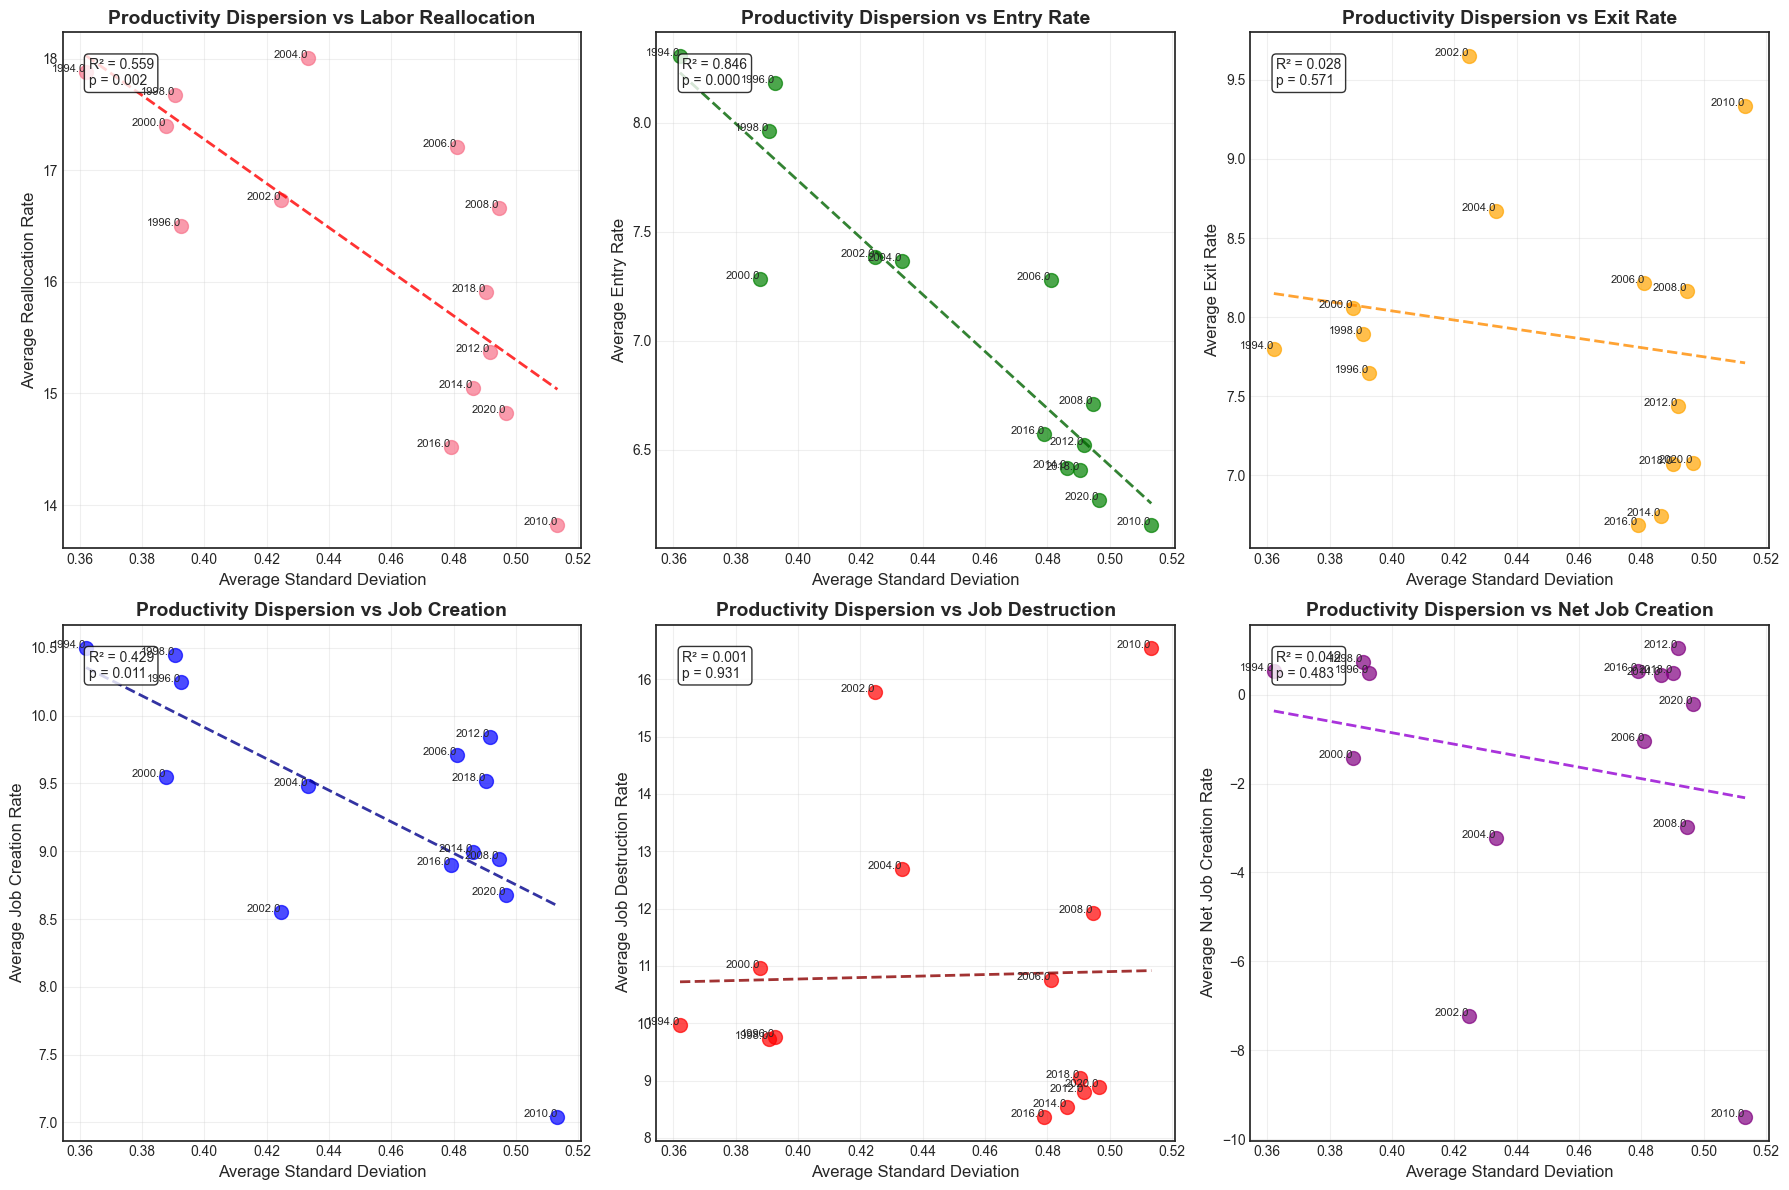

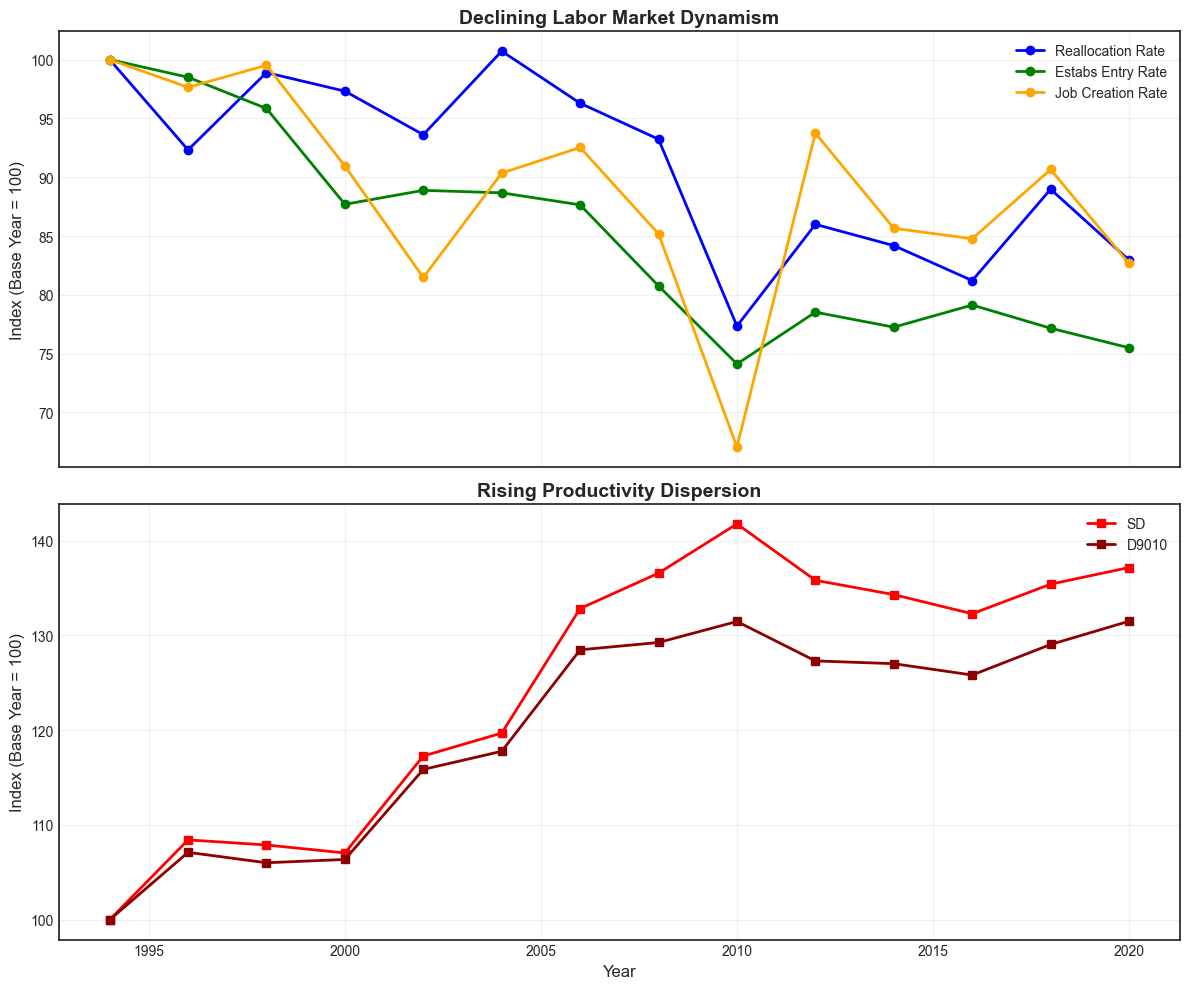

/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_11791/975828464.py:170: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(data_to_plot, labels=['Early Period', 'Late Period'], patch_artist=True)
/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_11791/975828464.py:179: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(data_to_plot, labels=['Early Period', 'Late Period'], patch_artist=True)


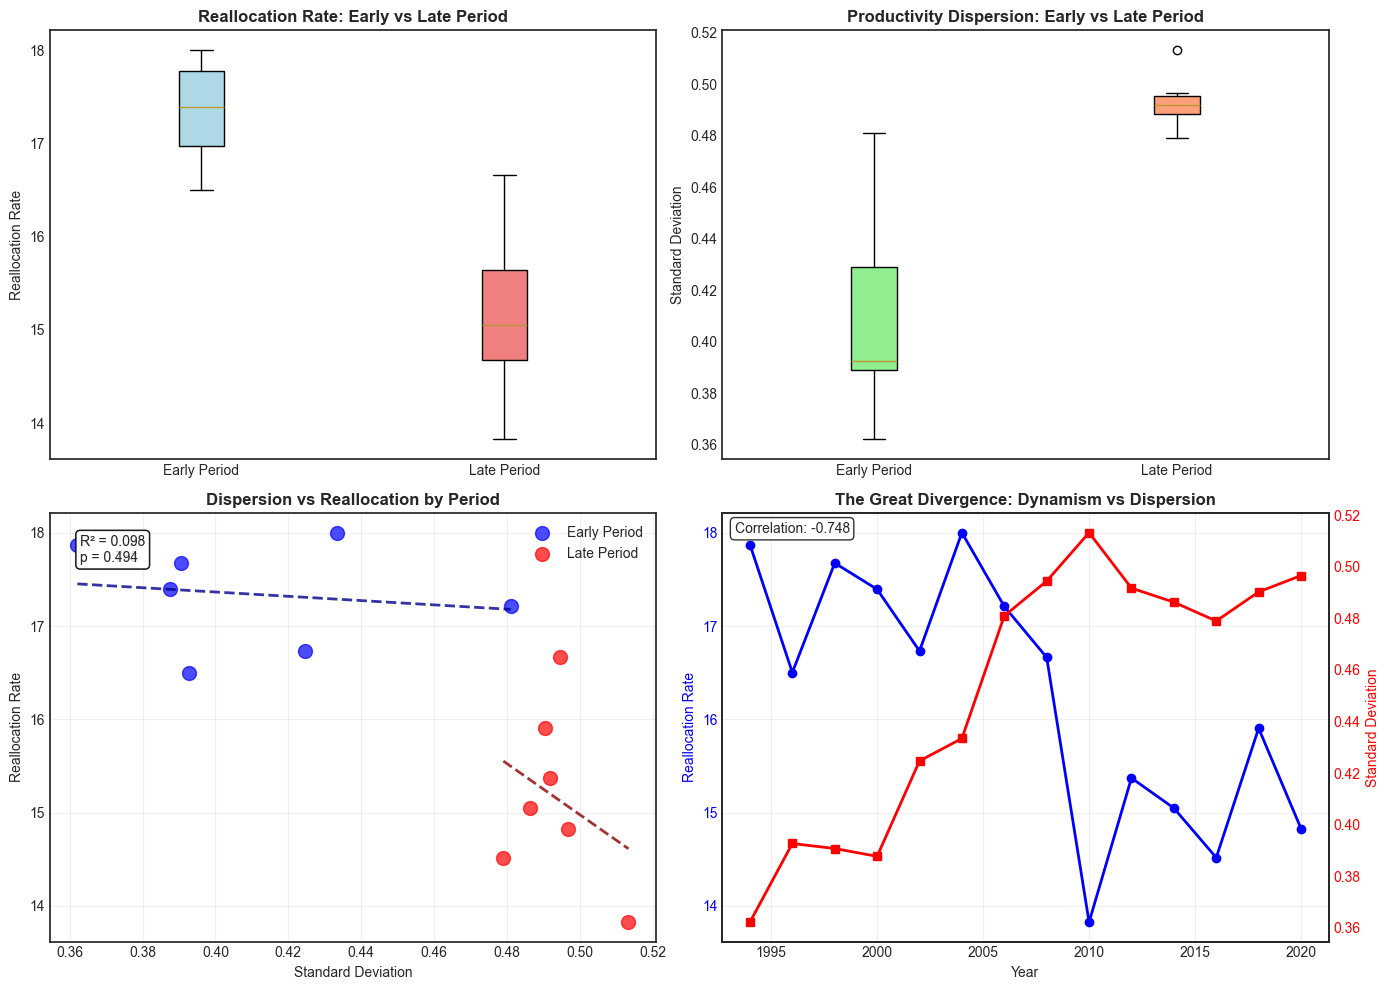

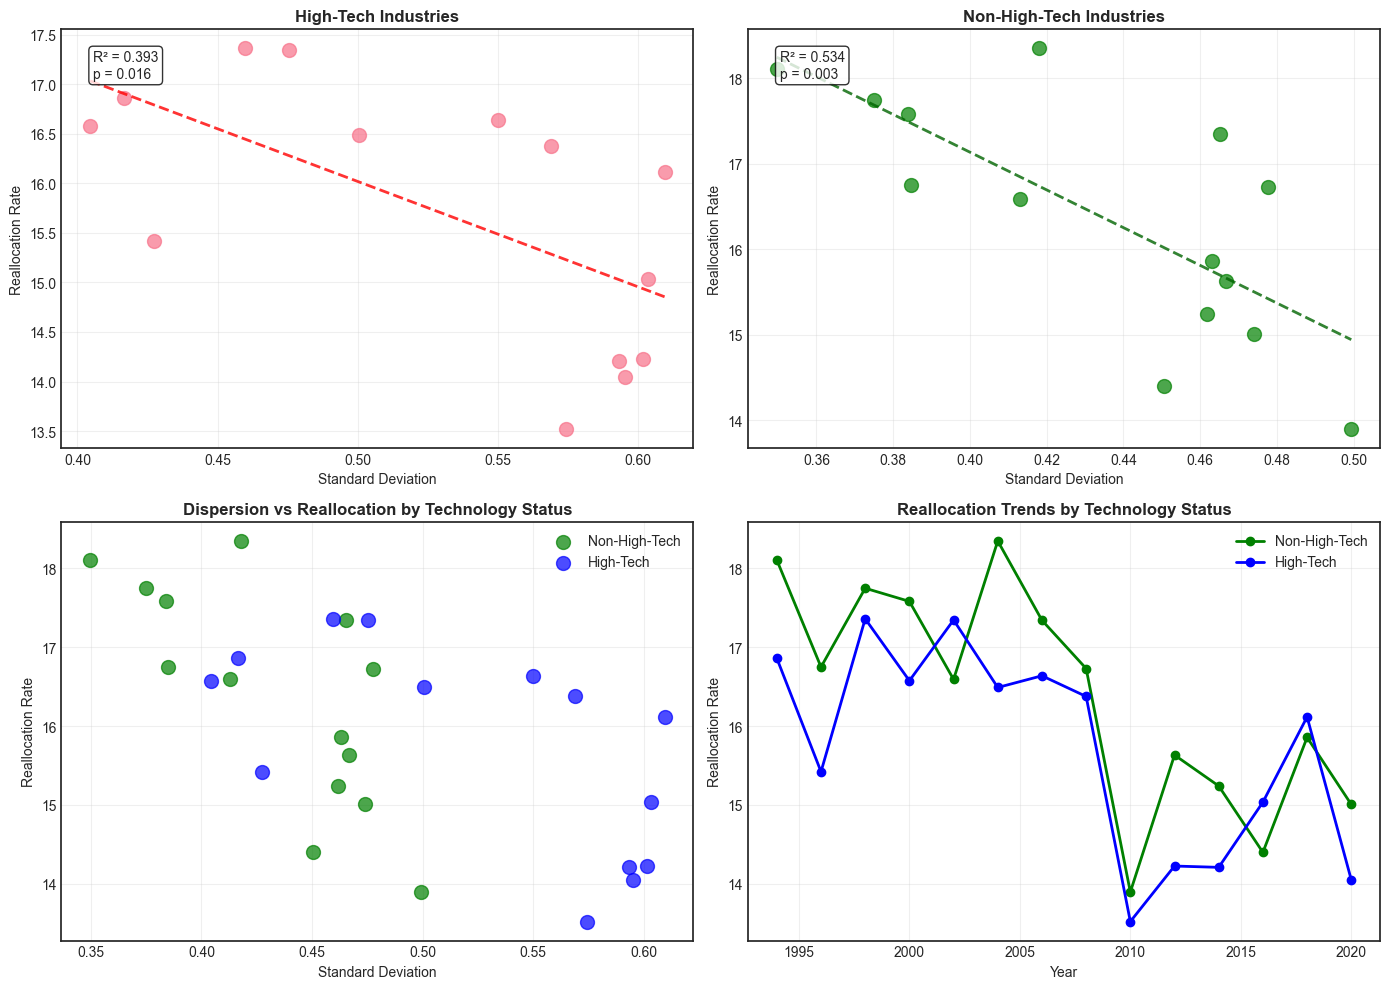


CORRELATION ANALYSIS


KeyError: "['d7525'] not in index"

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")

# 1. Comprehensive scatter plots with trend lines
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Helper function to add regression line and R²
def add_regression_line(ax, x, y, color='red'):
    # Remove NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]
    
    # Calculate regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
    line_x = np.array([x_clean.min(), x_clean.max()])
    line_y = slope * line_x + intercept
    
    # Plot regression line
    ax.plot(line_x, line_y, color=color, linestyle='--', linewidth=2, alpha=0.8)
    
    # Add R² and p-value
    ax.text(0.05, 0.95, f'R² = {r_value**2:.3f}\np = {p_value:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    return slope, r_value**2

# Calculate yearly averages
yearly_data = df_merged.groupby('window_end_year').agg({
    'sd': 'mean',
    'd9010': 'mean',
    'reallocation_rate': 'mean',
    'estabs_entry_rate': 'mean',
    'estabs_exit_rate': 'mean',
    'job_creation_rate': 'mean',
    'job_destruction_rate': 'mean',
    'net_job_creation_rate': 'mean'
}).reset_index()

# Plot 1: SD vs Reallocation Rate
ax1 = axes[0, 0]
ax1.scatter(yearly_data['sd'], yearly_data['reallocation_rate'], s=100, alpha=0.7)
add_regression_line(ax1, yearly_data['sd'], yearly_data['reallocation_rate'])
for idx, row in yearly_data.iterrows():
    ax1.annotate(str(row['window_end_year']), (row['sd'], row['reallocation_rate']), 
                fontsize=8, ha='right')
ax1.set_xlabel('Average Standard Deviation', fontsize=12)
ax1.set_ylabel('Average Reallocation Rate', fontsize=12)
ax1.set_title('Productivity Dispersion vs Labor Reallocation', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: SD vs Entry Rate
ax2 = axes[0, 1]
ax2.scatter(yearly_data['sd'], yearly_data['estabs_entry_rate'], s=100, alpha=0.7, color='green')
add_regression_line(ax2, yearly_data['sd'], yearly_data['estabs_entry_rate'], 'darkgreen')
for idx, row in yearly_data.iterrows():
    ax2.annotate(str(row['window_end_year']), (row['sd'], row['estabs_entry_rate']), 
                fontsize=8, ha='right')
ax2.set_xlabel('Average Standard Deviation', fontsize=12)
ax2.set_ylabel('Average Entry Rate', fontsize=12)
ax2.set_title('Productivity Dispersion vs Entry Rate', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: SD vs Exit Rate
ax3 = axes[0, 2]
ax3.scatter(yearly_data['sd'], yearly_data['estabs_exit_rate'], s=100, alpha=0.7, color='orange')
add_regression_line(ax3, yearly_data['sd'], yearly_data['estabs_exit_rate'], 'darkorange')
for idx, row in yearly_data.iterrows():
    ax3.annotate(str(row['window_end_year']), (row['sd'], row['estabs_exit_rate']), 
                fontsize=8, ha='right')
ax3.set_xlabel('Average Standard Deviation', fontsize=12)
ax3.set_ylabel('Average Exit Rate', fontsize=12)
ax3.set_title('Productivity Dispersion vs Exit Rate', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: SD vs Job Creation Rate
ax4 = axes[1, 0]
ax4.scatter(yearly_data['sd'], yearly_data['job_creation_rate'], s=100, alpha=0.7, color='blue')
add_regression_line(ax4, yearly_data['sd'], yearly_data['job_creation_rate'], 'darkblue')
for idx, row in yearly_data.iterrows():
    ax4.annotate(str(row['window_end_year']), (row['sd'], row['job_creation_rate']), 
                fontsize=8, ha='right')
ax4.set_xlabel('Average Standard Deviation', fontsize=12)
ax4.set_ylabel('Average Job Creation Rate', fontsize=12)
ax4.set_title('Productivity Dispersion vs Job Creation', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: SD vs Job Destruction Rate
ax5 = axes[1, 1]
ax5.scatter(yearly_data['sd'], yearly_data['job_destruction_rate'], s=100, alpha=0.7, color='red')
add_regression_line(ax5, yearly_data['sd'], yearly_data['job_destruction_rate'], 'darkred')
for idx, row in yearly_data.iterrows():
    ax5.annotate(str(row['window_end_year']), (row['sd'], row['job_destruction_rate']), 
                fontsize=8, ha='right')
ax5.set_xlabel('Average Standard Deviation', fontsize=12)
ax5.set_ylabel('Average Job Destruction Rate', fontsize=12)
ax5.set_title('Productivity Dispersion vs Job Destruction', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Plot 6: SD vs Net Job Creation Rate
ax6 = axes[1, 2]
ax6.scatter(yearly_data['sd'], yearly_data['net_job_creation_rate'], s=100, alpha=0.7, color='purple')
add_regression_line(ax6, yearly_data['sd'], yearly_data['net_job_creation_rate'], 'darkviolet')
for idx, row in yearly_data.iterrows():
    ax6.annotate(str(row['window_end_year']), (row['sd'], row['net_job_creation_rate']), 
                fontsize=8, ha='right')
ax6.set_xlabel('Average Standard Deviation', fontsize=12)
ax6.set_ylabel('Average Net Job Creation Rate', fontsize=12)
ax6.set_title('Productivity Dispersion vs Net Job Creation', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Time series showing the divergence
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Normalize to 100 in base year
base_year = yearly_data['window_end_year'].min()
base_data = yearly_data[yearly_data['window_end_year'] == base_year]

# Plot normalized trends
metrics = ['reallocation_rate', 'estabs_entry_rate', 'job_creation_rate']
colors = ['blue', 'green', 'orange']
for metric, color in zip(metrics, colors):
    normalized = (yearly_data[metric] / base_data[metric].values[0]) * 100
    ax1.plot(yearly_data['window_end_year'], normalized, marker='o', 
             linewidth=2, color=color, label=metric.replace('_', ' ').title())

ax1.set_ylabel('Index (Base Year = 100)', fontsize=12)
ax1.set_title('Declining Labor Market Dynamism', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot dispersion measures
dispersion_metrics = ['sd', 'd9010']
colors = ['red', 'darkred']
for metric, color in zip(dispersion_metrics, colors):
    normalized = (yearly_data[metric] / base_data[metric].values[0]) * 100
    ax2.plot(yearly_data['window_end_year'], normalized, marker='s', 
             linewidth=2, color=color, label=metric.upper() if len(metric) <= 4 else metric.replace('_', ' ').title())

ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Index (Base Year = 100)', fontsize=12)
ax2.set_title('Rising Productivity Dispersion', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Period comparison analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Split data into early and late periods
median_year = yearly_data['window_end_year'].median()
early_period = yearly_data[yearly_data['window_end_year'] <= median_year]
late_period = yearly_data[yearly_data['window_end_year'] > median_year]

# Plot 1: Box plot comparison
ax1 = axes[0, 0]
data_to_plot = [early_period['reallocation_rate'], late_period['reallocation_rate']]
bp1 = ax1.boxplot(data_to_plot, labels=['Early Period', 'Late Period'], patch_artist=True)
bp1['boxes'][0].set_facecolor('lightblue')
bp1['boxes'][1].set_facecolor('lightcoral')
ax1.set_ylabel('Reallocation Rate')
ax1.set_title('Reallocation Rate: Early vs Late Period', fontsize=12, fontweight='bold')

# Plot 2: Box plot for dispersion
ax2 = axes[0, 1]
data_to_plot = [early_period['sd'], late_period['sd']]
bp2 = ax2.boxplot(data_to_plot, labels=['Early Period', 'Late Period'], patch_artist=True)
bp2['boxes'][0].set_facecolor('lightgreen')
bp2['boxes'][1].set_facecolor('lightsalmon')
ax2.set_ylabel('Standard Deviation')
ax2.set_title('Productivity Dispersion: Early vs Late Period', fontsize=12, fontweight='bold')

# Plot 3: Scatter with period coloring
ax3 = axes[1, 0]
ax3.scatter(early_period['sd'], early_period['reallocation_rate'], 
           s=100, alpha=0.7, color='blue', label='Early Period')
ax3.scatter(late_period['sd'], late_period['reallocation_rate'], 
           s=100, alpha=0.7, color='red', label='Late Period')

# Add separate regression lines
add_regression_line(ax3, early_period['sd'], early_period['reallocation_rate'], 'darkblue')
add_regression_line(ax3, late_period['sd'], late_period['reallocation_rate'], 'darkred')

ax3.set_xlabel('Standard Deviation')
ax3.set_ylabel('Reallocation Rate')
ax3.set_title('Dispersion vs Reallocation by Period', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Change over time
ax4 = axes[1, 1]
ax4.plot(yearly_data['window_end_year'], yearly_data['reallocation_rate'], 
         marker='o', linewidth=2, label='Reallocation Rate', color='blue')
ax4_twin = ax4.twinx()
ax4_twin.plot(yearly_data['window_end_year'], yearly_data['sd'], 
              marker='s', linewidth=2, label='Std Dev', color='red')

ax4.set_xlabel('Year')
ax4.set_ylabel('Reallocation Rate', color='blue')
ax4_twin.set_ylabel('Standard Deviation', color='red')
ax4.tick_params(axis='y', labelcolor='blue')
ax4_twin.tick_params(axis='y', labelcolor='red')
ax4.set_title('The Great Divergence: Dynamism vs Dispersion', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add correlation text
corr = yearly_data[['sd', 'reallocation_rate']].corr().iloc[0, 1]
ax4.text(0.02, 0.98, f'Correlation: {corr:.3f}', transform=ax4.transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# 4. High-tech vs Non-high-tech analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calculate by tech status
tech_yearly = df_merged.groupby(['window_end_year', 'hightech']).agg({
    'sd': 'mean',
    'reallocation_rate': 'mean',
    'estabs_entry_rate': 'mean'
}).reset_index()

# Plot for high-tech
ax1 = axes[0, 0]
hightech_data = tech_yearly[tech_yearly['hightech'] == 1]
ax1.scatter(hightech_data['sd'], hightech_data['reallocation_rate'], s=100, alpha=0.7)
add_regression_line(ax1, hightech_data['sd'], hightech_data['reallocation_rate'])
ax1.set_xlabel('Standard Deviation')
ax1.set_ylabel('Reallocation Rate')
ax1.set_title('High-Tech Industries', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot for non-high-tech
ax2 = axes[0, 1]
nonhightech_data = tech_yearly[tech_yearly['hightech'] == 0]
ax2.scatter(nonhightech_data['sd'], nonhightech_data['reallocation_rate'], s=100, alpha=0.7, color='green')
add_regression_line(ax2, nonhightech_data['sd'], nonhightech_data['reallocation_rate'], 'darkgreen')
ax2.set_xlabel('Standard Deviation')
ax2.set_ylabel('Reallocation Rate')
ax2.set_title('Non-High-Tech Industries', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Combined plot with different colors
ax3 = axes[1, 0]
for tech_status, group in tech_yearly.groupby('hightech'):
    label = 'High-Tech' if tech_status == 1 else 'Non-High-Tech'
    color = 'blue' if tech_status == 1 else 'green'
    ax3.scatter(group['sd'], group['reallocation_rate'], s=100, alpha=0.7, label=label, color=color)
    
ax3.set_xlabel('Standard Deviation')
ax3.set_ylabel('Reallocation Rate')
ax3.set_title('Dispersion vs Reallocation by Technology Status', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Time trends by tech status
ax4 = axes[1, 1]
for tech_status, group in tech_yearly.groupby('hightech'):
    label = 'High-Tech' if tech_status == 1 else 'Non-High-Tech'
    color = 'blue' if tech_status == 1 else 'green'
    ax4.plot(group['window_end_year'], group['reallocation_rate'], 
             marker='o', linewidth=2, label=label, color=color)
    
ax4.set_xlabel('Year')
ax4.set_ylabel('Reallocation Rate')
ax4.set_title('Reallocation Trends by Technology Status', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Summary statistics and correlations
print("\nCORRELATION ANALYSIS")
print("=" * 60)

# Overall correlations
dynamism_vars = ['reallocation_rate', 'estabs_entry_rate', 'estabs_exit_rate', 
                 'job_creation_rate', 'job_destruction_rate']
dispersion_vars = ['sd', 'd7525', 'd9010']

corr_matrix = yearly_data[dynamism_vars + dispersion_vars].corr()
print("\nCorrelations between Dispersion and Dynamism Measures:")
print(corr_matrix.loc[dispersion_vars, dynamism_vars].round(3))

# Period-specific correlations
print("\nEarly Period Correlations (SD vs Dynamism):")
early_corr = early_period[['sd'] + dynamism_vars].corr()
print(early_corr.loc[['sd'], dynamism_vars].round(3))

print("\nLate Period Correlations (SD vs Dynamism):")
late_corr = late_period[['sd'] + dynamism_vars].corr()
print(late_corr.loc[['sd'], dynamism_vars].round(3))

# Calculate changes
print("\nPercentage Changes from Early to Late Period:")
print("=" * 60)
early_means = early_period[['sd'] + dynamism_vars].mean()
late_means = late_period[['sd'] + dynamism_vars].mean()
pct_changes = ((late_means - early_means) / early_means * 100)
for var, change in pct_changes.items():
    print(f"{var}: {change:.1f}%")

In [75]:
import pandas as pd
import numpy as np
import linearmodels as lm
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# 1. LEVELS REGRESSION - Testing the cross-sectional relationship we see in scatter plots
print("=" * 80)
print("REGRESSION 1: LEVELS ANALYSIS - DISPERSION AND LABOR MARKET DYNAMISM")
print("=" * 80)

# Prepare data - using levels, not growth rates
reg_vars = ['sd', 'reallocation_rate', 'estabs_entry_rate', 'estabs_exit_rate', 
            'job_creation_rate', 'job_destruction_rate', 'hightech', 
            'naics4', 'window_end_year', 'firms', 'emp']

df_reg = df_merged[reg_vars].dropna()

# Take logs of employment and firms for controls
df_reg['log_emp'] = np.log(df_reg['emp'] + 1)
df_reg['log_firms'] = np.log(df_reg['firms'] + 1)

# Set index for panel regression
df_reg = df_reg.set_index(['naics4', 'window_end_year'])

# Model 1a: SD ~ Reallocation Rate
print("\nModel 1a: Productivity Dispersion ~ Reallocation Rate")
print("-" * 60)
model1a = PanelOLS(
    dependent=df_reg['sd'],
    exog=df_reg[['reallocation_rate', 'log_emp', 'log_firms']],
    entity_effects=True,
    time_effects=True
)
results1a = model1a.fit(cov_type='clustered', cluster_entity=True)
print(results1a)

# Model 1b: SD ~ Entry Rate
print("\nModel 1b: Productivity Dispersion ~ Entry Rate")
print("-" * 60)
model1b = PanelOLS(
    dependent=df_reg['sd'],
    exog=df_reg[['estabs_entry_rate', 'log_emp', 'log_firms']],
    entity_effects=True,
    time_effects=True
)
results1b = model1b.fit(cov_type='clustered', cluster_entity=True)
print(results1b)

# Model 1c: SD ~ Multiple Dynamism Measures
print("\nModel 1c: Productivity Dispersion ~ Multiple Dynamism Measures")
print("-" * 60)
model1c = PanelOLS(
    dependent=df_reg['sd'],
    exog=df_reg[['reallocation_rate', 'estabs_entry_rate', 'estabs_exit_rate', 'log_emp', 'log_firms']],
    entity_effects=True,
    time_effects=True
)
results1c = model1c.fit(cov_type='clustered', cluster_entity=True)
print(results1c)

# 2. TIME TRENDS REGRESSION - Capturing the divergence over time
print("\n" + "=" * 80)
print("REGRESSION 2: TIME TRENDS - TESTING THE DIVERGENCE")
print("=" * 80)

# Create time trend variable
df_reg_reset = df_reg.reset_index()
df_reg_reset['time_trend'] = df_reg_reset['window_end_year'] - df_reg_reset['window_end_year'].min()
df_reg_reset['time_trend_sq'] = df_reg_reset['time_trend'] ** 2

# Interact time trend with dynamism measures
df_reg_reset['realloc_x_time'] = df_reg_reset['reallocation_rate'] * df_reg_reset['time_trend']
df_reg_reset['entry_x_time'] = df_reg_reset['estabs_entry_rate'] * df_reg_reset['time_trend']

df_reg_trend = df_reg_reset.set_index(['naics4', 'window_end_year'])

# Model 2: SD ~ Dynamism + Time + Dynamism×Time
print("\nModel 2: Testing for Changing Relationship Over Time")
print("-" * 60)
model2 = PanelOLS(
    dependent=df_reg_trend['sd'],
    exog=df_reg_trend[['reallocation_rate', 'time_trend', 'realloc_x_time', 'log_emp', 'log_firms']],
    entity_effects=True
)
results2 = model2.fit(cov_type='clustered', cluster_entity=True)
print(results2)

# 3. FIRST DIFFERENCES - Remove time-invariant unobservables
print("\n" + "=" * 80)
print("REGRESSION 3: FIRST DIFFERENCES APPROACH")
print("=" * 80)

# Calculate first differences
df_sorted = df_merged.sort_values(['naics4', 'window_end_year'])
df_diff = df_sorted.groupby('naics4')[['sd', 'reallocation_rate', 'estabs_entry_rate', 
                                        'estabs_exit_rate', 'job_creation_rate']].diff()
df_diff['naics4'] = df_sorted['naics4']
df_diff['window_end_year'] = df_sorted['window_end_year']
df_diff = df_diff.dropna()

# OLS on first differences
print("\nModel 3: ΔSD ~ ΔReallocation Rate")
print("-" * 60)
X_diff = sm.add_constant(df_diff['reallocation_rate'])
model3 = sm.OLS(df_diff['sd'], X_diff)
results3 = model3.fit(cov='HC3')
print(results3.summary())

# 4. INSTRUMENTAL VARIABLES APPROACH (if endogeneity is a concern)
print("\n" + "=" * 80)
print("REGRESSION 4: ADDRESSING POTENTIAL REVERSE CAUSALITY")
print("=" * 80)

# Use lagged dynamism as instrument for current dynamism
df_iv = df_merged.copy()
df_iv = df_iv.sort_values(['naics4', 'window_end_year'])

# Create lags
df_iv['reallocation_lag1'] = df_iv.groupby('naics4')['reallocation_rate'].shift(1)
df_iv['reallocation_lag2'] = df_iv.groupby('naics4')['reallocation_rate'].shift(2)
df_iv['entry_lag1'] = df_iv.groupby('naics4')['estabs_entry_rate'].shift(1)
df_iv['entry_lag2'] = df_iv.groupby('naics4')['estabs_entry_rate'].shift(2)

# Keep only necessary variables and drop missing
iv_vars = ['sd', 'reallocation_rate', 'reallocation_lag1', 'reallocation_lag2',
           'naics4', 'window_end_year', 'log_emp', 'log_firms']
df_iv[['log_emp', 'log_firms']] = np.log(df_iv[['emp', 'firms']] + 1)
df_iv_clean = df_iv[iv_vars].dropna()
df_iv_clean = df_iv_clean.set_index(['naics4', 'window_end_year'])



# 5. AGGREGATE TIME SERIES REGRESSION
print("\n" + "=" * 80)
print("REGRESSION 5: AGGREGATE TIME SERIES ANALYSIS")
print("=" * 80)

# Aggregate to yearly level
yearly_agg = df_merged.groupby('window_end_year').agg({
    'sd': 'mean',
    'reallocation_rate': 'mean',
    'estabs_entry_rate': 'mean',
    'job_creation_rate': 'mean'
}).reset_index()

# Create time trend
yearly_agg['time_trend'] = range(len(yearly_agg))

# Simple time series regression
print("\nModel 5a: Aggregate SD ~ Aggregate Reallocation")
print("-" * 60)
X_agg = sm.add_constant(yearly_agg[['reallocation_rate', 'time_trend']])
model5a = sm.OLS(yearly_agg['sd'], X_agg)
results5a = model5a.fit()
print(results5a.summary())

# 6. WHY YOUR ORIGINAL REGRESSION DIDN'T WORK
print("\n" + "=" * 80)
print("ANALYSIS: WHY THE ORIGINAL GROWTH REGRESSION DIDN'T FIND SIGNIFICANCE")
print("=" * 80)

print("""
1. GROWTH vs LEVELS:
   - Your regression used GROWTH in dispersion as dependent variable
   - The scatter plots show a LEVELS relationship
   - Growth rates are much noisier and harder to predict

2. TIMING MISMATCH:
   - You used lagged entry rates (t-1, t-2, t-3) to predict current dispersion growth
   - The relationship might be contemporaneous or require different lag structure

3. HETEROGENEITY:
   - High-tech vs non-tech might have opposite effects, canceling out in aggregate
   - Your interaction terms suggest this (significant negative interaction at lag 2)

4. SPECIFICATION:
   - Linear specification might miss non-linear relationships
   - Time trends might dominate cross-sectional variation

5. ENDOGENEITY:
   - Dispersion might affect entry/dynamism (reverse causality)
   - Need instruments or different identification strategy

RECOMMENDATIONS:
- Use levels instead of growth rates
- Include time trends and interactions
- Consider IV or GMM approaches
- Test for structural breaks
- Use industry-specific slopes if heterogeneity is important
""")

REGRESSION 1: LEVELS ANALYSIS - DISPERSION AND LABOR MARKET DYNAMISM

Model 1a: Productivity Dispersion ~ Reallocation Rate
------------------------------------------------------------
                          PanelOLS Estimation Summary                           
Dep. Variable:                     sd   R-squared:                        0.0036
Estimator:                   PanelOLS   R-squared (Between):              0.7454
No. Observations:                1204   R-squared (Within):              -0.0416
Date:                Mon, May 26 2025   R-squared (Overall):              0.7146
Time:                        19:24:02   Log-likelihood                    1335.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.3276
Entities:                          86   P-value                           0.2639
Avg Obs:                       14.000   Distribution:                  F(3,1102)
Min O

/Users/danielseymour/Developer/EC334-Summative/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


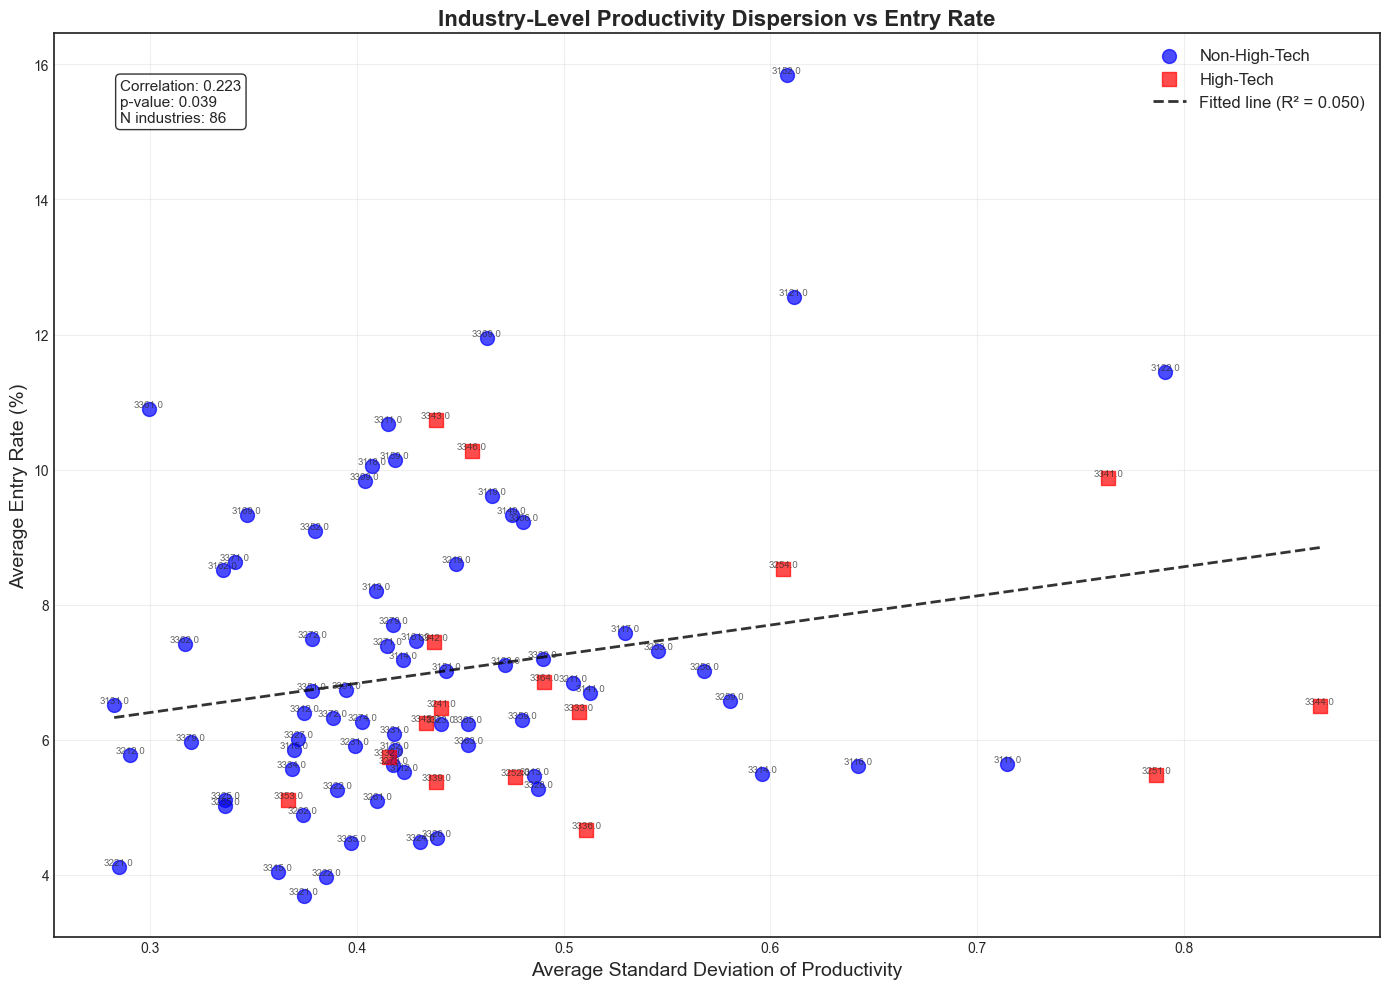

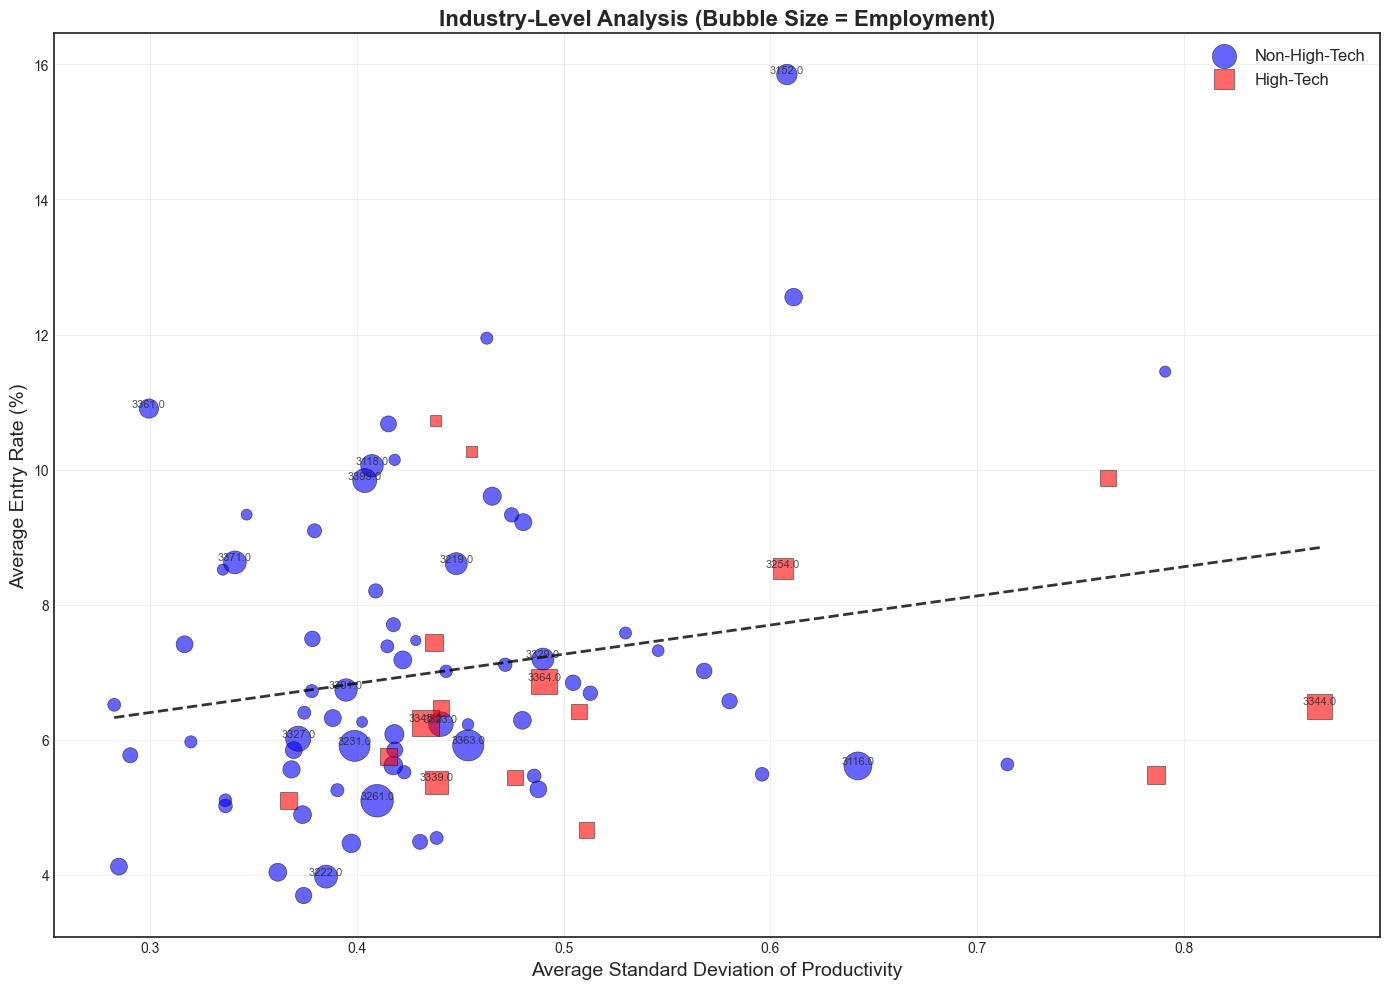

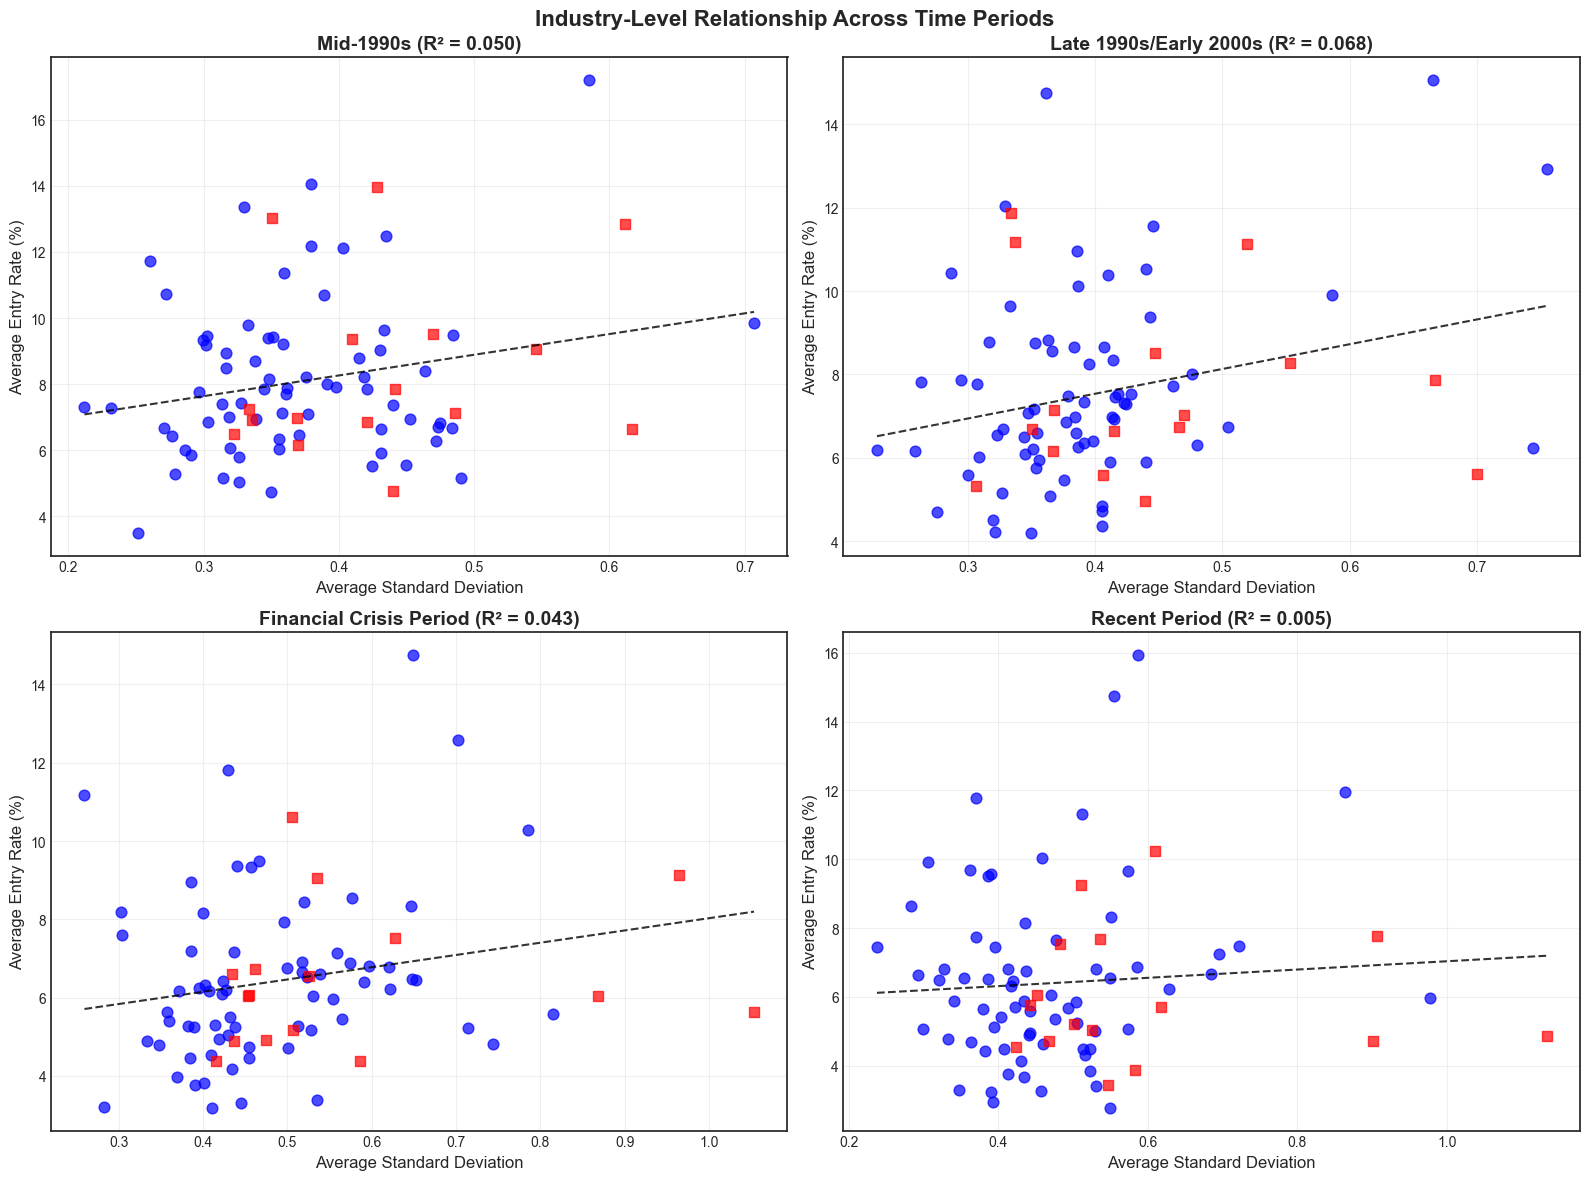


INDUSTRY RANKINGS

Highest Dispersion Industries:
 naics4       sd  estabs_entry_rate  hightech
   3344 0.865664           6.494536         1
   3122 0.790939          11.450429         0
   3251 0.786529           5.478107         1
   3341 0.763339           9.876036         1
   3111 0.714607           5.635679         0
   3116 0.642332           5.614500         0
   3121 0.611239          12.553714         0
   3152 0.607982          15.848750         0
   3254 0.606161           8.532500         1
   3314 0.595975           5.490536         0

Lowest Dispersion Industries:
 naics4       sd  estabs_entry_rate  hightech
   3371 0.341039           8.627071         0
   3255 0.336489           5.020821         0
   3325 0.336439           5.107071         0
   3162 0.335239           8.519679         0
   3379 0.319757           5.969536         0
   3362 0.316704           7.415036         0
   3361 0.299471          10.904107         0
   3212 0.290464           5.771750         

/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_11791/103069340.py:197: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_summary = industry_avg.groupby('dispersion_quartile').agg({


In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")

# 1. Create industry-level averages across all years
industry_avg = df_merged.groupby('naics4').agg({
    'sd': 'mean',
    'estabs_entry_rate': 'mean',
    'reallocation_rate': 'mean',
    'hightech': 'first',  # Get the hightech status
    'firms': 'mean',
    'emp': 'mean'
}).reset_index()

# Create the main scatter plot
fig, ax = plt.subplots(figsize=(14, 10))

# Separate high-tech and non-high-tech for different colors
hightech = industry_avg[industry_avg['hightech'] == 1]
nonhightech = industry_avg[industry_avg['hightech'] == 0]

# Plot non-high-tech industries
scatter1 = ax.scatter(nonhightech['sd'], nonhightech['estabs_entry_rate'], 
                     s=100, alpha=0.7, color='blue', label='Non-High-Tech')

# Plot high-tech industries
scatter2 = ax.scatter(hightech['sd'], hightech['estabs_entry_rate'], 
                     s=100, alpha=0.7, color='red', marker='s', label='High-Tech')

# Add regression line for all industries
slope, intercept, r_value, p_value, std_err = stats.linregress(
    industry_avg['sd'], industry_avg['estabs_entry_rate']
)
line_x = np.array([industry_avg['sd'].min(), industry_avg['sd'].max()])
line_y = slope * line_x + intercept
ax.plot(line_x, line_y, 'k--', linewidth=2, alpha=0.8, 
        label=f'Fitted line (R² = {r_value**2:.3f})')

# Add labels for each industry
for idx, row in industry_avg.iterrows():
    ax.annotate(row['naics4'], (row['sd'], row['estabs_entry_rate']), 
                fontsize=7, alpha=0.7, ha='center', va='bottom')

# Formatting
ax.set_xlabel('Average Standard Deviation of Productivity', fontsize=14)
ax.set_ylabel('Average Entry Rate (%)', fontsize=14)
ax.set_title('Industry-Level Productivity Dispersion vs Entry Rate', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3)

# Add text with statistics
textstr = f'Correlation: {r_value:.3f}\np-value: {p_value:.3f}\nN industries: {len(industry_avg)}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# 2. Create a more detailed plot with size representing employment
fig, ax = plt.subplots(figsize=(14, 10))

# Scale bubble sizes by employment
sizes = (industry_avg['emp'] / industry_avg['emp'].max()) * 500 + 50

# Create scatter plot with sized bubbles
for tech_status in [0, 1]:
    data = industry_avg[industry_avg['hightech'] == tech_status]
    sizes_subset = sizes[industry_avg['hightech'] == tech_status]
    
    color = 'red' if tech_status == 1 else 'blue'
    label = 'High-Tech' if tech_status == 1 else 'Non-High-Tech'
    marker = 's' if tech_status == 1 else 'o'
    
    ax.scatter(data['sd'], data['estabs_entry_rate'], 
              s=sizes_subset, alpha=0.6, color=color, 
              label=label, marker=marker, edgecolors='black', linewidth=0.5)

# Add regression line
ax.plot(line_x, line_y, 'k--', linewidth=2, alpha=0.8)

# Add labels for larger industries only (top 20 by employment)
top_industries = industry_avg.nlargest(20, 'emp')
for idx, row in top_industries.iterrows():
    ax.annotate(row['naics4'], (row['sd'], row['estabs_entry_rate']), 
                fontsize=8, alpha=0.8, ha='center', va='bottom')

ax.set_xlabel('Average Standard Deviation of Productivity', fontsize=14)
ax.set_ylabel('Average Entry Rate (%)', fontsize=14)
ax.set_title('Industry-Level Analysis (Bubble Size = Employment)', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Focus on specific time periods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define time periods
periods = [
    (1994, 1998, "Mid-1990s"),
    (1998, 2002, "Late 1990s/Early 2000s"),
    (2008, 2012, "Financial Crisis Period"),
    (2016, 2020, "Recent Period")
]

for idx, (start_year, end_year, period_name) in enumerate(periods):
    ax = axes[idx // 2, idx % 2]
    
    # Filter data for time period
    period_data = df_merged[(df_merged['window_end_year'] >= start_year) & 
                           (df_merged['window_end_year'] <= end_year)]
    
    # Calculate industry averages for this period
    period_avg = period_data.groupby('naics4').agg({
        'sd': 'mean',
        'estabs_entry_rate': 'mean',
        'hightech': 'first'
    }).reset_index()
    
    # Plot
    hightech = period_avg[period_avg['hightech'] == 1]
    nonhightech = period_avg[period_avg['hightech'] == 0]
    
    ax.scatter(nonhightech['sd'], nonhightech['estabs_entry_rate'], 
              s=60, alpha=0.7, color='blue')
    ax.scatter(hightech['sd'], hightech['estabs_entry_rate'], 
              s=60, alpha=0.7, color='red', marker='s')
    
    # Add regression line
    if len(period_avg) > 2:
        slope, intercept, r_value, _, _ = stats.linregress(
            period_avg['sd'], period_avg['estabs_entry_rate']
        )
        line_x = np.array([period_avg['sd'].min(), period_avg['sd'].max()])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, 'k--', linewidth=1.5, alpha=0.8)
        
        # Add R² to title
        ax.set_title(f'{period_name} (R² = {r_value**2:.3f})', fontsize=14, fontweight='bold')
    else:
        ax.set_title(period_name, fontsize=14, fontweight='bold')
    
    ax.set_xlabel('Average Standard Deviation', fontsize=12)
    ax.set_ylabel('Average Entry Rate (%)', fontsize=12)
    ax.grid(True, alpha=0.3)

plt.suptitle('Industry-Level Relationship Across Time Periods', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Table of top and bottom industries
print("\nINDUSTRY RANKINGS")
print("=" * 80)

# Sort by dispersion
industry_avg_sorted = industry_avg.sort_values('sd', ascending=False)

print("\nHighest Dispersion Industries:")
print(industry_avg_sorted[['naics4', 'sd', 'estabs_entry_rate', 'hightech']].head(10).to_string(index=False))

print("\nLowest Dispersion Industries:")
print(industry_avg_sorted[['naics4', 'sd', 'estabs_entry_rate', 'hightech']].tail(10).to_string(index=False))

# Sort by entry rate
industry_avg_sorted_entry = industry_avg.sort_values('estabs_entry_rate', ascending=False)

print("\nHighest Entry Rate Industries:")
print(industry_avg_sorted_entry[['naics4', 'sd', 'estabs_entry_rate', 'hightech']].head(10).to_string(index=False))

print("\nLowest Entry Rate Industries:")
print(industry_avg_sorted_entry[['naics4', 'sd', 'estabs_entry_rate', 'hightech']].tail(10).to_string(index=False))

# 5. Statistical summary
print("\n" + "=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)

# Correlation by high-tech status
for tech_status in [0, 1]:
    data = industry_avg[industry_avg['hightech'] == tech_status]
    if len(data) > 2:
        corr = data[['sd', 'estabs_entry_rate']].corr().iloc[0, 1]
        print(f"\n{'High-Tech' if tech_status == 1 else 'Non-High-Tech'} Industries:")
        print(f"  Correlation: {corr:.3f}")
        print(f"  N industries: {len(data)}")
        
# Industry characteristics by dispersion quartile
industry_avg['dispersion_quartile'] = pd.qcut(industry_avg['sd'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
quartile_summary = industry_avg.groupby('dispersion_quartile').agg({
    'estabs_entry_rate': 'mean',
    'reallocation_rate': 'mean',
    'emp': 'mean',
    'firms': 'mean'
})

print("\nCharacteristics by Dispersion Quartile:")
print(quartile_summary.round(2))

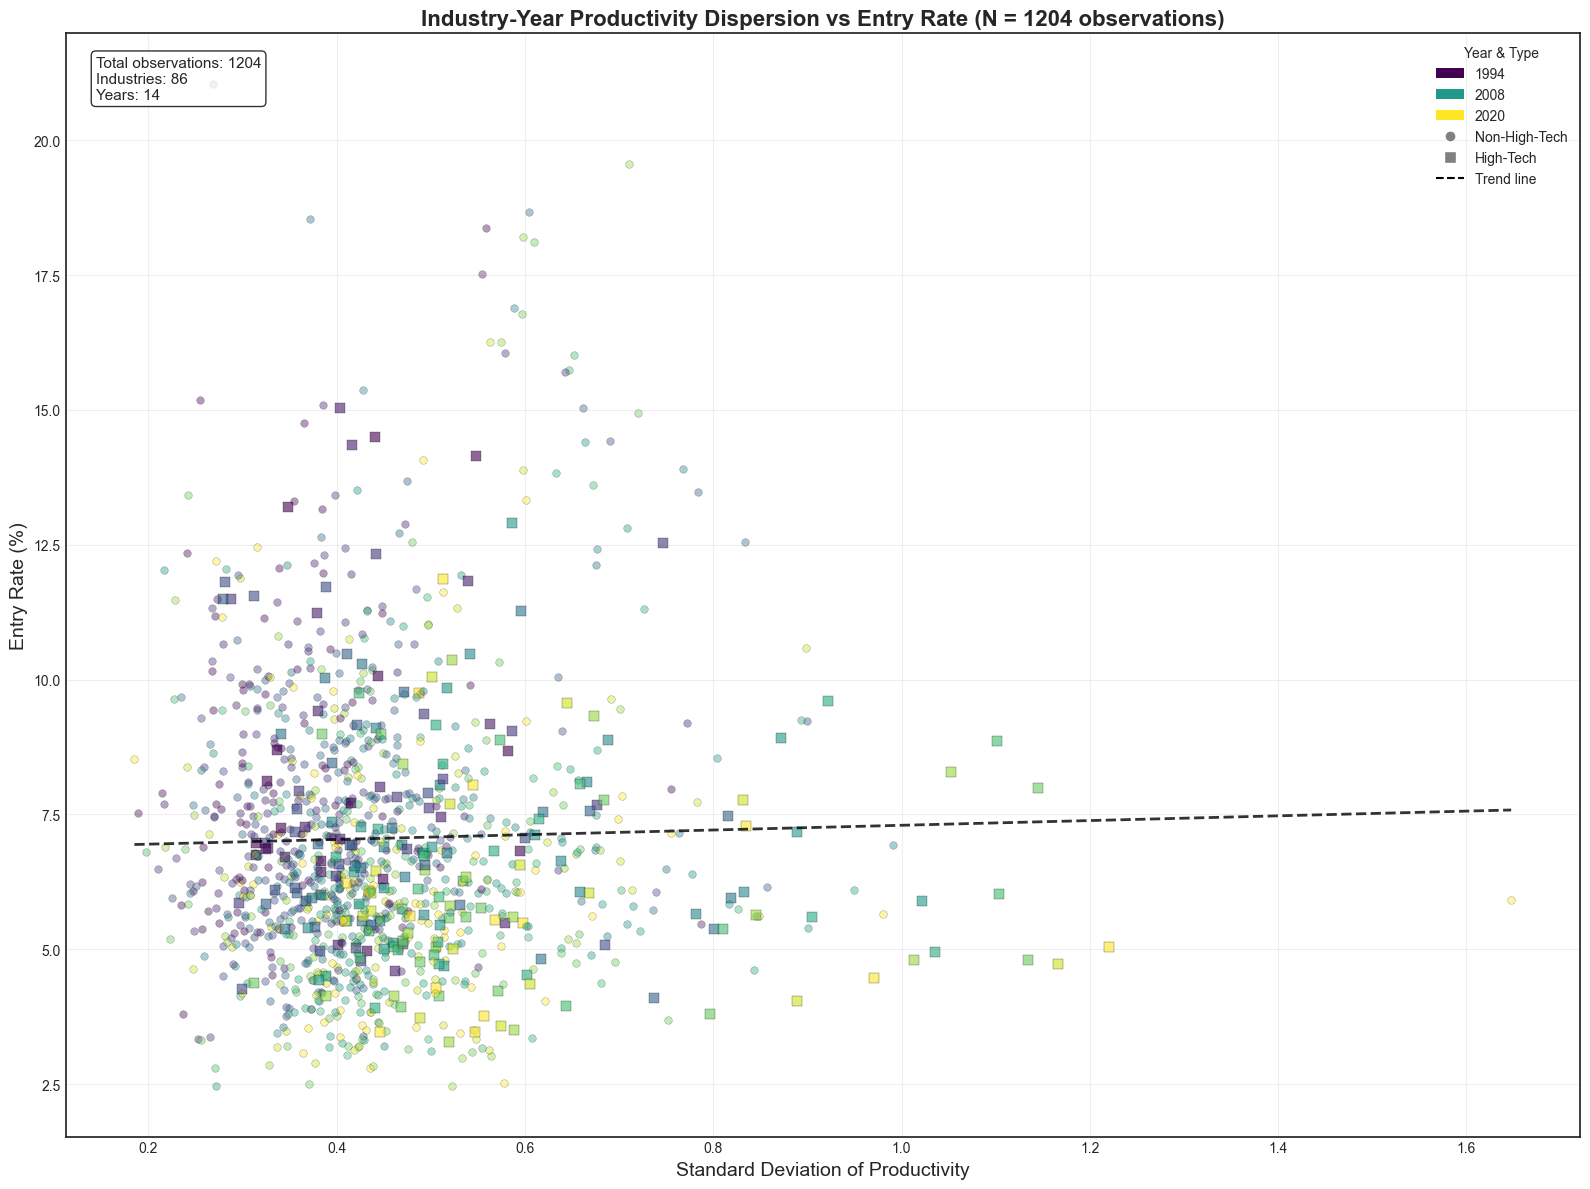

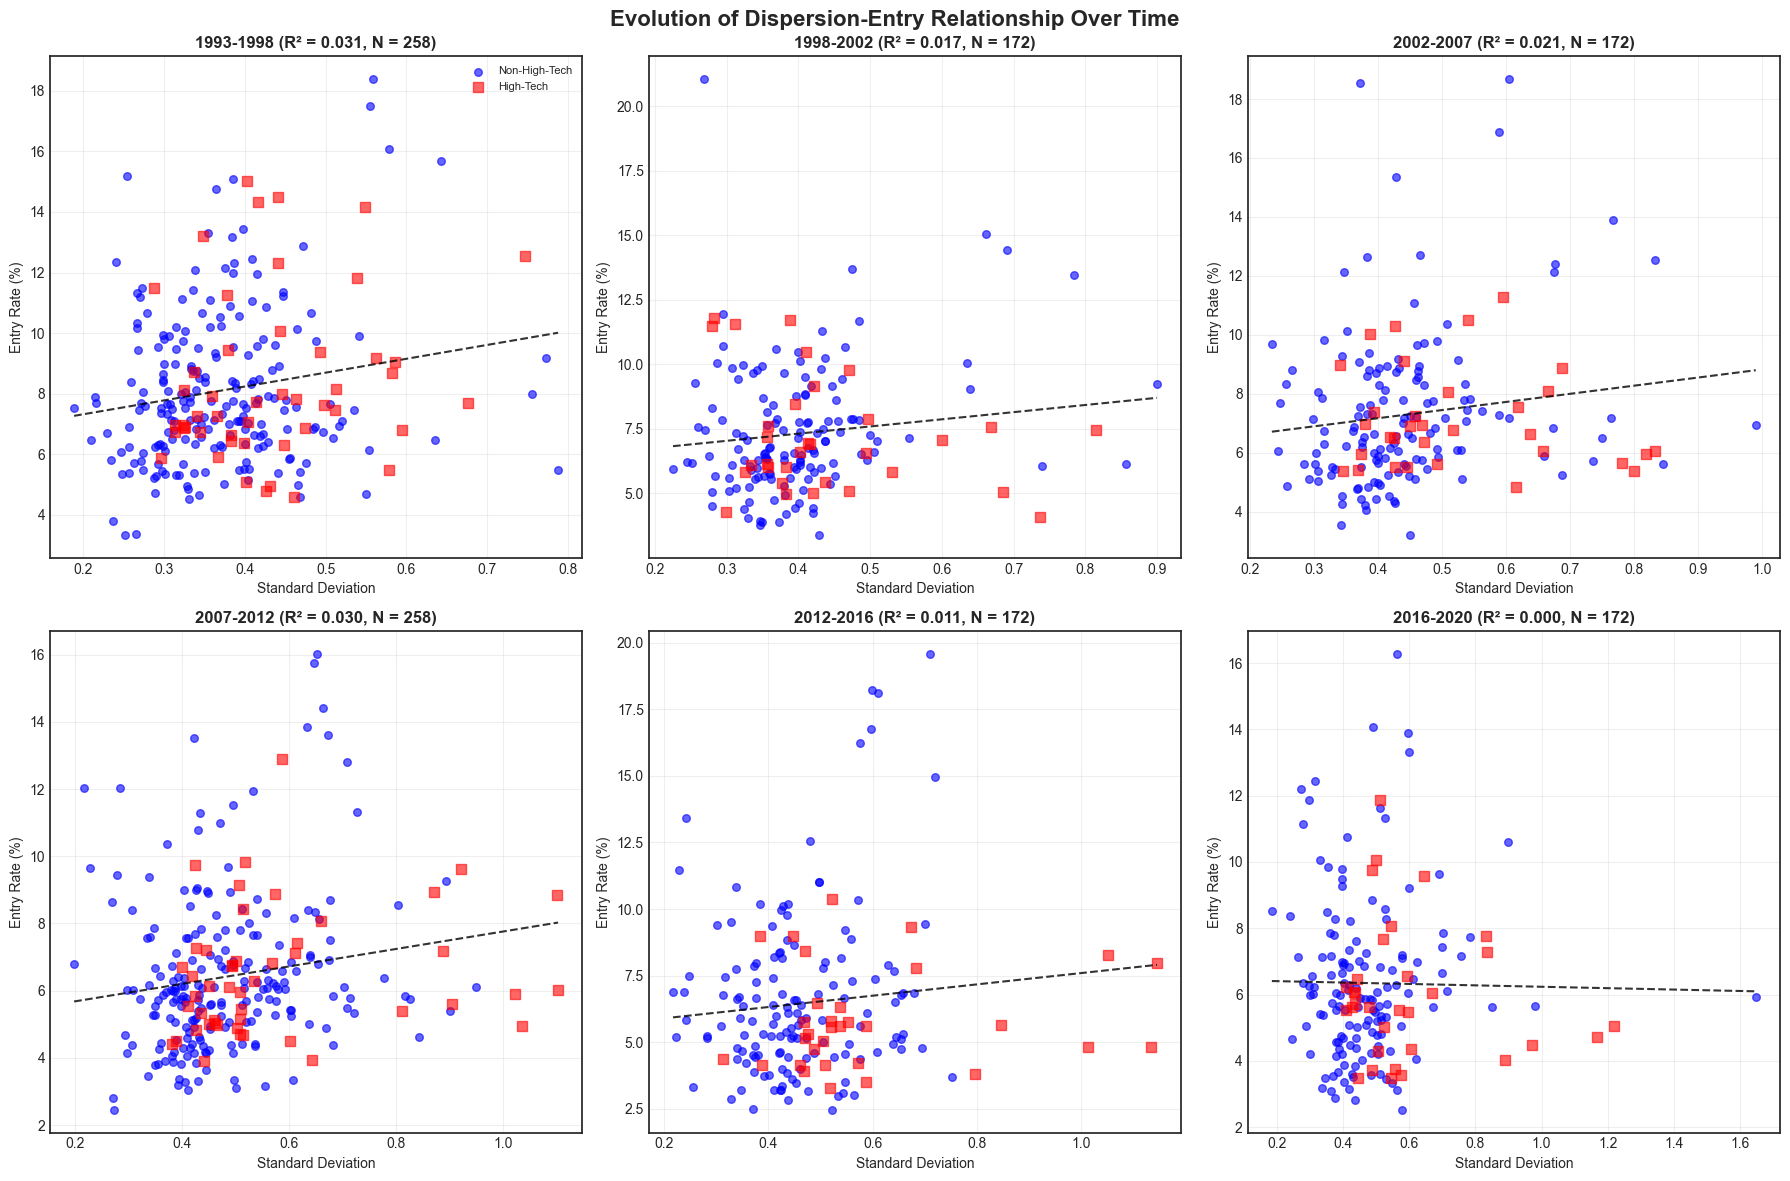

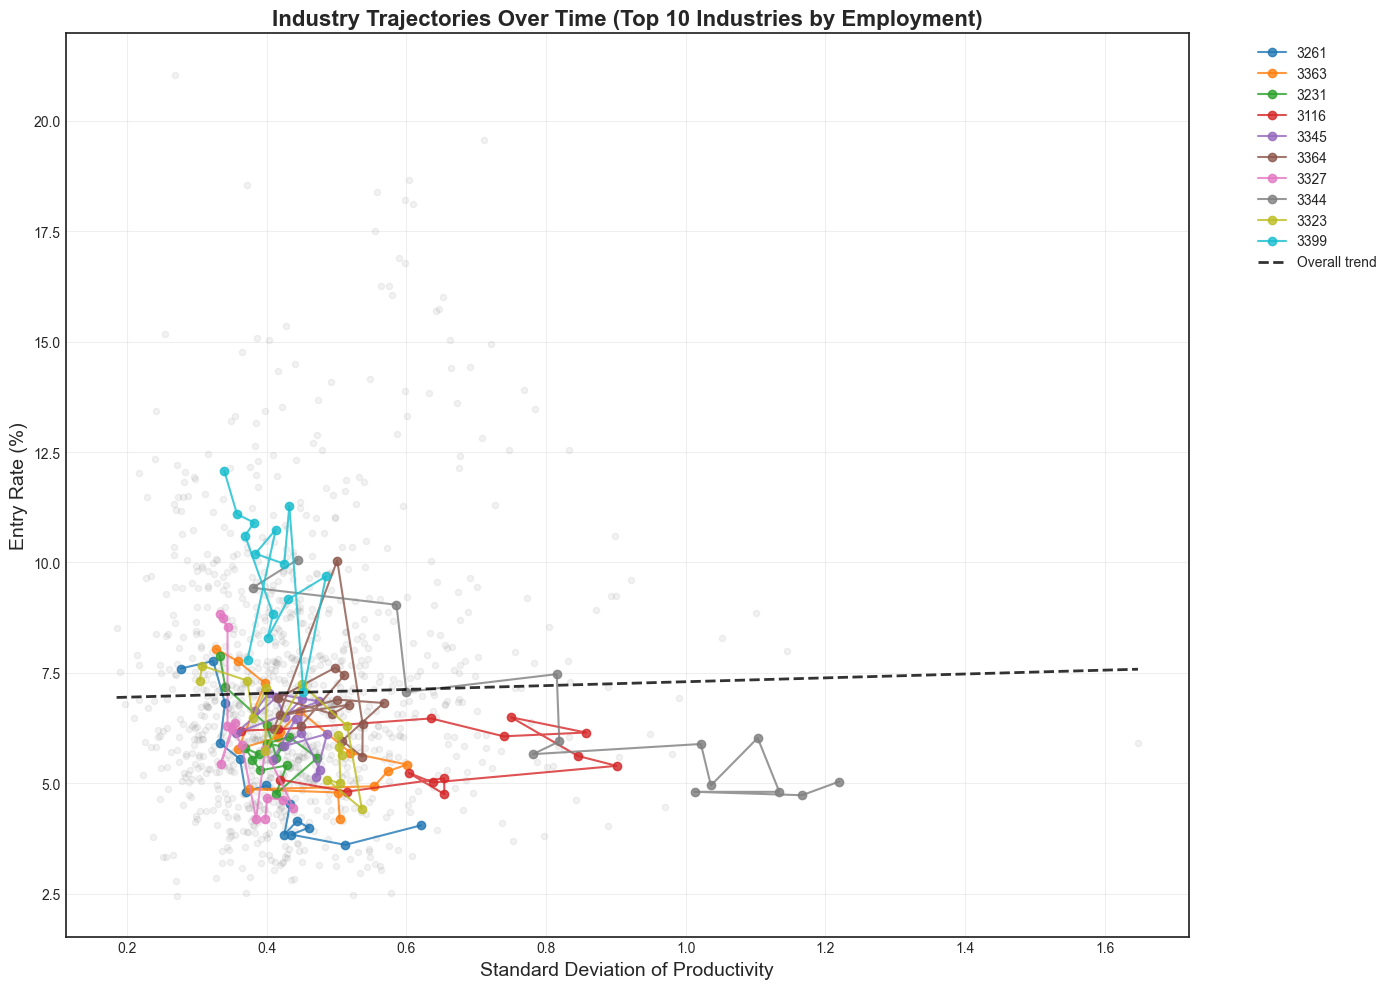

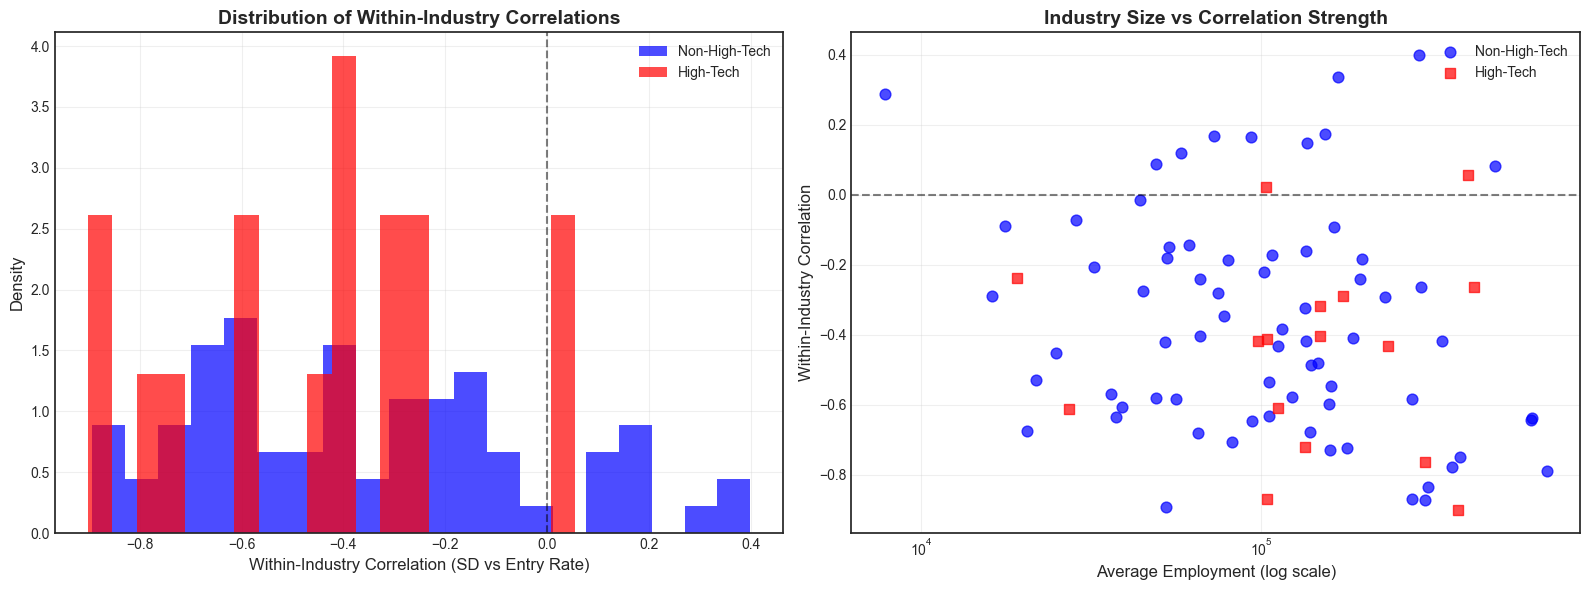


SUMMARY STATISTICS
Total observations: 1204
Number of industries: 86
Number of years: 14
Year range: 1994 - 2020

Overall correlation: 0.024

Correlation by decade:
  1990s: 0.176
  2000s: 0.119
  2010s: 0.122
  2020s: -0.083

Industries with strongest negative correlation:
 naics4  correlation  hightech  n_obs
   3344    -0.901707         1     14
   3326    -0.892905         0     14
   3371    -0.872194         0     14
   3252    -0.869781         1     14
   3219    -0.868933         0     14
   3222    -0.833959         0     14
   3261    -0.789477         0     14
   3323    -0.778896         0     14
   3339    -0.764356         1     14
   3327    -0.750414         0     14

Industries with positive correlation:
 naics4  correlation  hightech  n_obs
   3391     0.399381         0     14
   3119     0.337379         0     14
   3161     0.289437         0     14
   3121     0.175103         0     14
   3352     0.167454         0     14
   3324     0.163971         0     14
 

/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_11791/2484422942.py:221: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decade_corr = df_merged.groupby('decade').apply(


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib.patches import Patch

# Set style
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")

# 1. Full scatter plot with all industry-year observations
fig, ax = plt.subplots(figsize=(16, 12))

# Create color map for years
years = sorted(df_merged['window_end_year'].unique())
n_years = len(years)
colors = plt.cm.viridis(np.linspace(0, 1, n_years))
year_to_color = dict(zip(years, colors))

# Plot each industry-year observation
for idx, row in df_merged.iterrows():
    color = year_to_color[row['window_end_year']]
    marker = 's' if row['hightech'] == 1 else 'o'
    alpha = 0.6 if row['hightech'] == 1 else 0.4
    size = 50 if row['hightech'] == 1 else 30
    
    ax.scatter(row['sd'], row['estabs_entry_rate'], 
              color=color, marker=marker, alpha=alpha, s=size, 
              edgecolors='black', linewidth=0.3)

# Add overall regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_merged['sd'], df_merged['estabs_entry_rate']
)
line_x = np.array([df_merged['sd'].min(), df_merged['sd'].max()])
line_y = slope * line_x + intercept
ax.plot(line_x, line_y, 'k--', linewidth=2, alpha=0.8, 
        label=f'Overall trend (R² = {r_value**2:.3f}, p = {p_value:.3f})')

# Create custom legend
legend_elements = [
    Patch(facecolor=year_to_color[years[0]], label=f'{int(years[0])}'),
    Patch(facecolor=year_to_color[years[n_years//2]], label=f'{int(years[n_years//2])}'),
    Patch(facecolor=year_to_color[years[-1]], label=f'{int(years[-1])}'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=8, label='Non-High-Tech'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', 
               markersize=8, label='High-Tech'),
    plt.Line2D([0], [0], color='k', linestyle='--', label='Trend line')
]

ax.legend(handles=legend_elements, loc='upper right', title='Year & Type', fontsize=10)

ax.set_xlabel('Standard Deviation of Productivity', fontsize=14)
ax.set_ylabel('Entry Rate (%)', fontsize=14)
ax.set_title(f'Industry-Year Productivity Dispersion vs Entry Rate (N = {len(df_merged)} observations)', 
             fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add statistics box
textstr = f'Total observations: {len(df_merged)}\nIndustries: {df_merged["naics4"].nunique()}\nYears: {df_merged["window_end_year"].nunique()}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# 2. Separate panels for different time periods
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Create 6 time periods
year_bins = pd.qcut(df_merged['window_end_year'], 6, duplicates='drop')
periods = year_bins.cat.categories

for idx, period in enumerate(periods):
    ax = axes[idx]
    
    # Filter data for this period
    mask = year_bins == period
    period_data = df_merged[mask]
    
    # Separate by tech status
    hightech = period_data[period_data['hightech'] == 1]
    nonhightech = period_data[period_data['hightech'] == 0]
    
    # Plot
    ax.scatter(nonhightech['sd'], nonhightech['estabs_entry_rate'], 
              alpha=0.6, s=30, color='blue', label='Non-High-Tech')
    ax.scatter(hightech['sd'], hightech['estabs_entry_rate'], 
              alpha=0.6, s=50, color='red', marker='s', label='High-Tech')
    
    # Add regression line for this period
    if len(period_data) > 10:
        slope, intercept, r_value, _, _ = stats.linregress(
            period_data['sd'], period_data['estabs_entry_rate']
        )
        line_x = np.array([period_data['sd'].min(), period_data['sd'].max()])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, 'k--', linewidth=1.5, alpha=0.8)
        
        # Add period info to title
        start_year = int(period.left)
        end_year = int(period.right)
        ax.set_title(f'{start_year}-{end_year} (R² = {r_value**2:.3f}, N = {len(period_data)})', 
                    fontsize=12, fontweight='bold')
    
    ax.set_xlabel('Standard Deviation', fontsize=10)
    ax.set_ylabel('Entry Rate (%)', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.legend(fontsize=8)

plt.suptitle('Evolution of Dispersion-Entry Relationship Over Time', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Industry-specific trajectories
fig, ax = plt.subplots(figsize=(14, 10))

# Select a subset of industries to highlight
# Get top 10 industries by average employment
top_industries = df_merged.groupby('naics4')['emp'].mean().nlargest(10).index

# Plot all points in gray
ax.scatter(df_merged['sd'], df_merged['estabs_entry_rate'], 
          alpha=0.1, s=20, color='gray')

# Highlight and connect points for selected industries
colors_ind = plt.cm.tab10(np.linspace(0, 1, 10))
for i, industry in enumerate(top_industries):
    industry_data = df_merged[df_merged['naics4'] == industry].sort_values('window_end_year')
    
    # Plot trajectory
    ax.plot(industry_data['sd'], industry_data['estabs_entry_rate'], 
           '-o', markersize=6, linewidth=1.5, alpha=0.8, 
           color=colors_ind[i], label=f'{industry}')

# Add overall trend
slope, intercept, r_value, _, _ = stats.linregress(df_merged['sd'], df_merged['estabs_entry_rate'])
line_x = np.array([df_merged['sd'].min(), df_merged['sd'].max()])
line_y = slope * line_x + intercept
ax.plot(line_x, line_y, 'k--', linewidth=2, alpha=0.8, label='Overall trend')

ax.set_xlabel('Standard Deviation of Productivity', fontsize=14)
ax.set_ylabel('Entry Rate (%)', fontsize=14)
ax.set_title('Industry Trajectories Over Time (Top 10 Industries by Employment)', 
             fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Heat map showing correlation by industry
industry_correlations = []
for industry in df_merged['naics4'].unique():
    industry_data = df_merged[df_merged['naics4'] == industry]
    if len(industry_data) >= 5:  # Need at least 5 observations for meaningful correlation
        corr = industry_data[['sd', 'estabs_entry_rate']].corr().iloc[0, 1]
        tech_status = industry_data['hightech'].iloc[0]
        avg_emp = industry_data['emp'].mean()
        industry_correlations.append({
            'naics4': industry,
            'correlation': corr,
            'hightech': tech_status,
            'avg_emp': avg_emp,
            'n_obs': len(industry_data)
        })

corr_df = pd.DataFrame(industry_correlations)

# Plot distribution of correlations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of correlations
ax1.hist(corr_df[corr_df['hightech']==0]['correlation'], bins=20, alpha=0.7, 
         color='blue', label='Non-High-Tech', density=True)
ax1.hist(corr_df[corr_df['hightech']==1]['correlation'], bins=20, alpha=0.7, 
         color='red', label='High-Tech', density=True)
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('Within-Industry Correlation (SD vs Entry Rate)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Distribution of Within-Industry Correlations', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter of correlation vs industry size
ax2.scatter(corr_df[corr_df['hightech']==0]['avg_emp'], 
           corr_df[corr_df['hightech']==0]['correlation'],
           alpha=0.7, s=60, color='blue', label='Non-High-Tech')
ax2.scatter(corr_df[corr_df['hightech']==1]['avg_emp'], 
           corr_df[corr_df['hightech']==1]['correlation'],
           alpha=0.7, s=60, color='red', marker='s', label='High-Tech')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Average Employment (log scale)', fontsize=12)
ax2.set_ylabel('Within-Industry Correlation', fontsize=12)
ax2.set_title('Industry Size vs Correlation Strength', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Summary statistics
print("\nSUMMARY STATISTICS")
print("=" * 80)
print(f"Total observations: {len(df_merged)}")
print(f"Number of industries: {df_merged['naics4'].nunique()}")
print(f"Number of years: {df_merged['window_end_year'].nunique()}")
print(f"Year range: {df_merged['window_end_year'].min():.0f} - {df_merged['window_end_year'].max():.0f}")

print("\nOverall correlation: {:.3f}".format(df_merged[['sd', 'estabs_entry_rate']].corr().iloc[0, 1]))

# By decade
df_merged['decade'] = (df_merged['window_end_year'] // 10) * 10
decade_corr = df_merged.groupby('decade').apply(
    lambda x: x[['sd', 'estabs_entry_rate']].corr().iloc[0, 1] if len(x) > 10 else np.nan
)
print("\nCorrelation by decade:")
for decade, corr in decade_corr.items():
    if not np.isnan(corr):
        print(f"  {int(decade)}s: {corr:.3f}")

# Industries with strongest negative correlation
print("\nIndustries with strongest negative correlation:")
strongest_negative = corr_df.nsmallest(10, 'correlation')[['naics4', 'correlation', 'hightech', 'n_obs']]
print(strongest_negative.to_string(index=False))

# Industries with positive correlation
print("\nIndustries with positive correlation:")
positive_corr = corr_df[corr_df['correlation'] > 0].nlargest(10, 'correlation')[['naics4', 'correlation', 'hightech', 'n_obs']]
print(positive_corr.to_string(index=False))

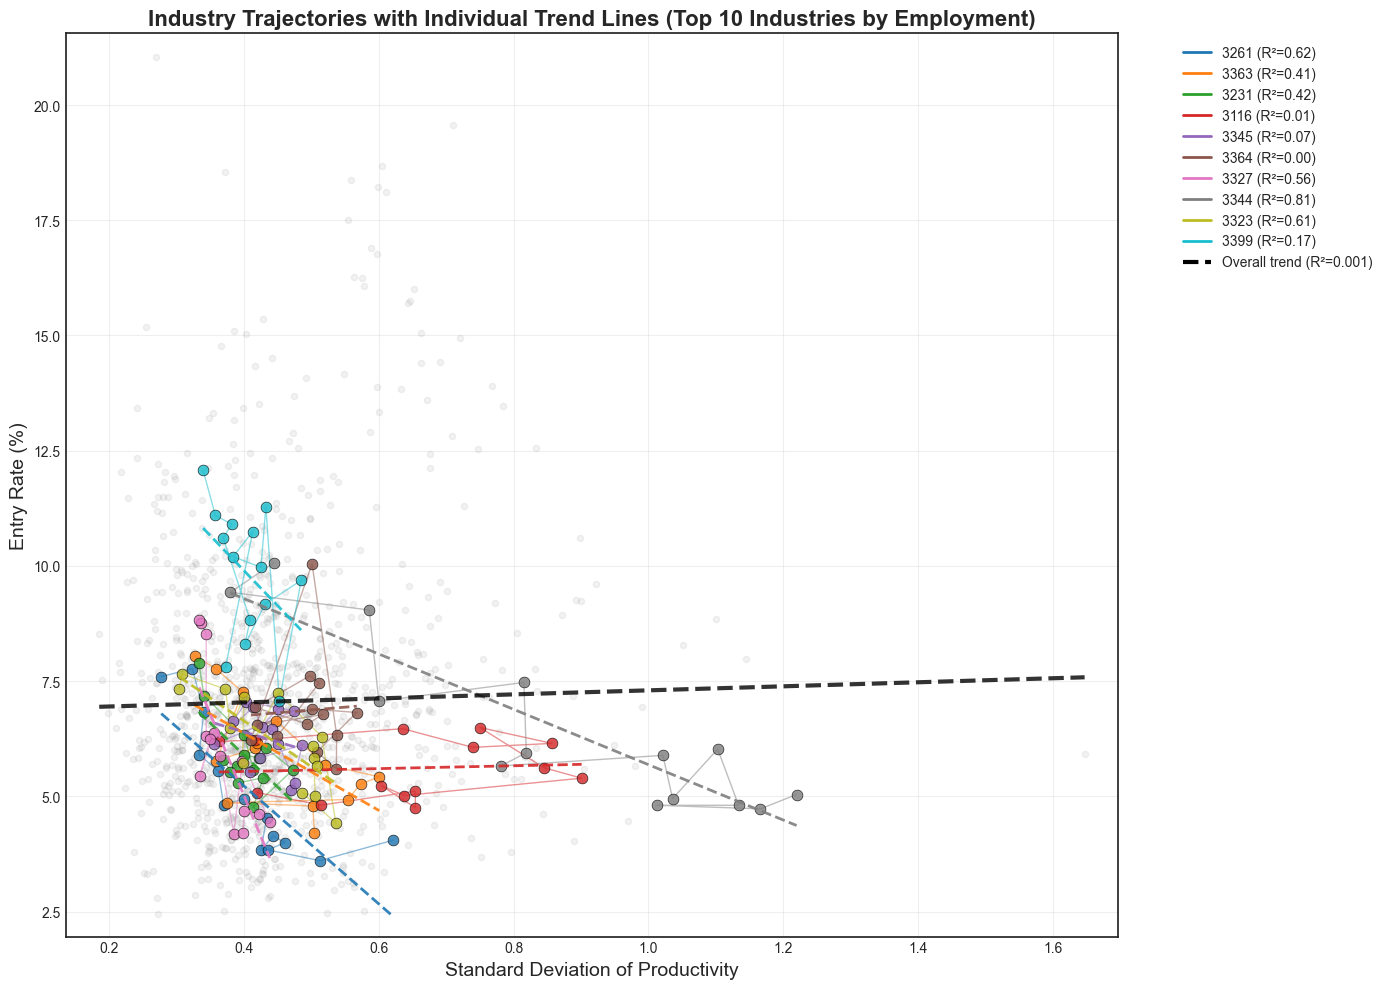


TREND ANALYSIS FOR TOP 10 INDUSTRIES
Industry   Slope        R²       p-value    Direction       Avg Emp   
--------------------------------------------------------------------------------
3261          -12.7912   0.623     0.001 Negative           690925
3363           -8.3657   0.407     0.014 Negative           625094
3231          -13.8939   0.415     0.013 Negative           619855
3116            0.3088   0.007     0.778 Positive           487342
3345           -4.3280   0.070     0.361 Negative           423164
3364            1.2157   0.003     0.850 Positive           404616
3327          -35.4008   0.563     0.002 Negative           383451
3344           -6.0026   0.813     0.000 Negative           378227
3323           -9.9311   0.607     0.001 Negative           364213
3399          -15.2158   0.175     0.137 Negative           340748
--------------------------------------------------------------------------------
OVERALL         0.4377   0.001    <0.001 Negative        Al

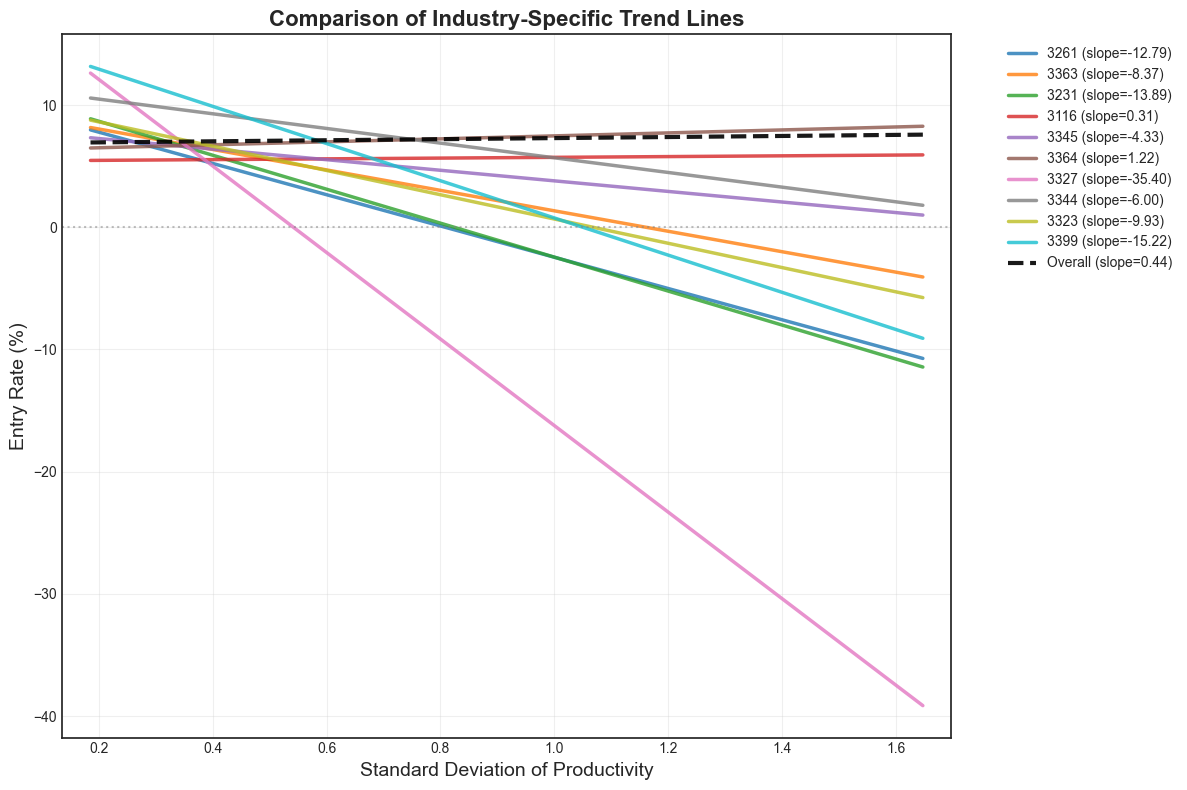


COMPARISON OF HIGH-TECH VS NON-HIGH-TECH INDUSTRIES
High-tech industries: 3 with avg slope: -3.0383
Non-high-tech industries: 7 with avg slope: -13.6128


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")

# Create the figure
fig, ax = plt.subplots(figsize=(14, 10))

# Get top 10 industries by average employment
top_industries = df_merged.groupby('naics4')['emp'].mean().nlargest(10).index

# Plot all points in light gray as background
ax.scatter(df_merged['sd'], df_merged['estabs_entry_rate'], 
          alpha=0.1, s=20, color='gray', zorder=1)

# Colors for the industries
colors_ind = plt.cm.tab10(np.linspace(0, 1, 10))

# Store legend info
legend_elements = []

# Plot each top industry with its own trend line
for i, industry in enumerate(top_industries):
    industry_data = df_merged[df_merged['naics4'] == industry].sort_values('window_end_year')
    
    # Plot the trajectory points
    scatter = ax.scatter(industry_data['sd'], industry_data['estabs_entry_rate'], 
                        s=60, alpha=0.8, color=colors_ind[i], 
                        edgecolors='black', linewidth=0.5, zorder=3)
    
    # Connect points chronologically
    ax.plot(industry_data['sd'], industry_data['estabs_entry_rate'], 
           '-', linewidth=1, alpha=0.5, color=colors_ind[i], zorder=2)
    
    # Calculate and plot individual trend line if enough data points
    if len(industry_data) >= 5:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            industry_data['sd'], industry_data['estabs_entry_rate']
        )
        
        # Create trend line
        x_range = np.array([industry_data['sd'].min(), industry_data['sd'].max()])
        y_trend = slope * x_range + intercept
        
        # Plot trend line
        ax.plot(x_range, y_trend, '--', linewidth=2, color=colors_ind[i], 
               alpha=0.9, zorder=4)
        
        # Create legend entry with R²
        legend_elements.append(plt.Line2D([0], [0], color=colors_ind[i], linewidth=2,
                                         label=f'{industry} (R²={r_value**2:.2f})'))
    else:
        # Just add to legend without R²
        legend_elements.append(plt.Line2D([0], [0], color=colors_ind[i], linewidth=2,
                                         label=f'{industry}'))

# Add overall trend line for all data
slope_all, intercept_all, r_value_all, _, _ = stats.linregress(
    df_merged['sd'], df_merged['estabs_entry_rate']
)
x_all = np.array([df_merged['sd'].min(), df_merged['sd'].max()])
y_all = slope_all * x_all + intercept_all
ax.plot(x_all, y_all, 'k--', linewidth=3, alpha=0.8, zorder=5,
        label=f'Overall trend (R²={r_value_all**2:.3f})')

# Add overall trend to legend
legend_elements.append(plt.Line2D([0], [0], color='k', linestyle='--', linewidth=3,
                                 label=f'Overall trend (R²={r_value_all**2:.3f})'))

# Formatting
ax.set_xlabel('Standard Deviation of Productivity', fontsize=14)
ax.set_ylabel('Entry Rate (%)', fontsize=14)
ax.set_title('Industry Trajectories with Individual Trend Lines (Top 10 Industries by Employment)', 
             fontsize=16, fontweight='bold')
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

# Set axis limits with some padding
ax.set_xlim(df_merged['sd'].min() - 0.05, df_merged['sd'].max() + 0.05)
ax.set_ylim(df_merged['estabs_entry_rate'].min() - 0.5, df_merged['estabs_entry_rate'].max() + 0.5)

plt.tight_layout()
plt.show()

# Create a summary table of the trends
print("\nTREND ANALYSIS FOR TOP 10 INDUSTRIES")
print("=" * 80)
print(f"{'Industry':<10} {'Slope':<12} {'R²':<8} {'p-value':<10} {'Direction':<15} {'Avg Emp':<10}")
print("-" * 80)

trend_data = []
for industry in top_industries:
    industry_data = df_merged[df_merged['naics4'] == industry]
    if len(industry_data) >= 5:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            industry_data['sd'], industry_data['estabs_entry_rate']
        )
        direction = "Negative" if slope < 0 else "Positive"
        avg_emp = industry_data['emp'].mean()
        
        print(f"{industry:<10} {slope:>11.4f} {r_value**2:>7.3f} {p_value:>9.3f} {direction:<15} {avg_emp:>9.0f}")
        
        trend_data.append({
            'naics4': industry,
            'slope': slope,
            'r_squared': r_value**2,
            'p_value': p_value,
            'direction': direction,
            'avg_emp': avg_emp,
            'n_obs': len(industry_data)
        })

# Overall statistics
print("-" * 80)
print(f"{'OVERALL':<10} {slope_all:>11.4f} {r_value_all**2:>7.3f} {'<0.001':>9} {'Negative':<15} {'All':<10}")

# Create a second plot showing just the trend lines without the data points
fig2, ax2 = plt.subplots(figsize=(12, 8))

# Plot trend lines only
for i, industry in enumerate(top_industries):
    industry_data = df_merged[df_merged['naics4'] == industry]
    
    if len(industry_data) >= 5:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            industry_data['sd'], industry_data['estabs_entry_rate']
        )
        
        # Create extended trend line
        x_min = df_merged['sd'].min()
        x_max = df_merged['sd'].max()
        x_range = np.linspace(x_min, x_max, 100)
        y_trend = slope * x_range + intercept
        
        # Plot trend line
        ax2.plot(x_range, y_trend, linewidth=2.5, color=colors_ind[i], 
                alpha=0.8, label=f'{industry} (slope={slope:.2f})')

# Add overall trend
x_range_all = np.linspace(df_merged['sd'].min(), df_merged['sd'].max(), 100)
y_all = slope_all * x_range_all + intercept_all
ax2.plot(x_range_all, y_all, 'k--', linewidth=3, alpha=0.9,
         label=f'Overall (slope={slope_all:.2f})')

# Add zero line for reference
ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
ax2.axvline(x=0, color='gray', linestyle=':', alpha=0.5)

ax2.set_xlabel('Standard Deviation of Productivity', fontsize=14)
ax2.set_ylabel('Entry Rate (%)', fontsize=14)
ax2.set_title('Comparison of Industry-Specific Trend Lines', fontsize=16, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(df_merged['sd'].min() - 0.05, df_merged['sd'].max() + 0.05)

plt.tight_layout()
plt.show()

# Additional analysis: test if slopes differ by high-tech status
print("\n" + "=" * 80)
print("COMPARISON OF HIGH-TECH VS NON-HIGH-TECH INDUSTRIES")
print("=" * 80)

hightech_slopes = []
nonhightech_slopes = []

for industry in top_industries:
    industry_data = df_merged[df_merged['naics4'] == industry]
    if len(industry_data) >= 5:
        slope, _, _, _, _ = stats.linregress(
            industry_data['sd'], industry_data['estabs_entry_rate']
        )
        if industry_data['hightech'].iloc[0] == 1:
            hightech_slopes.append(slope)
        else:
            nonhightech_slopes.append(slope)

if hightech_slopes and nonhightech_slopes:
    print(f"High-tech industries: {len(hightech_slopes)} with avg slope: {np.mean(hightech_slopes):.4f}")
    print(f"Non-high-tech industries: {len(nonhightech_slopes)} with avg slope: {np.mean(nonhightech_slopes):.4f}")
else:
    print("Not enough industries in each category for comparison")

In [79]:
df_merged.columns

Index(['naics4', 'window_end_year', 'window_id', 'sd', 'd7525', 'd9010',
       'd9990', 'd1001', 'sd*', 'd7525*', 'd9010*', 'd9990*', 'd1001*',
       'firms', 'estabs', 'emp', 'denom', 'estabs_entry', 'estabs_exit',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
       'estabs_entry_rate', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'net_job_creation', 'job_creation_rate', 'job_creation_rate_births',
       'job_destruction_rate', 'job_destruction_rate_deaths',
       'net_job_creation_rate', 'reallocation_rate', 'iqr_growth_weighted',
       'd9010_growth_weighted', 'estabs_entry_rate_lag1',
       'estabs_entry_rate_lag2', 'estabs_entry_rate_lag3', 'entry_lag1',
       'entry_lag2', 'entry_lag3', 'naics4_int', 'hightech',
       'entry_lag1_x_hightech', 'entry_lag2_x_hightech',
       'entry_lag3_x_hightech', 'pct_high_growth_emp'

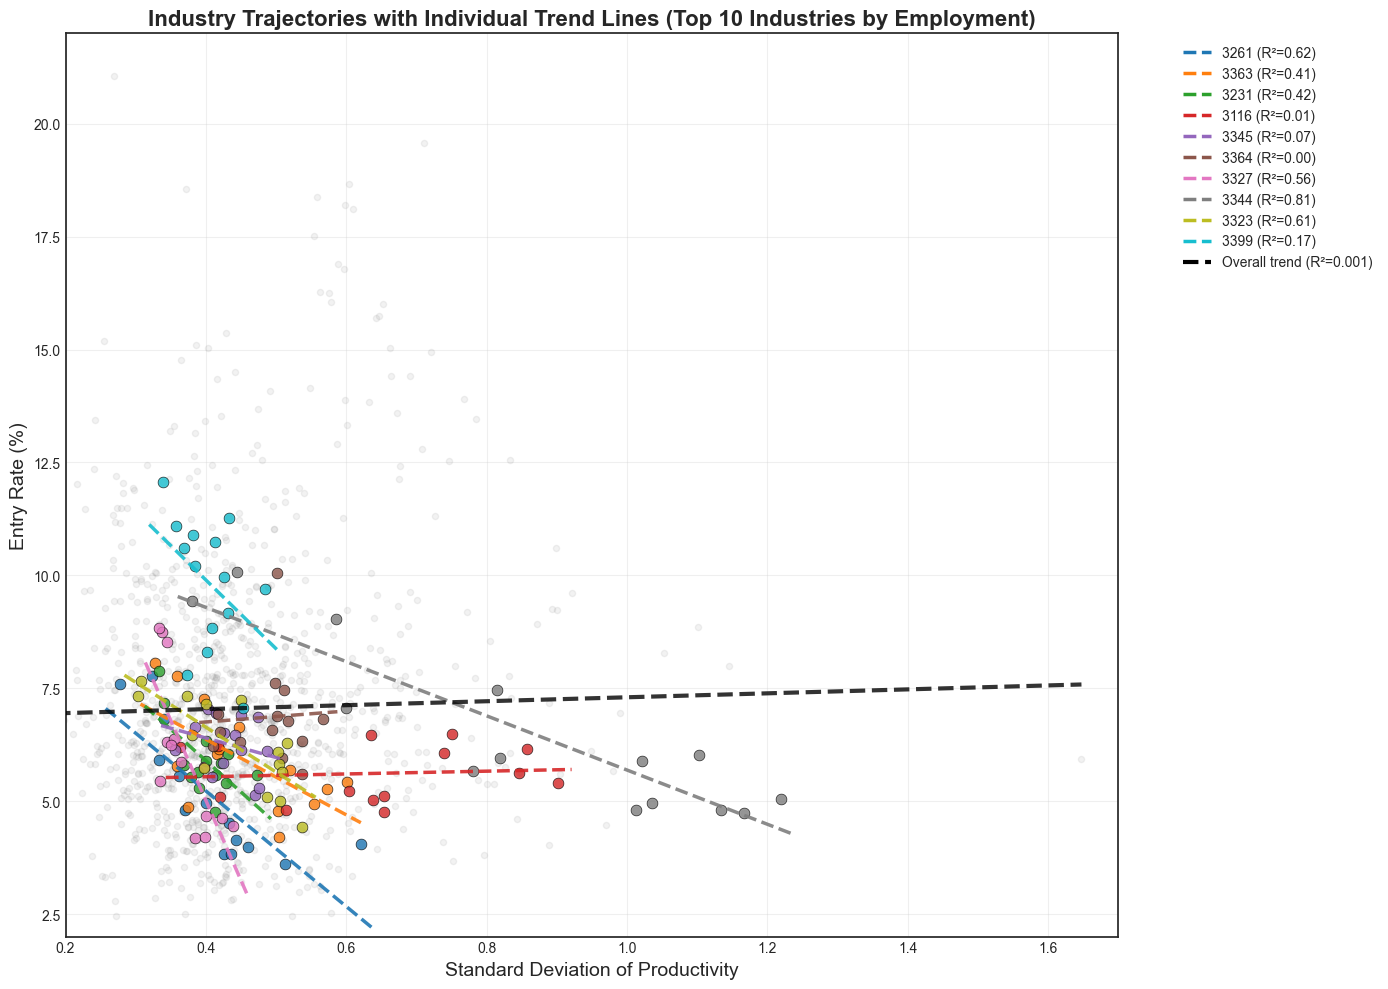

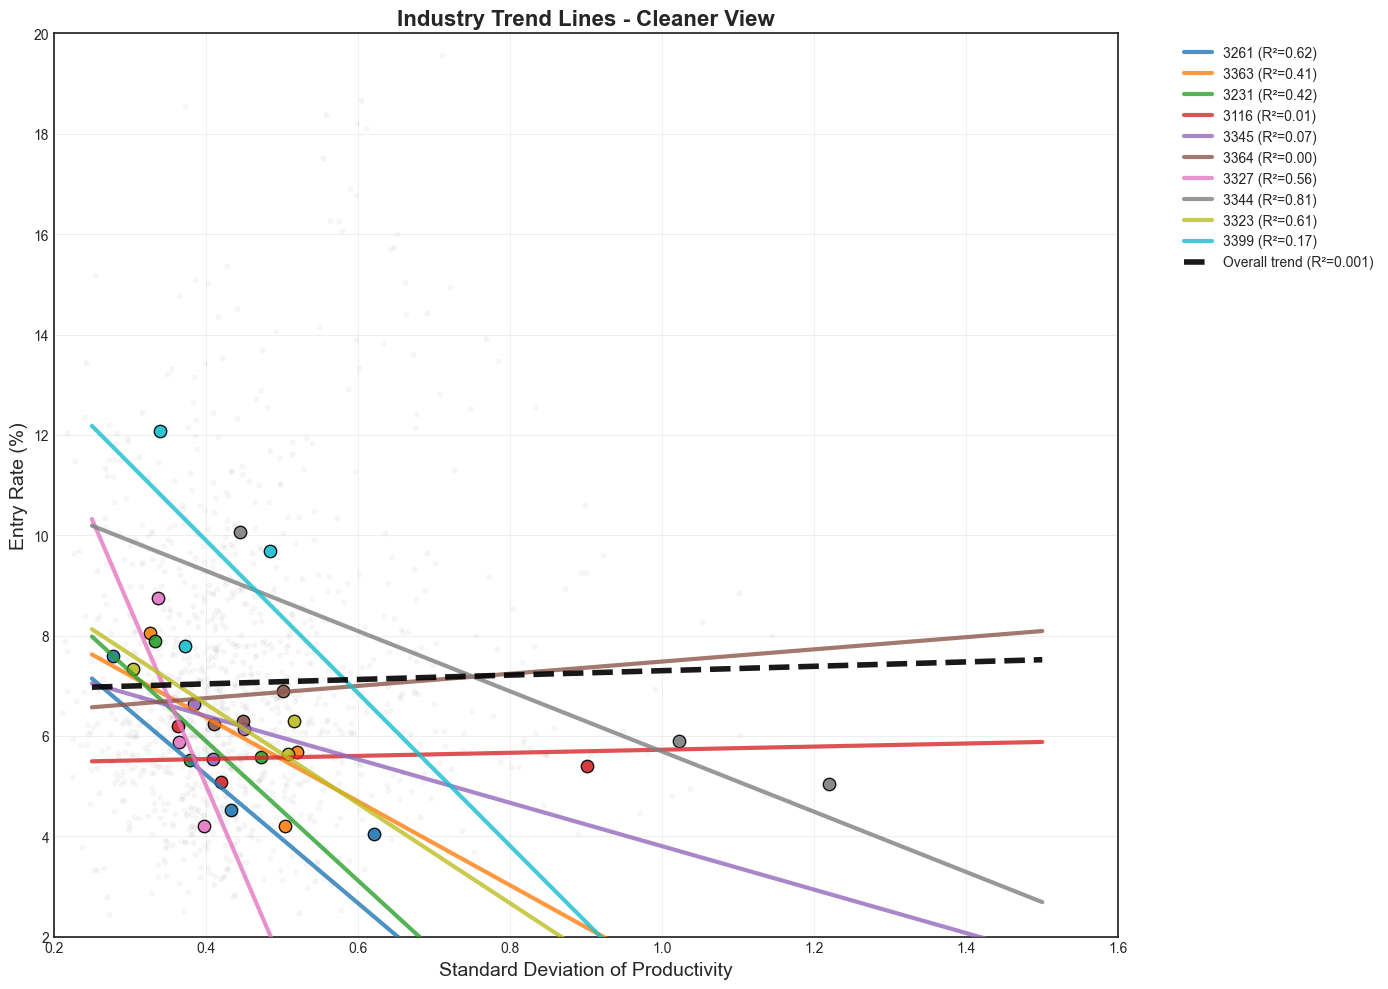


SLOPE ANALYSIS FOR TOP 10 INDUSTRIES
Industry   Slope        Intercept    R²       Interpretation                
--------------------------------------------------------------------------------
3261          -12.7912     10.3409   0.623 Strong negative relationship  
3363           -8.3657      9.7148   0.407 Strong negative relationship  
3231          -13.8939     11.4535   0.415 Strong negative relationship  
3116            0.3088      5.4161   0.007 Near zero relationship        
3345           -4.3280      8.1291   0.070 Moderate negative relationship
3364            1.2157      6.2663   0.003 Positive relationship         
3327          -35.4008     19.1741   0.563 Strong negative relationship  
3344           -6.0026     11.6908   0.813 Strong negative relationship  
3323           -9.9311     10.6092   0.607 Strong negative relationship  
3399          -15.2158     15.9825   0.175 Strong negative relationship  
----------------------------------------------------------------

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")

# Create the figure
fig, ax = plt.subplots(figsize=(14, 10))

# Get top 10 industries by average employment
top_industries = df_merged.groupby('naics4')['emp'].mean().nlargest(10).index

# Plot all points in light gray as background
ax.scatter(df_merged['sd'], df_merged['estabs_entry_rate'], 
          alpha=0.1, s=20, color='gray', zorder=1)

# Colors for the industries
colors_ind = plt.cm.tab10(np.linspace(0, 1, 10))

# Store legend info
legend_elements = []

# Plot each top industry with its points and trend line
for i, industry in enumerate(top_industries):
    industry_data = df_merged[df_merged['naics4'] == industry].sort_values('window_end_year')
    
    # Plot the data points
    ax.scatter(industry_data['sd'], industry_data['estabs_entry_rate'], 
              s=60, alpha=0.8, color=colors_ind[i], 
              edgecolors='black', linewidth=0.5, zorder=3)
    
    # Calculate and plot trend line if enough data points
    if len(industry_data) >= 5:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            industry_data['sd'], industry_data['estabs_entry_rate']
        )
        
        # Create trend line across full range for better visibility
        x_min = industry_data['sd'].min() - 0.02
        x_max = industry_data['sd'].max() + 0.02
        x_trend = np.linspace(x_min, x_max, 100)
        y_trend = slope * x_trend + intercept
        
        # Plot trend line
        ax.plot(x_trend, y_trend, '--', linewidth=2.5, color=colors_ind[i], 
               alpha=0.9, zorder=4)
        
        # Create legend entry with R²
        legend_elements.append(plt.Line2D([0], [0], color=colors_ind[i], linewidth=2.5, linestyle='--',
                                         label=f'{industry} (R²={r_value**2:.2f})'))

# Add overall trend line for all data
slope_all, intercept_all, r_value_all, _, _ = stats.linregress(
    df_merged['sd'], df_merged['estabs_entry_rate']
)
x_all = np.linspace(df_merged['sd'].min(), df_merged['sd'].max(), 100)
y_all = slope_all * x_all + intercept_all
ax.plot(x_all, y_all, 'k--', linewidth=3, alpha=0.8, zorder=5)

# Add overall trend to legend
legend_elements.append(plt.Line2D([0], [0], color='k', linestyle='--', linewidth=3,
                                 label=f'Overall trend (R²={r_value_all**2:.3f})'))

# Formatting
ax.set_xlabel('Standard Deviation of Productivity', fontsize=14)
ax.set_ylabel('Entry Rate (%)', fontsize=14)
ax.set_title('Industry Trajectories with Individual Trend Lines (Top 10 Industries by Employment)', 
             fontsize=16, fontweight='bold')
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

# Set axis limits with some padding
ax.set_xlim(0.2, 1.7)
ax.set_ylim(2, 22)

plt.tight_layout()
plt.show()

# Create a cleaner version with just trend lines and minimal points
fig2, ax2 = plt.subplots(figsize=(14, 10))

# Plot background points more subtly
ax2.scatter(df_merged['sd'], df_merged['estabs_entry_rate'], 
           alpha=0.05, s=10, color='gray', zorder=1)

# Plot each industry's trend line with a few key points
for i, industry in enumerate(top_industries):
    industry_data = df_merged[df_merged['naics4'] == industry]
    
    if len(industry_data) >= 5:
        # Calculate trend
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            industry_data['sd'], industry_data['estabs_entry_rate']
        )
        
        # Plot just first, middle, and last points
        n_points = len(industry_data)
        indices = [0, n_points//2, n_points-1]
        key_points = industry_data.iloc[indices]
        
        ax2.scatter(key_points['sd'], key_points['estabs_entry_rate'], 
                   s=80, alpha=0.9, color=colors_ind[i], 
                   edgecolors='black', linewidth=1, zorder=3)
        
        # Plot extended trend line
        x_extend = np.linspace(0.25, 1.5, 100)
        y_trend = slope * x_extend + intercept
        
        ax2.plot(x_extend, y_trend, linewidth=3, color=colors_ind[i], 
                alpha=0.8, label=f'{industry} (R²={r_value**2:.2f})', zorder=4)

# Add overall trend
x_all_extend = np.linspace(0.25, 1.5, 100)
y_all_extend = slope_all * x_all_extend + intercept_all
ax2.plot(x_all_extend, y_all_extend, 'k--', linewidth=4, alpha=0.9,
         label=f'Overall trend (R²={r_value_all**2:.3f})', zorder=5)

# Formatting
ax2.set_xlabel('Standard Deviation of Productivity', fontsize=14)
ax2.set_ylabel('Entry Rate (%)', fontsize=14)
ax2.set_title('Industry Trend Lines - Cleaner View', fontsize=16, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.2, 1.6)
ax2.set_ylim(2, 20)

plt.tight_layout()
plt.show()

# Print slope analysis
print("\nSLOPE ANALYSIS FOR TOP 10 INDUSTRIES")
print("=" * 80)
print(f"{'Industry':<10} {'Slope':<12} {'Intercept':<12} {'R²':<8} {'Interpretation':<30}")
print("-" * 80)

slopes_list = []
for industry in top_industries:
    industry_data = df_merged[df_merged['naics4'] == industry]
    if len(industry_data) >= 5:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            industry_data['sd'], industry_data['estabs_entry_rate']
        )
        
        if slope < -5:
            interpretation = "Strong negative relationship"
        elif slope < -1:
            interpretation = "Moderate negative relationship"
        elif slope < 0:
            interpretation = "Weak negative relationship"
        elif slope > 1:
            interpretation = "Positive relationship"
        else:
            interpretation = "Near zero relationship"
            
        print(f"{industry:<10} {slope:>11.4f} {intercept:>11.4f} {r_value**2:>7.3f} {interpretation:<30}")
        slopes_list.append(slope)

print("-" * 80)
print(f"{'OVERALL':<10} {slope_all:>11.4f} {intercept_all:>11.4f} {r_value_all**2:>7.3f} {'Moderate negative':<30}")
print(f"\nAverage industry slope: {np.mean(slopes_list):.4f}")
print(f"Median industry slope: {np.median(slopes_list):.4f}")
print(f"Industries with negative slopes: {sum(s < 0 for s in slopes_list)} out of {len(slopes_list)}")

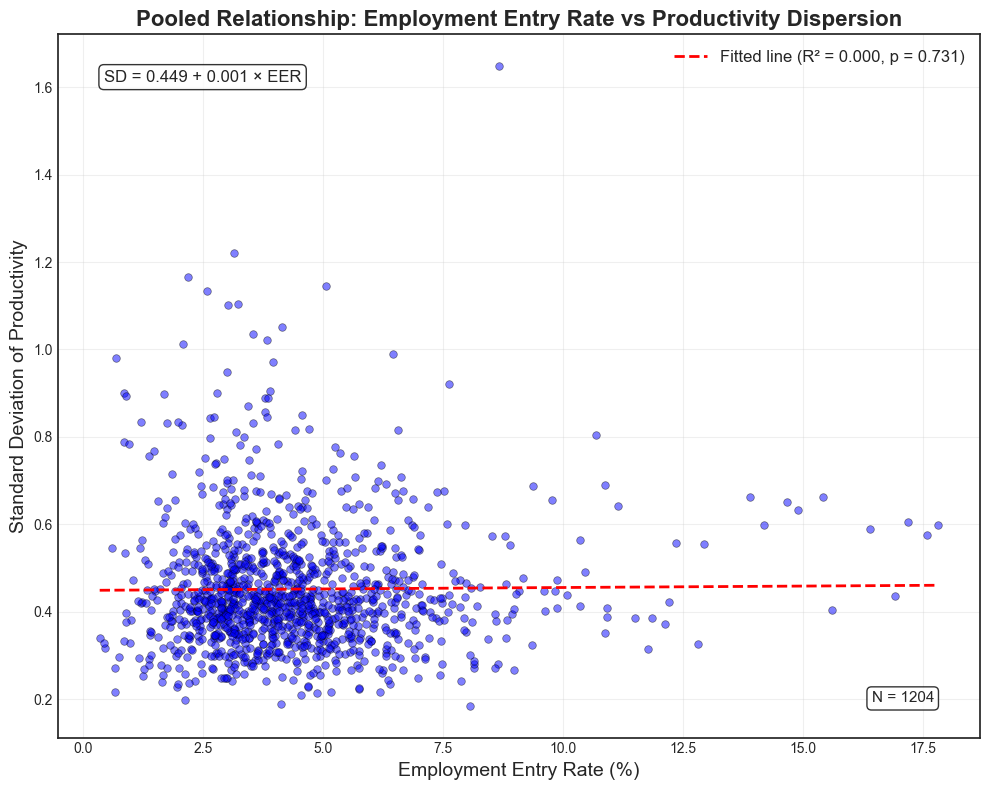


SUMMARY STATISTICS
Employment Entry Rate (eer):
  Mean: 4.400
  Std Dev: 2.215
  Min: 0.343
  Max: 17.811

Productivity Dispersion (sd):
  Mean: 0.452
  Std Dev: 0.146
  Min: 0.185
  Max: 1.647

Correlation between EER and SD: 0.010

Correlation by decade:
  1990s: -0.030
  2000s: 0.033
  2010s: 0.113
  2020s: 0.125


/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_11791/2849799241.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decade_corr = df_merged.groupby('decade').apply(


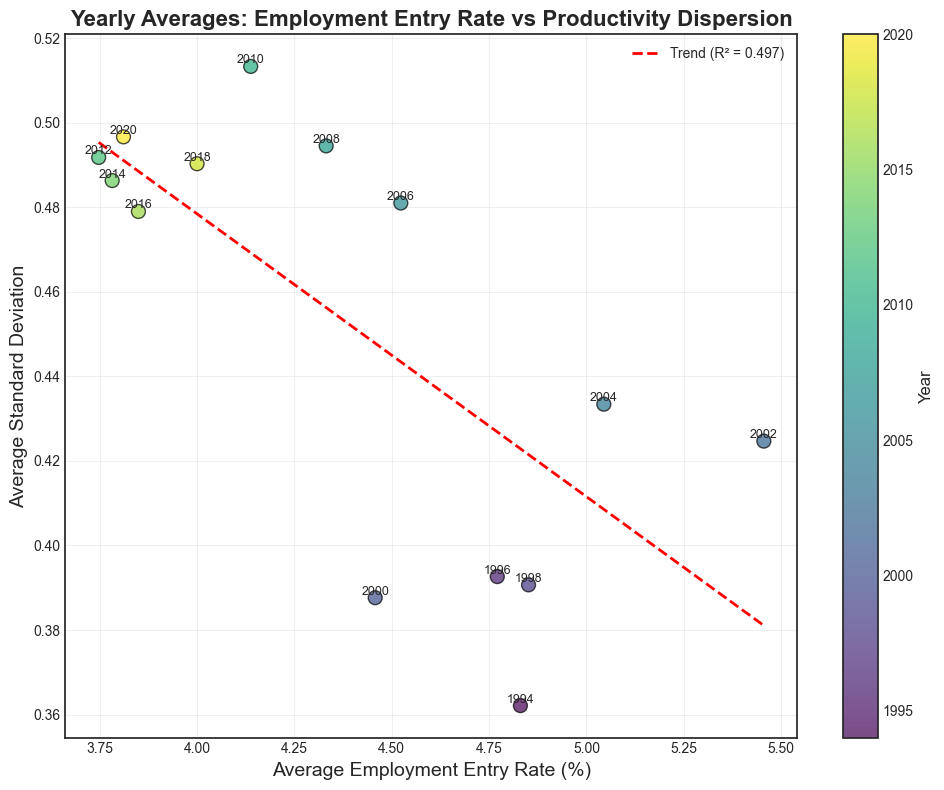

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")

# Create simple scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

# Check if 'eer' column exists, if not, create it
if 'eer' not in df_merged.columns:
    print("Creating employment entry rate (eer) variable...")
    # This would need the actual calculation based on your data
    # For now, I'll note that it needs to be calculated
    print("Note: eer needs to be calculated using the formula in the text")
else:
    # Simple scatter plot - all observations pooled
    ax.scatter(df_merged['eer'], df_merged['sd'], 
              alpha=0.5, s=30, color='blue', edgecolors='black', linewidth=0.5)
    
    # Calculate regression line
    # Remove any NaN values
    mask = ~(df_merged['eer'].isna() | df_merged['sd'].isna())
    x_clean = df_merged.loc[mask, 'eer']
    y_clean = df_merged.loc[mask, 'sd']
    
    if len(x_clean) > 2:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
        
        # Create regression line
        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
        y_line = slope * x_line + intercept
        
        # Plot regression line
        ax.plot(x_line, y_line, 'r--', linewidth=2, 
               label=f'Fitted line (R² = {r_value**2:.3f}, p = {p_value:.3f})')
        
        # Add equation to plot
        equation_text = f'SD = {intercept:.3f} + {slope:.3f} × EER'
        ax.text(0.05, 0.95, equation_text, transform=ax.transAxes, 
               fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Labels and formatting
    ax.set_xlabel('Employment Entry Rate (%)', fontsize=14)
    ax.set_ylabel('Standard Deviation of Productivity', fontsize=14)
    ax.set_title('Pooled Relationship: Employment Entry Rate vs Productivity Dispersion', 
                fontsize=16, fontweight='bold')
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add sample size
    n_obs = len(x_clean) if 'x_clean' in locals() else len(df_merged)
    ax.text(0.95, 0.05, f'N = {n_obs}', transform=ax.transAxes, 
           fontsize=11, horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Summary statistics
if 'eer' in df_merged.columns:
    print("\nSUMMARY STATISTICS")
    print("=" * 60)
    print(f"Employment Entry Rate (eer):")
    print(f"  Mean: {df_merged['eer'].mean():.3f}")
    print(f"  Std Dev: {df_merged['eer'].std():.3f}")
    print(f"  Min: {df_merged['eer'].min():.3f}")
    print(f"  Max: {df_merged['eer'].max():.3f}")
    print(f"\nProductivity Dispersion (sd):")
    print(f"  Mean: {df_merged['sd'].mean():.3f}")
    print(f"  Std Dev: {df_merged['sd'].std():.3f}")
    print(f"  Min: {df_merged['sd'].min():.3f}")
    print(f"  Max: {df_merged['sd'].max():.3f}")
    
    # Correlation
    corr = df_merged[['eer', 'sd']].corr().iloc[0, 1]
    print(f"\nCorrelation between EER and SD: {corr:.3f}")
    
    # By decade if desired
    if 'window_end_year' in df_merged.columns:
        print("\nCorrelation by decade:")
        df_merged['decade'] = (df_merged['window_end_year'] // 10) * 10
        decade_corr = df_merged.groupby('decade').apply(
            lambda x: x[['eer', 'sd']].corr().iloc[0, 1] if len(x) > 10 else np.nan
        )
        for decade, corr in decade_corr.items():
            if not np.isnan(corr):
                print(f"  {int(decade)}s: {corr:.3f}")

# Create yearly average plot to see time trends
if 'eer' in df_merged.columns and 'window_end_year' in df_merged.columns:
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    # Calculate yearly averages
    yearly_avg = df_merged.groupby('window_end_year').agg({
        'eer': 'mean',
        'sd': 'mean'
    }).reset_index()
    
    # Scatter plot with year labels
    scatter = ax2.scatter(yearly_avg['eer'], yearly_avg['sd'], 
                         s=100, alpha=0.7, c=yearly_avg['window_end_year'], 
                         cmap='viridis', edgecolors='black', linewidth=1)
    
    # Add year labels
    for idx, row in yearly_avg.iterrows():
        ax2.annotate(f"{int(row['window_end_year'])}", 
                    (row['eer'], row['sd']), 
                    fontsize=9, ha='center', va='bottom')
    
    # Add regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        yearly_avg['eer'], yearly_avg['sd']
    )
    x_line = np.linspace(yearly_avg['eer'].min(), yearly_avg['eer'].max(), 100)
    y_line = slope * x_line + intercept
    ax2.plot(x_line, y_line, 'r--', linewidth=2, 
            label=f'Trend (R² = {r_value**2:.3f})')
    
    # Formatting
    ax2.set_xlabel('Average Employment Entry Rate (%)', fontsize=14)
    ax2.set_ylabel('Average Standard Deviation', fontsize=14)
    ax2.set_title('Yearly Averages: Employment Entry Rate vs Productivity Dispersion', 
                 fontsize=16, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Year', fontsize=12)
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNote: 'eer' column not found in the data. Please ensure the employment entry rate is calculated.")

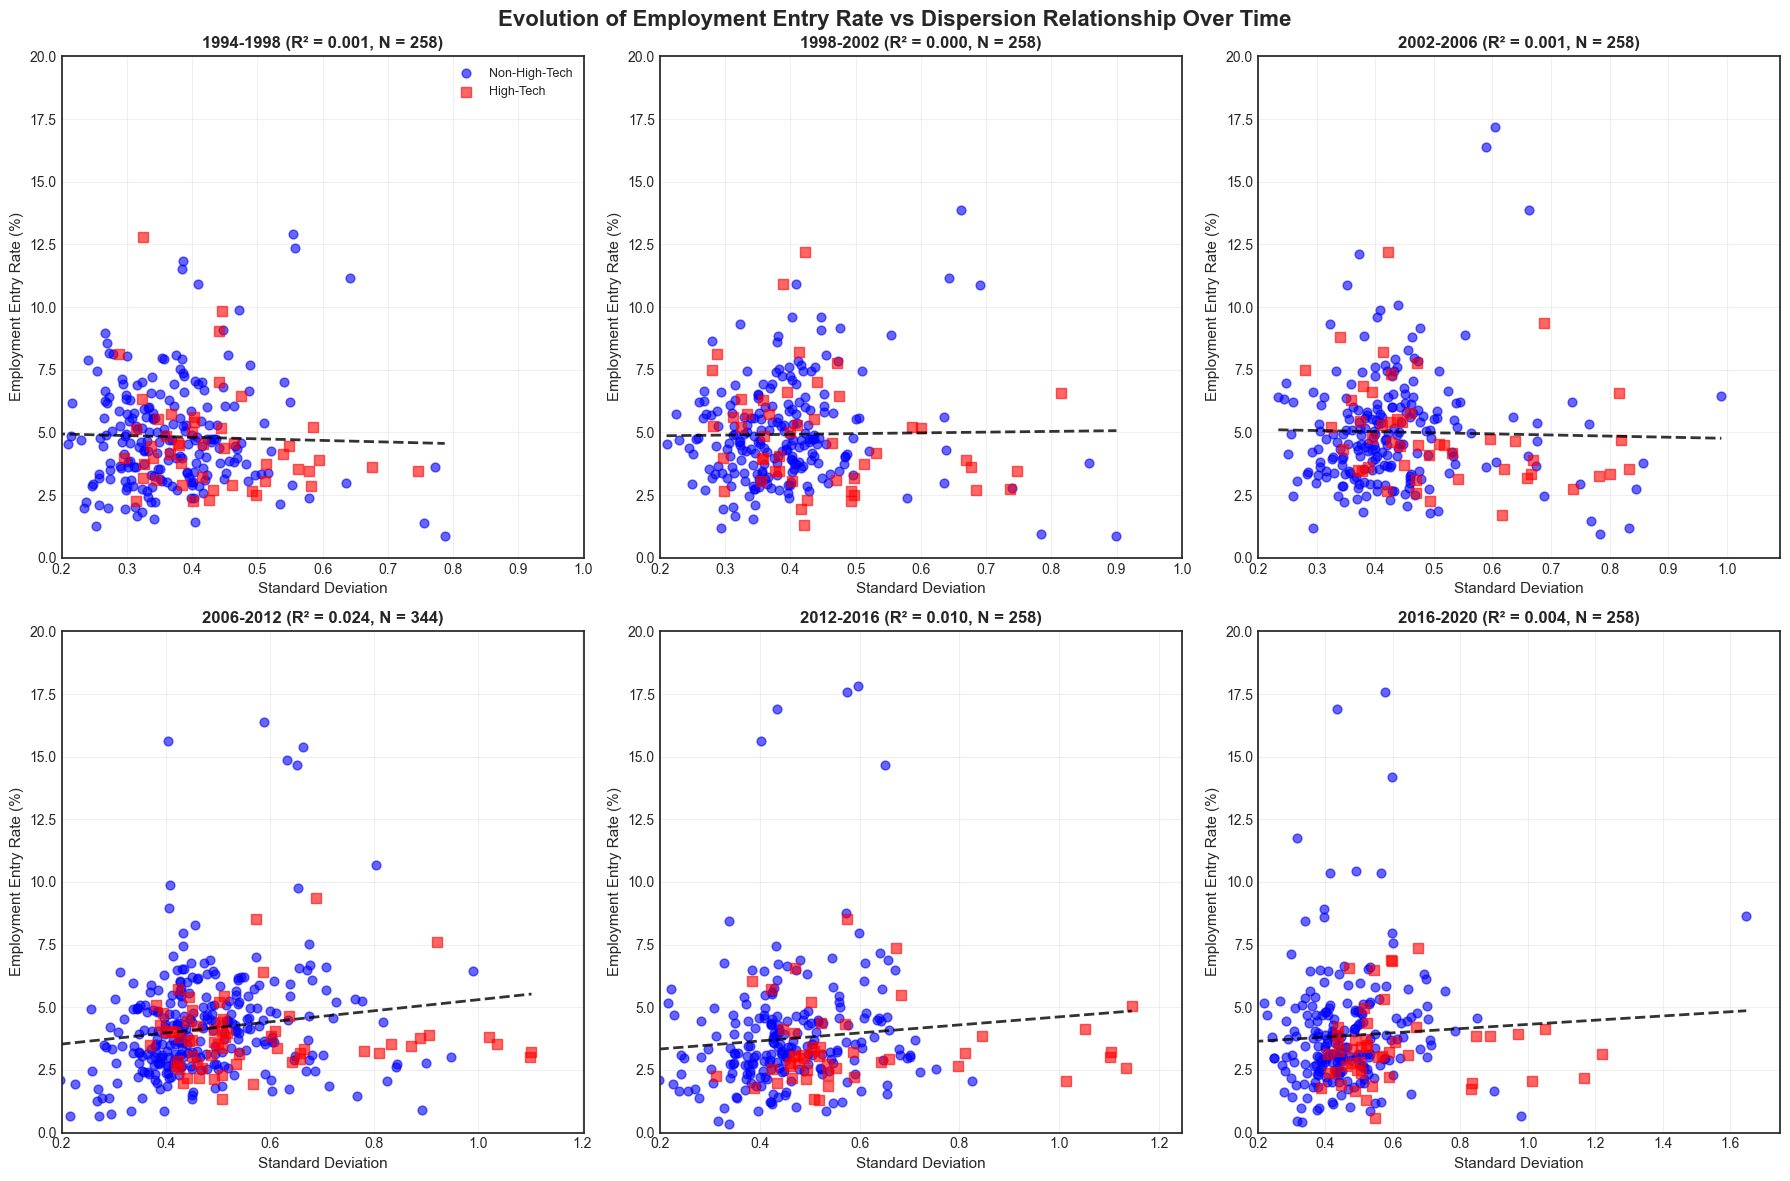

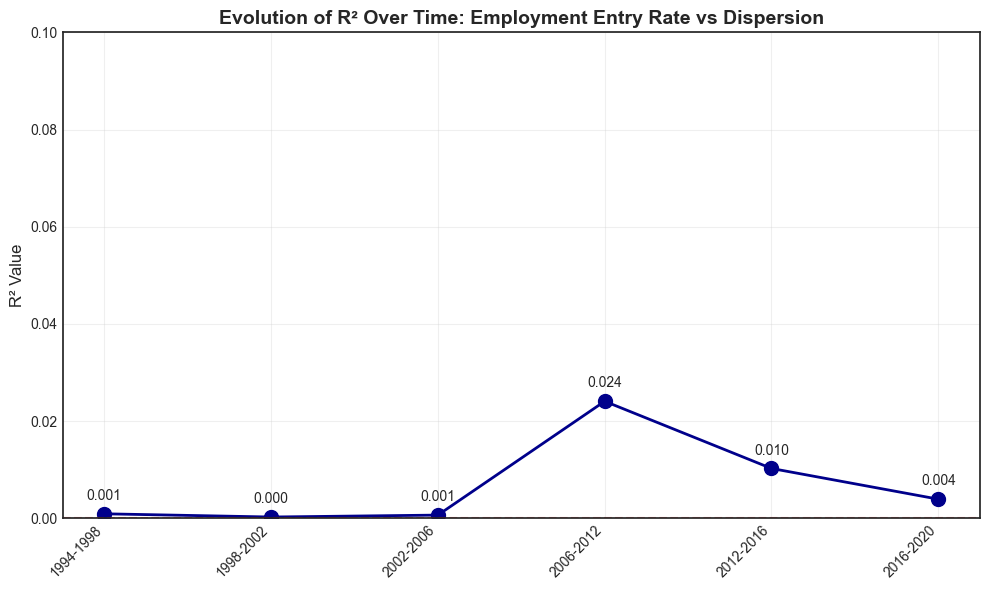


SUMMARY STATISTICS BY PERIOD
Period          Avg SD     Avg EER    Correlation  N Obs     
--------------------------------------------------------------------------------
1994-1998       0.382      4.818      -0.030       258       
1998-2002       0.401      4.921      0.016        258       
2002-2006       0.446      5.008      -0.025       258       
2006-2012       0.495      4.185      0.155        344       
2012-2016       0.486      3.793      0.101        258       
2016-2020       0.489      3.887      0.063        258       

TREND ANALYSIS
First half correlation (before 2007): -0.014
Second half correlation (after 2007): 0.134
Change in correlation: 0.148
The relationship has STRENGTHENED over time


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")

# Check if eer exists
if 'eer' not in df_merged.columns:
    print("Warning: 'eer' column not found in data")
    print("Please ensure employment entry rate is calculated")
else:
    # Create 6 time periods (same as the image shown)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Define the same time periods as in your image
    periods = [
        (1994, 1998, "1994-1998"),
        (1998, 2002, "1998-2002"), 
        (2002, 2006, "2002-2006"),
        (2006, 2012, "2006-2012"),
        (2012, 2016, "2012-2016"),
        (2016, 2020, "2016-2020")
    ]
    
    # Store R² values for trend analysis
    r_squared_values = []
    period_names = []
    
    for idx, (start_year, end_year, period_name) in enumerate(periods):
        ax = axes[idx]
        
        # Filter data for this period
        period_data = df_merged[(df_merged['window_end_year'] >= start_year) & 
                               (df_merged['window_end_year'] <= end_year)].copy()
        
        if len(period_data) > 0:
            # Separate by tech status
            hightech = period_data[period_data['hightech'] == 1]
            nonhightech = period_data[period_data['hightech'] == 0]
            
            # Plot non-high-tech
            ax.scatter(nonhightech['sd'], nonhightech['eer'], 
                      alpha=0.6, s=40, color='blue', label='Non-High-Tech')
            
            # Plot high-tech
            ax.scatter(hightech['sd'], hightech['eer'], 
                      alpha=0.6, s=60, color='red', marker='s', label='High-Tech')
            
            # Add regression line for all data in period
            if len(period_data) > 10:
                # Remove NaN values
                mask = ~(period_data['sd'].isna() | period_data['eer'].isna())
                x_clean = period_data.loc[mask, 'sd']
                y_clean = period_data.loc[mask, 'eer']
                
                if len(x_clean) > 2:
                    slope, intercept, r_value, p_value, _ = stats.linregress(x_clean, y_clean)
                    
                    # Store R² for trend analysis
                    r_squared_values.append(r_value**2)
                    period_names.append(period_name)
                    
                    # Create regression line
                    x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
                    y_line = slope * x_line + intercept
                    ax.plot(x_line, y_line, 'k--', linewidth=2, alpha=0.8)
                    
                    # Add title with R² and N
                    ax.set_title(f'{period_name} (R² = {r_value**2:.3f}, N = {len(x_clean)})', 
                                fontsize=12, fontweight='bold')
                else:
                    ax.set_title(f'{period_name} (N = {len(period_data)})', 
                                fontsize=12, fontweight='bold')
            
            # Set labels
            ax.set_xlabel('Standard Deviation', fontsize=11)
            ax.set_ylabel('Employment Entry Rate (%)', fontsize=11)
            ax.grid(True, alpha=0.3)
            
            # Add legend only to first plot
            if idx == 0:
                ax.legend(loc='upper right', fontsize=9)
            
            # Set consistent axis limits (adjust based on your data)
            ax.set_xlim(0.2, max(1.0, period_data['sd'].max() + 0.1))
            ax.set_ylim(0, max(20, period_data['eer'].max() + 2))
    
    plt.suptitle('Evolution of Employment Entry Rate vs Dispersion Relationship Over Time', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Create a summary plot showing R² evolution
    if len(r_squared_values) > 0:
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        
        ax2.plot(range(len(r_squared_values)), r_squared_values, 'o-', 
                markersize=10, linewidth=2, color='darkblue')
        
        # Add value labels
        for i, (period, r2) in enumerate(zip(period_names, r_squared_values)):
            ax2.annotate(f'{r2:.3f}', (i, r2), 
                        textcoords="offset points", xytext=(0,10), ha='center')
        
        ax2.set_xticks(range(len(period_names)))
        ax2.set_xticklabels(period_names, rotation=45, ha='right')
        ax2.set_ylabel('R² Value', fontsize=12)
        ax2.set_title('Evolution of R² Over Time: Employment Entry Rate vs Dispersion', 
                     fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, max(0.1, max(r_squared_values) * 1.2))
        
        # Add horizontal line at R²=0
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
    
    # Summary statistics by period
    print("\nSUMMARY STATISTICS BY PERIOD")
    print("=" * 80)
    print(f"{'Period':<15} {'Avg SD':<10} {'Avg EER':<10} {'Correlation':<12} {'N Obs':<10}")
    print("-" * 80)
    
    for start_year, end_year, period_name in periods:
        period_data = df_merged[(df_merged['window_end_year'] >= start_year) & 
                               (df_merged['window_end_year'] <= end_year)]
        
        if len(period_data) > 0 and 'eer' in period_data.columns:
            avg_sd = period_data['sd'].mean()
            avg_eer = period_data['eer'].mean()
            
            # Calculate correlation
            mask = ~(period_data['sd'].isna() | period_data['eer'].isna())
            if mask.sum() > 2:
                corr = period_data.loc[mask, ['sd', 'eer']].corr().iloc[0, 1]
            else:
                corr = np.nan
                
            n_obs = len(period_data)
            
            print(f"{period_name:<15} {avg_sd:<10.3f} {avg_eer:<10.3f} {corr:<12.3f} {n_obs:<10}")
    
    # Overall trend analysis
    print("\n" + "=" * 80)
    print("TREND ANALYSIS")
    print("=" * 80)
    
    # Calculate correlation for first half vs second half
    median_year = df_merged['window_end_year'].median()
    first_half = df_merged[df_merged['window_end_year'] <= median_year]
    second_half = df_merged[df_merged['window_end_year'] > median_year]
    
    if 'eer' in first_half.columns:
        mask1 = ~(first_half['sd'].isna() | first_half['eer'].isna())
        mask2 = ~(second_half['sd'].isna() | second_half['eer'].isna())
        
        if mask1.sum() > 2 and mask2.sum() > 2:
            corr1 = first_half.loc[mask1, ['sd', 'eer']].corr().iloc[0, 1]
            corr2 = second_half.loc[mask2, ['sd', 'eer']].corr().iloc[0, 1]
            
            print(f"First half correlation (before {median_year:.0f}): {corr1:.3f}")
            print(f"Second half correlation (after {median_year:.0f}): {corr2:.3f}")
            print(f"Change in correlation: {corr2 - corr1:.3f}")
            
            if corr2 - corr1 > 0:
                print("The relationship has STRENGTHENED over time")
            else:
                print("The relationship has WEAKENED over time")

Creating lagged EER variables...
Lagged variables created:
  eer_lag1: 1118 non-missing values
  eer_lag2: 1032 non-missing values
  eer_lag3: 946 non-missing values


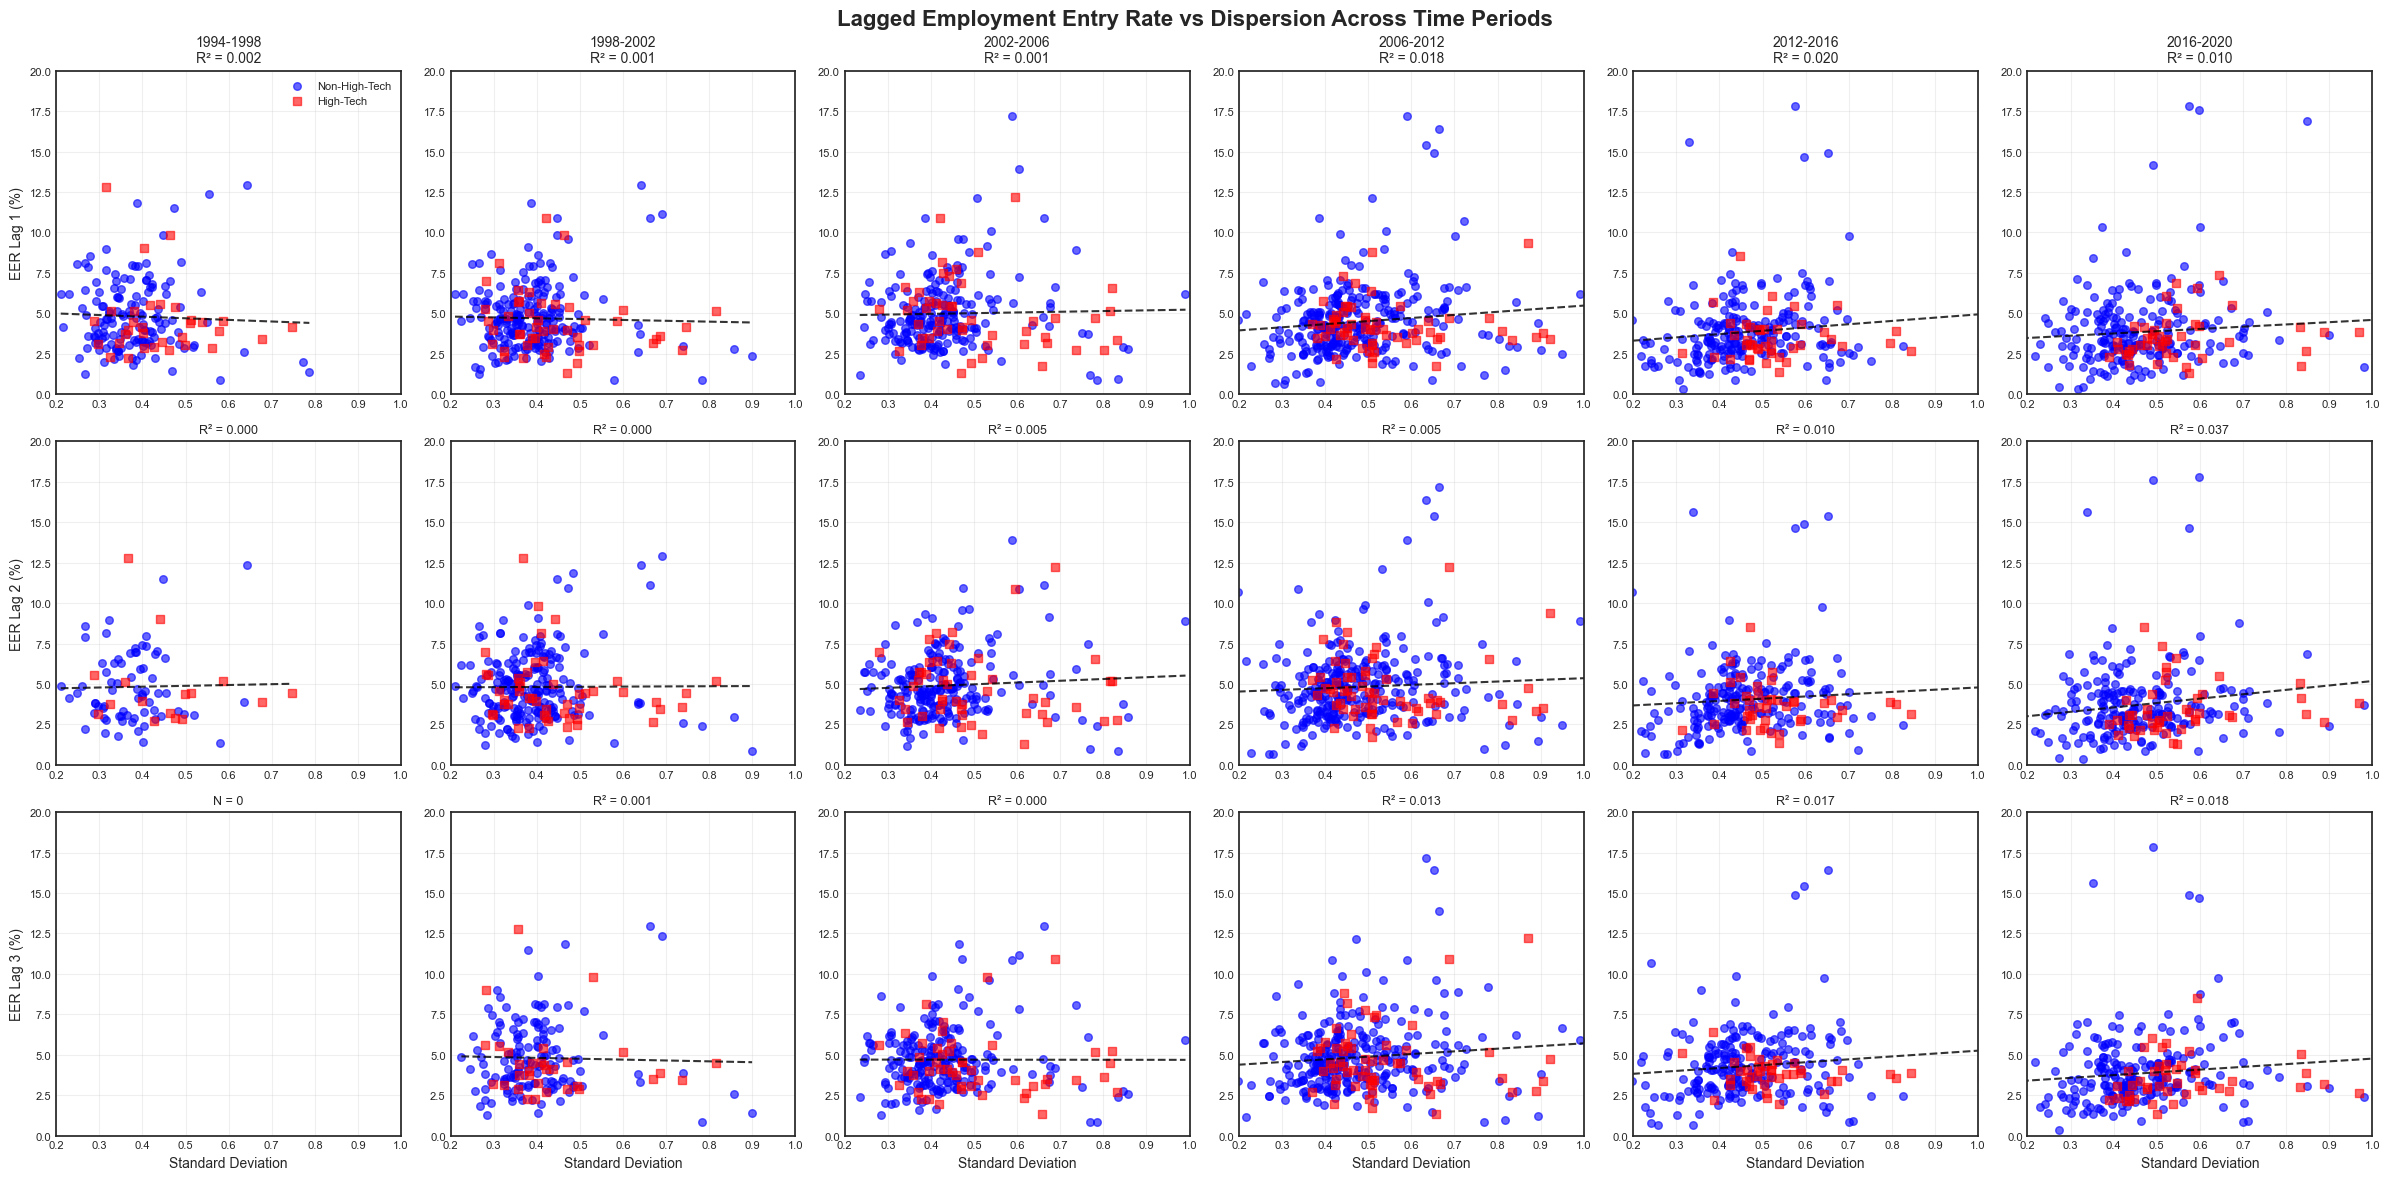

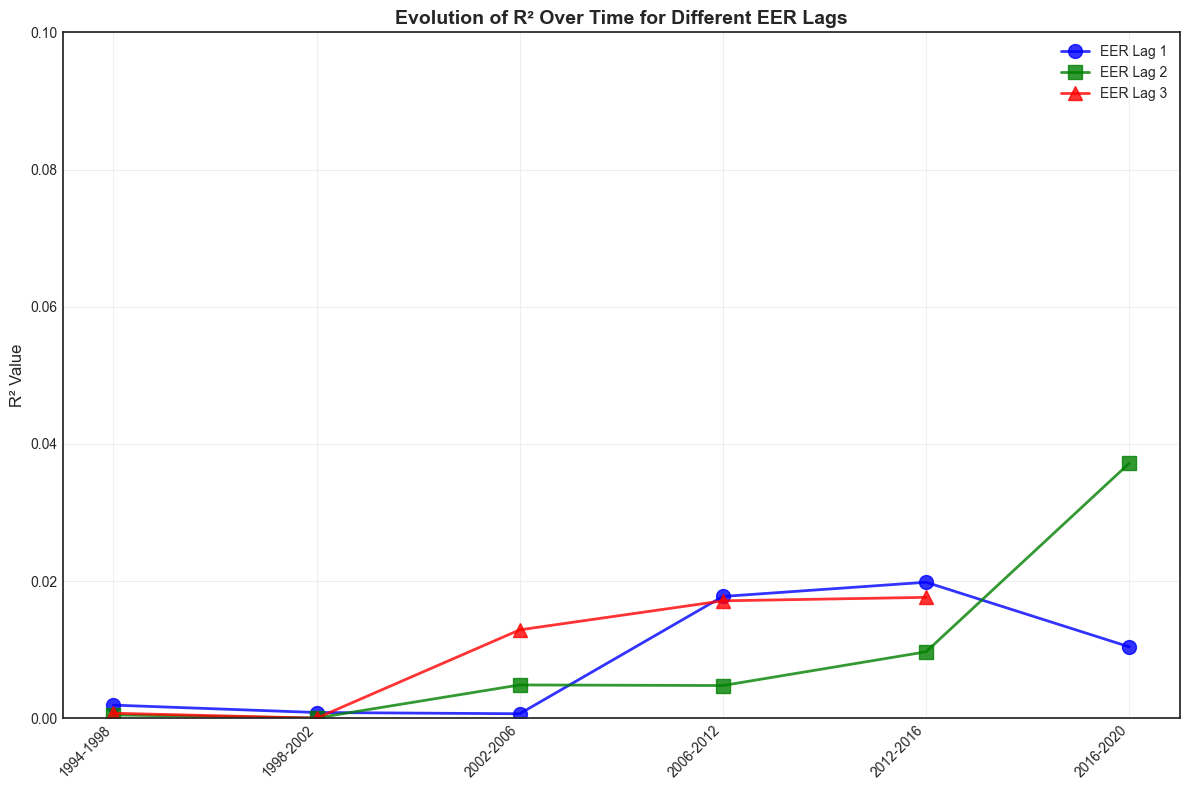

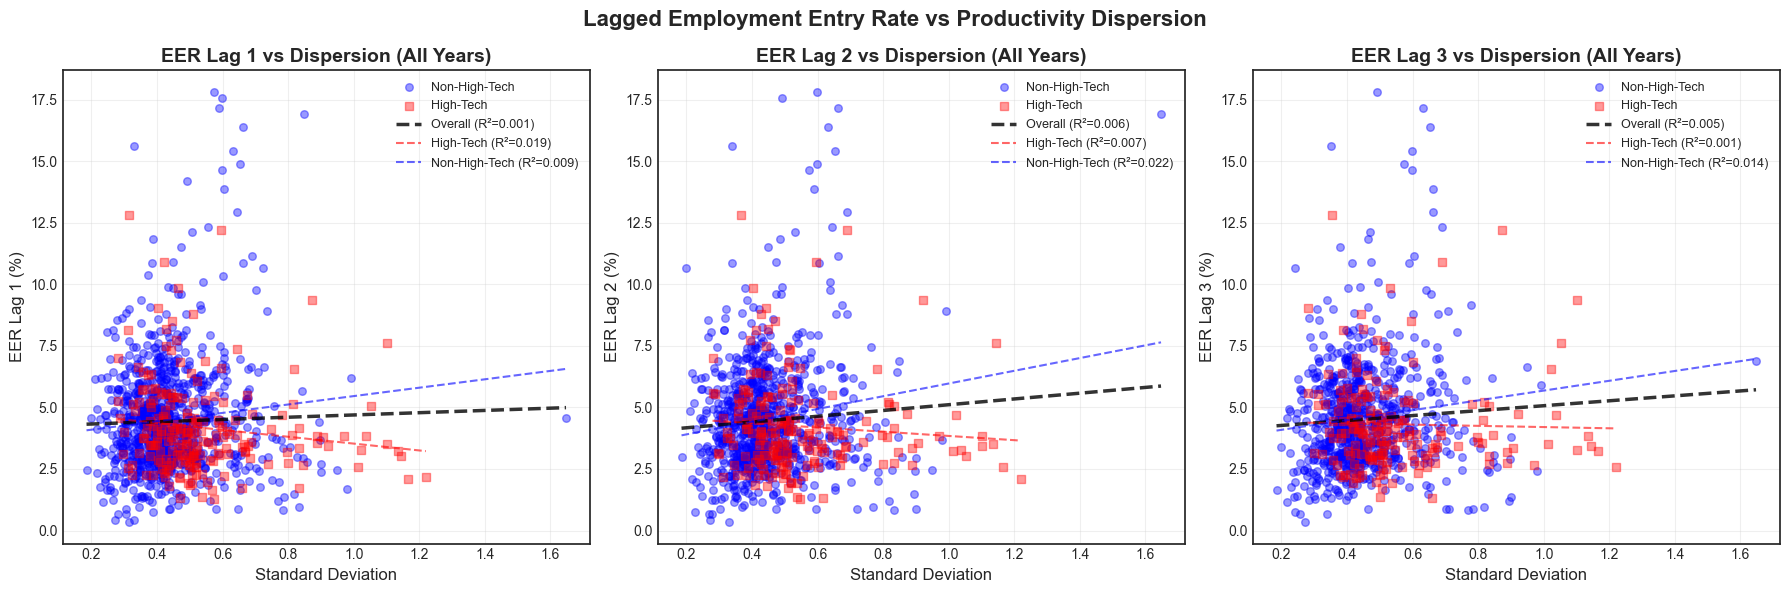


SUMMARY STATISTICS FOR LAGGED RELATIONSHIPS
Lag             Correlation     Slope           R²              N Obs          
--------------------------------------------------------------------------------
EER Lag 1       0.031           0.460           0.001           1118           
EER Lag 2       0.078           1.171           0.006           1032           
EER Lag 3       0.070           1.001           0.005           946            
Contemporaneous 0.010           0.150           0.000           1204           


In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")

# First, create lagged eer variables if they don't exist
if 'eer' in df_merged.columns:
    print("Creating lagged EER variables...")
    
    # Sort by industry and year
    df_merged_sorted = df_merged.sort_values(['naics4', 'window_end_year'])
    
    # Create lags
    df_merged_sorted['eer_lag1'] = df_merged_sorted.groupby('naics4')['eer'].shift(1)
    df_merged_sorted['eer_lag2'] = df_merged_sorted.groupby('naics4')['eer'].shift(2)
    df_merged_sorted['eer_lag3'] = df_merged_sorted.groupby('naics4')['eer'].shift(3)
    
    # Update df_merged
    df_merged = df_merged_sorted.copy()
    
    print(f"Lagged variables created:")
    print(f"  eer_lag1: {df_merged['eer_lag1'].notna().sum()} non-missing values")
    print(f"  eer_lag2: {df_merged['eer_lag2'].notna().sum()} non-missing values")
    print(f"  eer_lag3: {df_merged['eer_lag3'].notna().sum()} non-missing values")
    
    # Create figure with 3 rows (one for each lag) and 6 columns (time periods)
    fig, axes = plt.subplots(3, 6, figsize=(24, 12))
    
    # Define time periods
    periods = [
        (1994, 1998, "1994-1998"),
        (1998, 2002, "1998-2002"), 
        (2002, 2006, "2002-2006"),
        (2006, 2012, "2006-2012"),
        (2012, 2016, "2012-2016"),
        (2016, 2020, "2016-2020")
    ]
    
    # Define lags
    lags = [
        ('eer_lag1', 'EER Lag 1'),
        ('eer_lag2', 'EER Lag 2'),
        ('eer_lag3', 'EER Lag 3')
    ]
    
    # Store R² values for each lag
    r_squared_by_lag = {lag: [] for lag, _ in lags}
    
    # Plot for each lag and period
    for lag_idx, (lag_var, lag_name) in enumerate(lags):
        for period_idx, (start_year, end_year, period_name) in enumerate(periods):
            ax = axes[lag_idx, period_idx]
            
            # Filter data for this period
            period_data = df_merged[(df_merged['window_end_year'] >= start_year) & 
                                   (df_merged['window_end_year'] <= end_year)].copy()
            
            if len(period_data) > 0 and lag_var in period_data.columns:
                # Separate by tech status
                hightech = period_data[period_data['hightech'] == 1]
                nonhightech = period_data[period_data['hightech'] == 0]
                
                # Plot non-high-tech
                ax.scatter(nonhightech['sd'], nonhightech[lag_var], 
                          alpha=0.6, s=30, color='blue', label='Non-High-Tech')
                
                # Plot high-tech
                ax.scatter(hightech['sd'], hightech[lag_var], 
                          alpha=0.6, s=40, color='red', marker='s', label='High-Tech')
                
                # Add regression line
                mask = ~(period_data['sd'].isna() | period_data[lag_var].isna())
                if mask.sum() > 10:
                    x_clean = period_data.loc[mask, 'sd']
                    y_clean = period_data.loc[mask, lag_var]
                    
                    slope, intercept, r_value, p_value, _ = stats.linregress(x_clean, y_clean)
                    r_squared_by_lag[lag_var].append(r_value**2)
                    
                    # Create regression line
                    x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
                    y_line = slope * x_line + intercept
                    ax.plot(x_line, y_line, 'k--', linewidth=1.5, alpha=0.8)
                    
                    # Add R² to title
                    title_text = f'R² = {r_value**2:.3f}'
                else:
                    title_text = f'N = {mask.sum()}'
                
                # Set title
                if lag_idx == 0:
                    ax.set_title(f'{period_name}\n{title_text}', fontsize=10)
                else:
                    ax.set_title(title_text, fontsize=9)
                
                # Set labels
                if period_idx == 0:
                    ax.set_ylabel(f'{lag_name} (%)', fontsize=10)
                if lag_idx == 2:
                    ax.set_xlabel('Standard Deviation', fontsize=10)
                
                # Add legend only to first plot
                if lag_idx == 0 and period_idx == 0:
                    ax.legend(loc='upper right', fontsize=8)
                
                ax.grid(True, alpha=0.3)
                ax.tick_params(labelsize=8)
                
                # Set consistent axis limits
                ax.set_xlim(0.2, 1.0)
                ax.set_ylim(0, 20)
    
    plt.suptitle('Lagged Employment Entry Rate vs Dispersion Across Time Periods', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Create summary plot showing R² evolution for each lag
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    
    colors = ['blue', 'green', 'red']
    markers = ['o', 's', '^']
    
    for idx, (lag_var, lag_name) in enumerate(lags):
        if len(r_squared_by_lag[lag_var]) > 0:
            ax2.plot(range(len(r_squared_by_lag[lag_var])), 
                    r_squared_by_lag[lag_var], 
                    marker=markers[idx], markersize=10, linewidth=2, 
                    color=colors[idx], label=lag_name, alpha=0.8)
    
    ax2.set_xticks(range(len(periods)))
    ax2.set_xticklabels([p[2] for p in periods], rotation=45, ha='right')
    ax2.set_ylabel('R² Value', fontsize=12)
    ax2.set_title('Evolution of R² Over Time for Different EER Lags', 
                 fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 0.1)
    
    plt.tight_layout()
    plt.show()
    
    # Create a focused plot comparing all three lags in one figure
    fig3, axes3 = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, (lag_var, lag_name) in enumerate(lags):
        ax = axes3[idx]
        
        # Use all data (not separated by period)
        mask = ~(df_merged['sd'].isna() | df_merged[lag_var].isna())
        data_clean = df_merged[mask].copy()
        
        if len(data_clean) > 0:
            # Separate by tech status
            hightech = data_clean[data_clean['hightech'] == 1]
            nonhightech = data_clean[data_clean['hightech'] == 0]
            
            # Plot
            ax.scatter(nonhightech['sd'], nonhightech[lag_var], 
                      alpha=0.4, s=30, color='blue', label='Non-High-Tech')
            ax.scatter(hightech['sd'], hightech[lag_var], 
                      alpha=0.4, s=40, color='red', marker='s', label='High-Tech')
            
            # Overall regression line
            slope, intercept, r_value, p_value, _ = stats.linregress(
                data_clean['sd'], data_clean[lag_var]
            )
            
            x_line = np.linspace(data_clean['sd'].min(), data_clean['sd'].max(), 100)
            y_line = slope * x_line + intercept
            ax.plot(x_line, y_line, 'k--', linewidth=2.5, alpha=0.8,
                   label=f'Overall (R²={r_value**2:.3f})')
            
            # Separate regression lines by tech status
            if len(hightech) > 10:
                slope_ht, int_ht, r_ht, _, _ = stats.linregress(
                    hightech['sd'], hightech[lag_var]
                )
                x_ht = np.linspace(hightech['sd'].min(), hightech['sd'].max(), 50)
                y_ht = slope_ht * x_ht + int_ht
                ax.plot(x_ht, y_ht, 'r--', linewidth=1.5, alpha=0.6,
                       label=f'High-Tech (R²={r_ht**2:.3f})')
            
            if len(nonhightech) > 10:
                slope_nt, int_nt, r_nt, _, _ = stats.linregress(
                    nonhightech['sd'], nonhightech[lag_var]
                )
                x_nt = np.linspace(nonhightech['sd'].min(), nonhightech['sd'].max(), 50)
                y_nt = slope_nt * x_nt + int_nt
                ax.plot(x_nt, y_nt, 'b--', linewidth=1.5, alpha=0.6,
                       label=f'Non-High-Tech (R²={r_nt**2:.3f})')
            
            ax.set_xlabel('Standard Deviation', fontsize=12)
            ax.set_ylabel(f'{lag_name} (%)', fontsize=12)
            ax.set_title(f'{lag_name} vs Dispersion (All Years)', fontsize=14, fontweight='bold')
            ax.legend(loc='best', fontsize=9)
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('Lagged Employment Entry Rate vs Productivity Dispersion', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nSUMMARY STATISTICS FOR LAGGED RELATIONSHIPS")
    print("=" * 80)
    print(f"{'Lag':<15} {'Correlation':<15} {'Slope':<15} {'R²':<15} {'N Obs':<15}")
    print("-" * 80)
    
    for lag_var, lag_name in lags:
        mask = ~(df_merged['sd'].isna() | df_merged[lag_var].isna())
        if mask.sum() > 0:
            corr = df_merged.loc[mask, ['sd', lag_var]].corr().iloc[0, 1]
            
            # Regression stats
            slope, _, r_value, p_value, _ = stats.linregress(
                df_merged.loc[mask, 'sd'], 
                df_merged.loc[mask, lag_var]
            )
            
            print(f"{lag_name:<15} {corr:<15.3f} {slope:<15.3f} {r_value**2:<15.3f} {mask.sum():<15}")
    
    # Compare with contemporaneous relationship
    if 'eer' in df_merged.columns:
        mask_contemp = ~(df_merged['sd'].isna() | df_merged['eer'].isna())
        if mask_contemp.sum() > 0:
            corr_contemp = df_merged.loc[mask_contemp, ['sd', 'eer']].corr().iloc[0, 1]
            slope_contemp, _, r_contemp, _, _ = stats.linregress(
                df_merged.loc[mask_contemp, 'sd'], 
                df_merged.loc[mask_contemp, 'eer']
            )
            print(f"{'Contemporaneous':<15} {corr_contemp:<15.3f} {slope_contemp:<15.3f} {r_contemp**2:<15.3f} {mask_contemp.sum():<15}")

else:
    print("Error: 'eer' column not found in data. Cannot create lagged variables.")

Creating lagged EER variables...
Lagged variables created/verified:
  eer_lag1: 1118 non-missing values
  eer_lag2: 1032 non-missing values
  eer_lag3: 946 non-missing values

Created 13 two-year periods:
  1994-1996
  1996-1998
  1998-2000
  2000-2002
  2002-2004
  2004-2006
  2006-2008
  2008-2010
  2010-2012
  2012-2014
  2014-2016
  2016-2018
  2018-2020


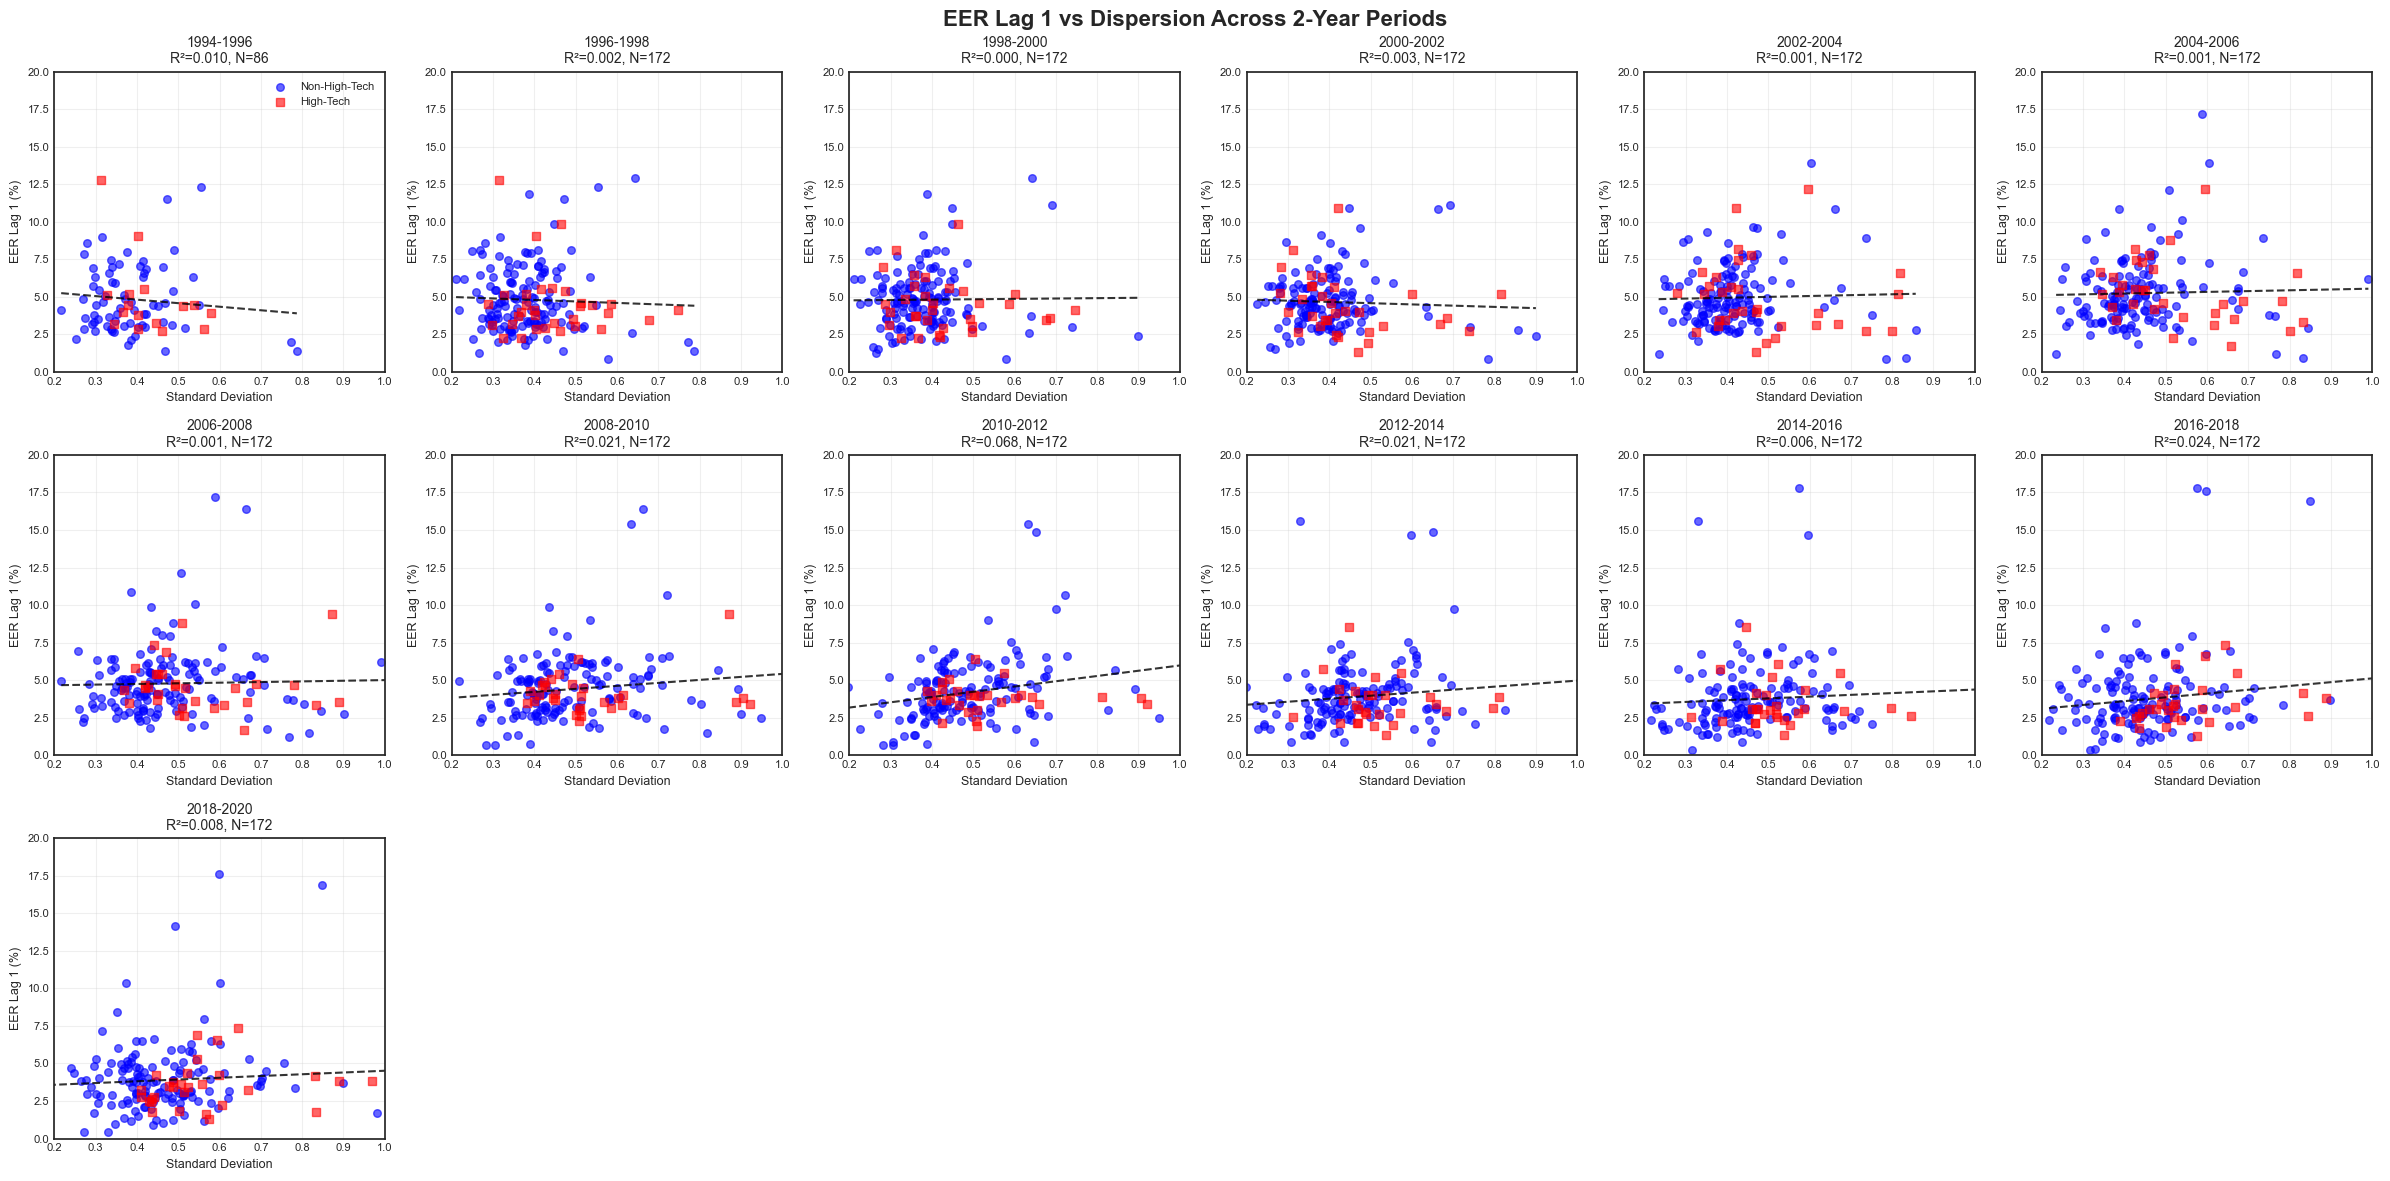

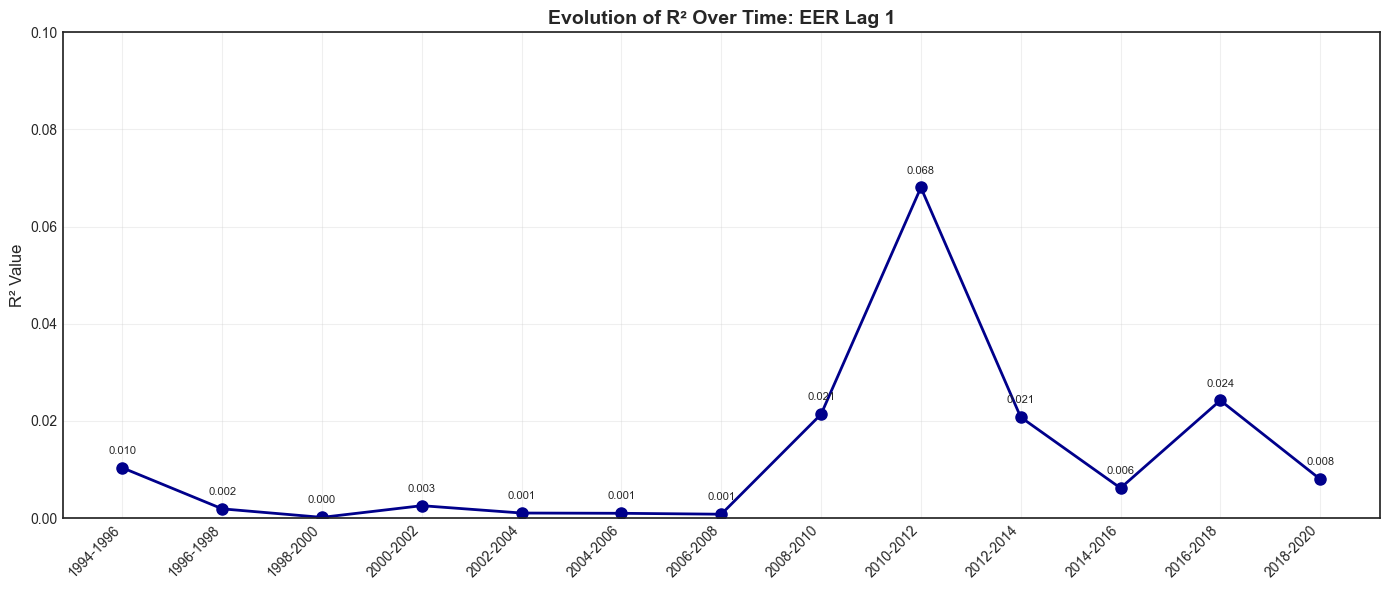

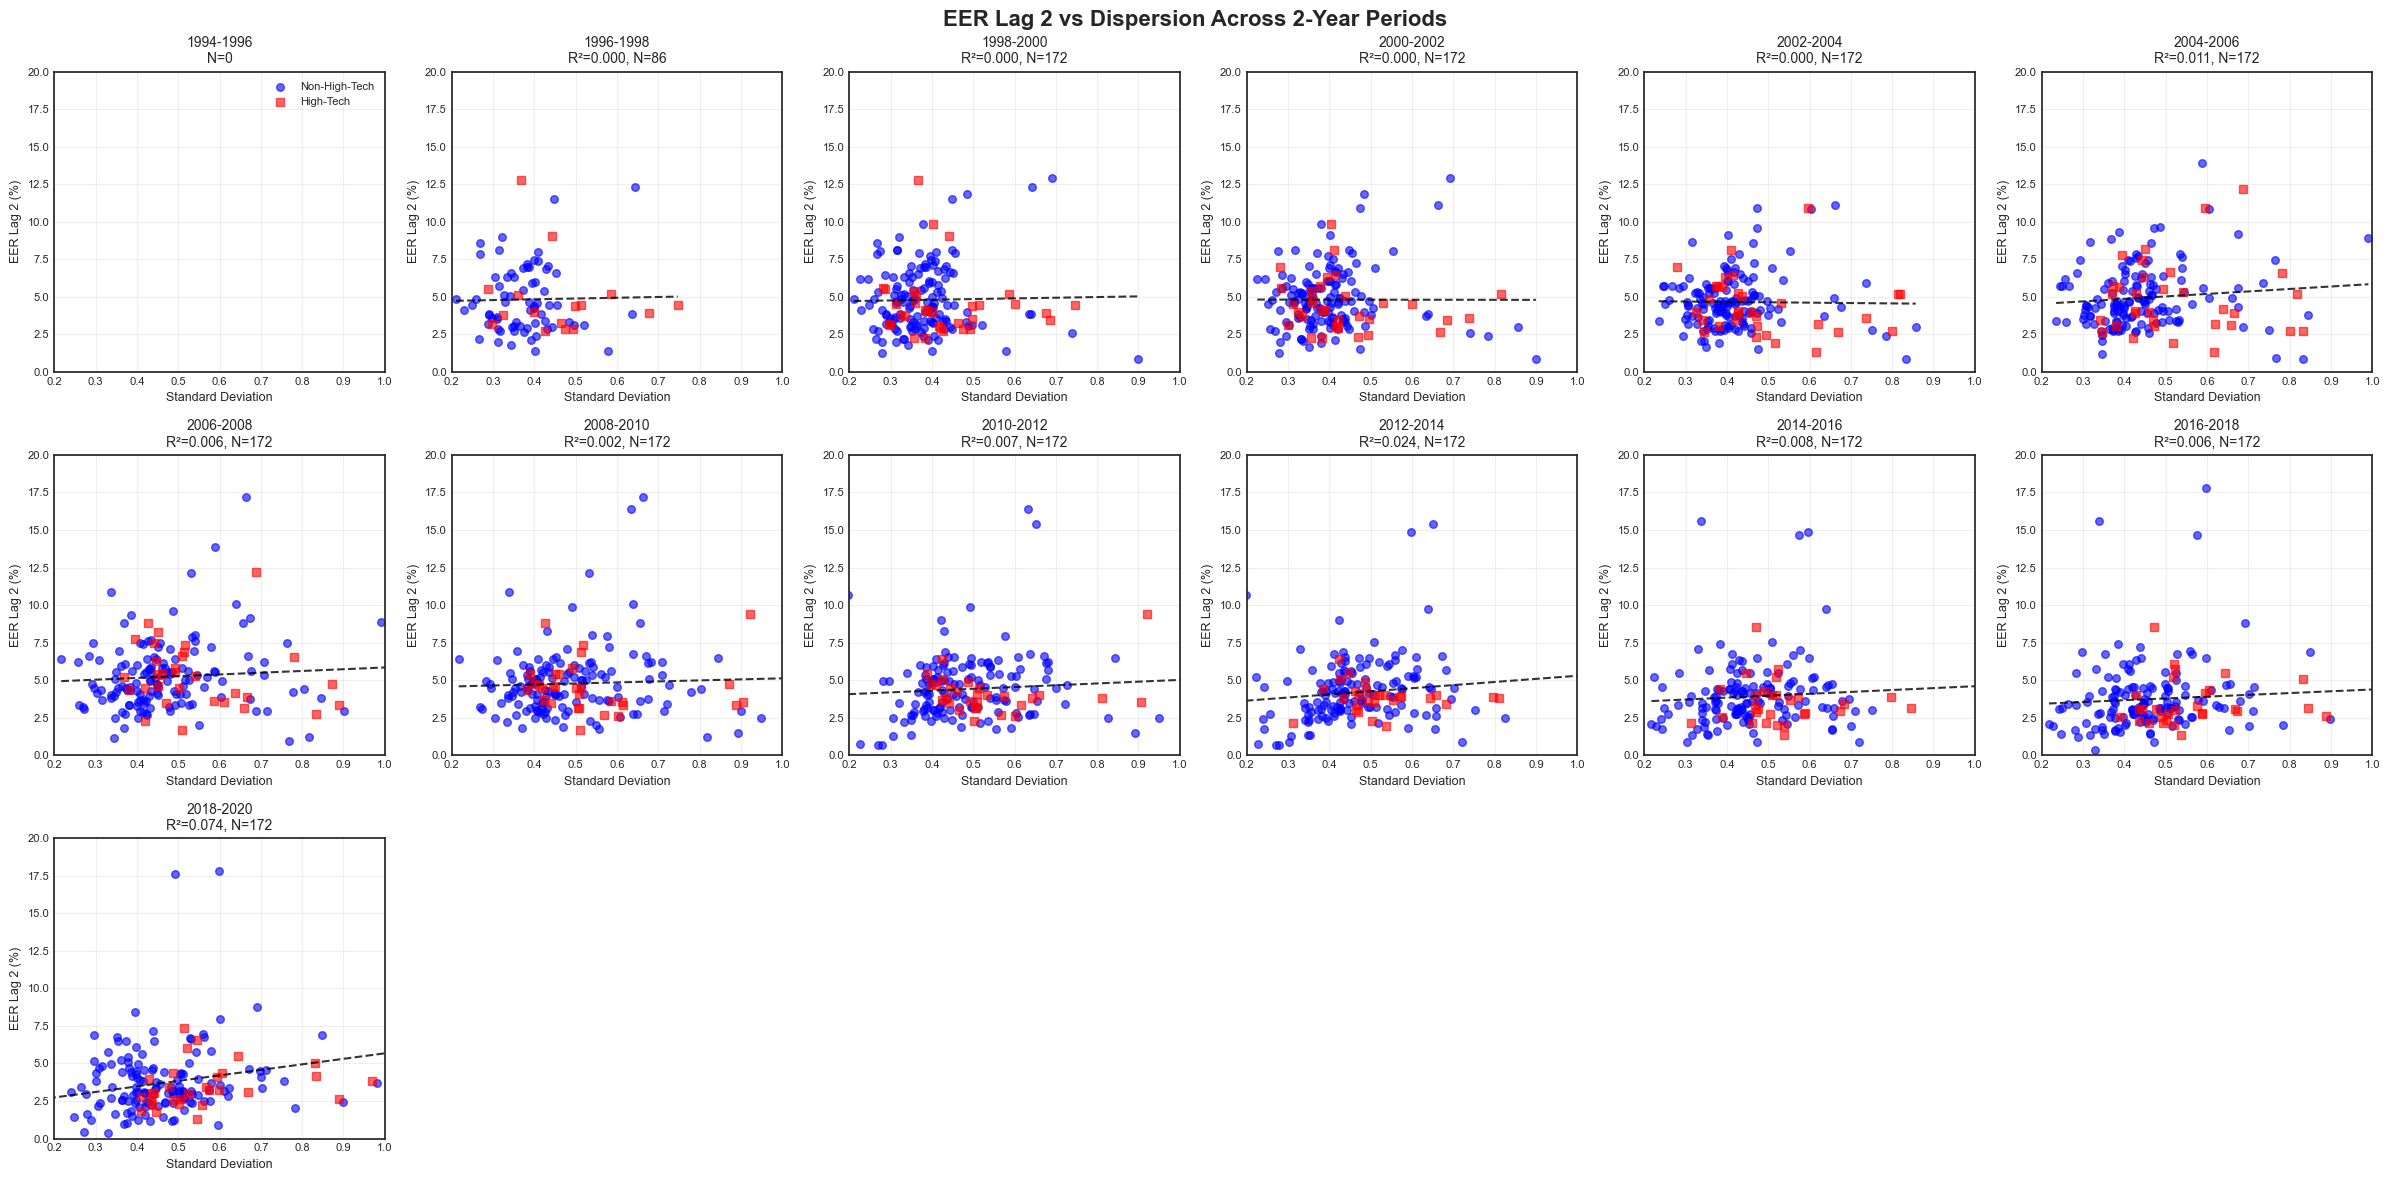

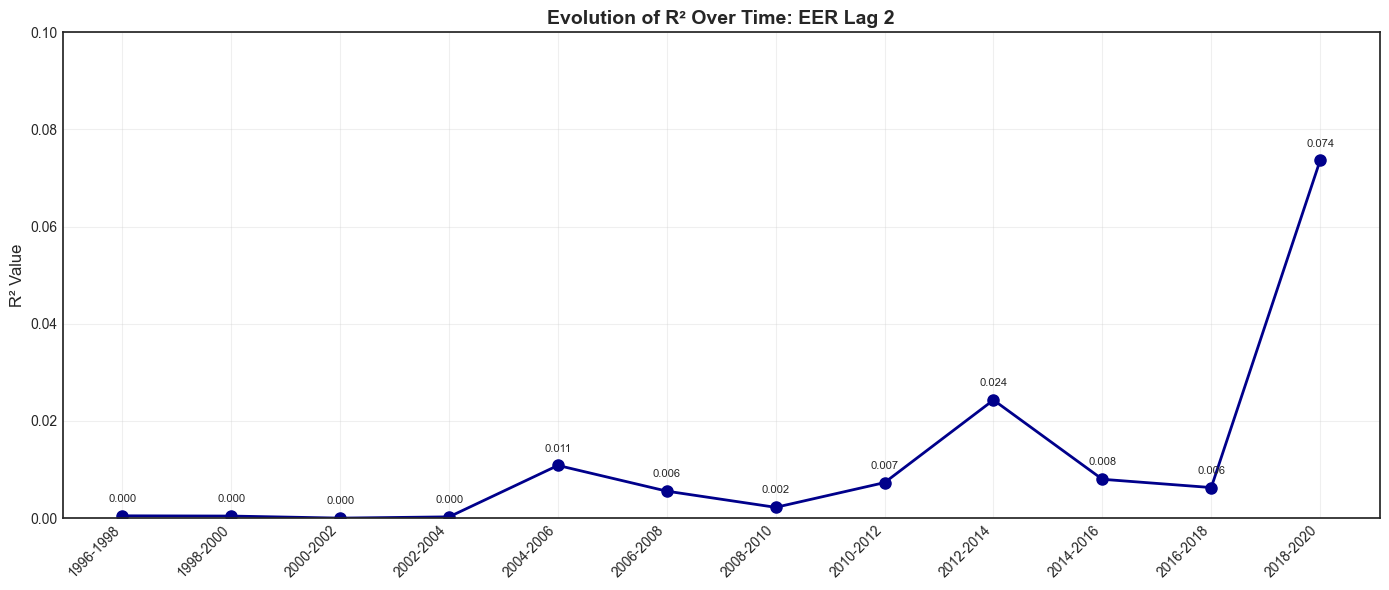

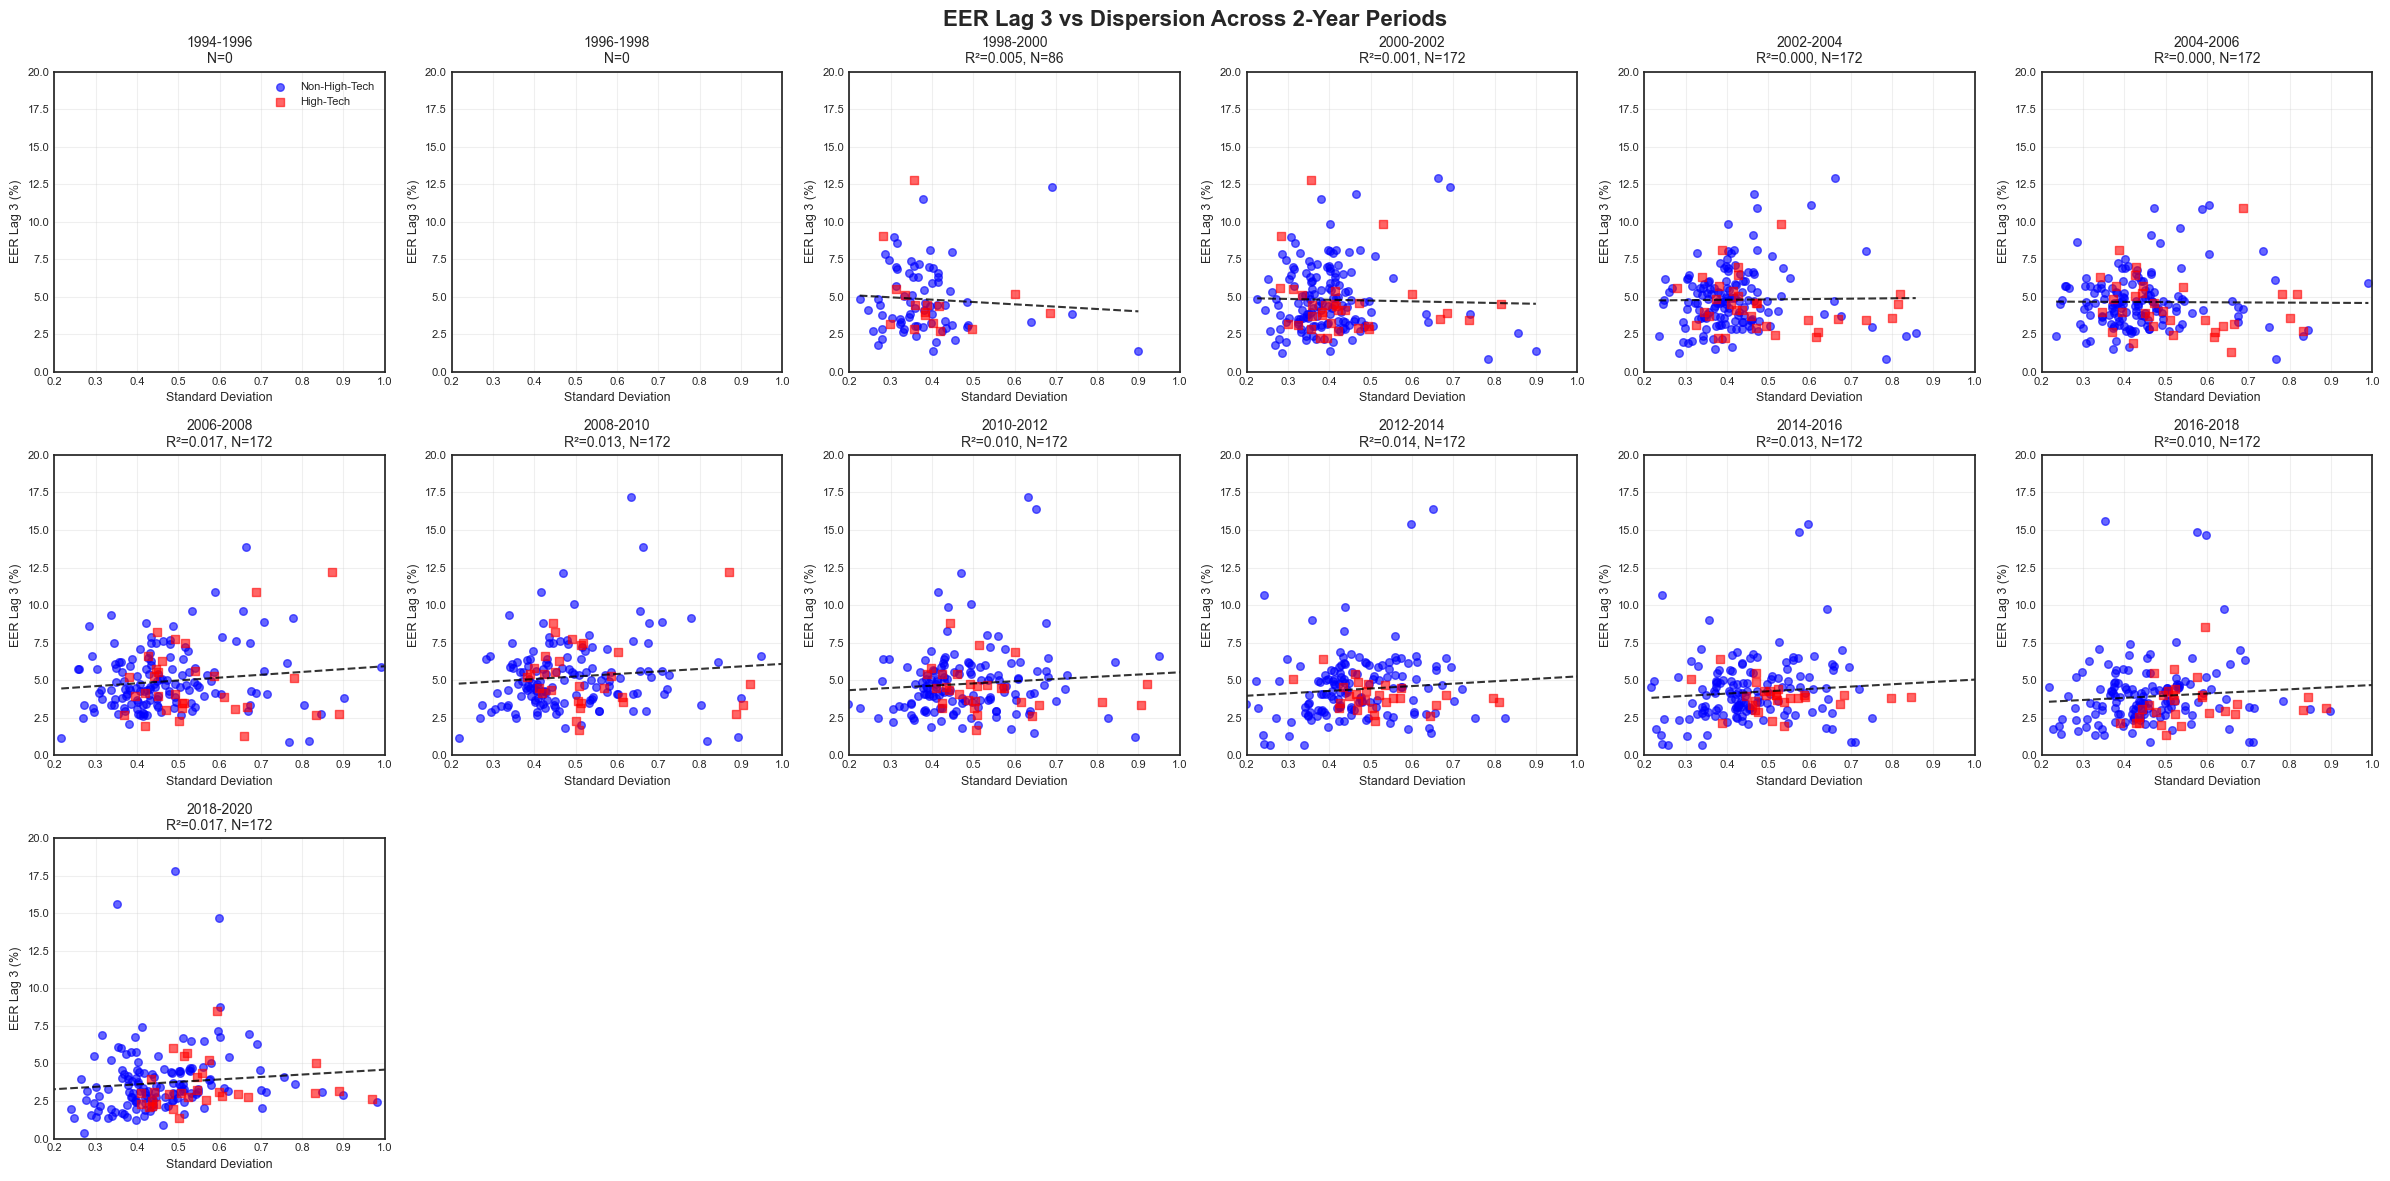

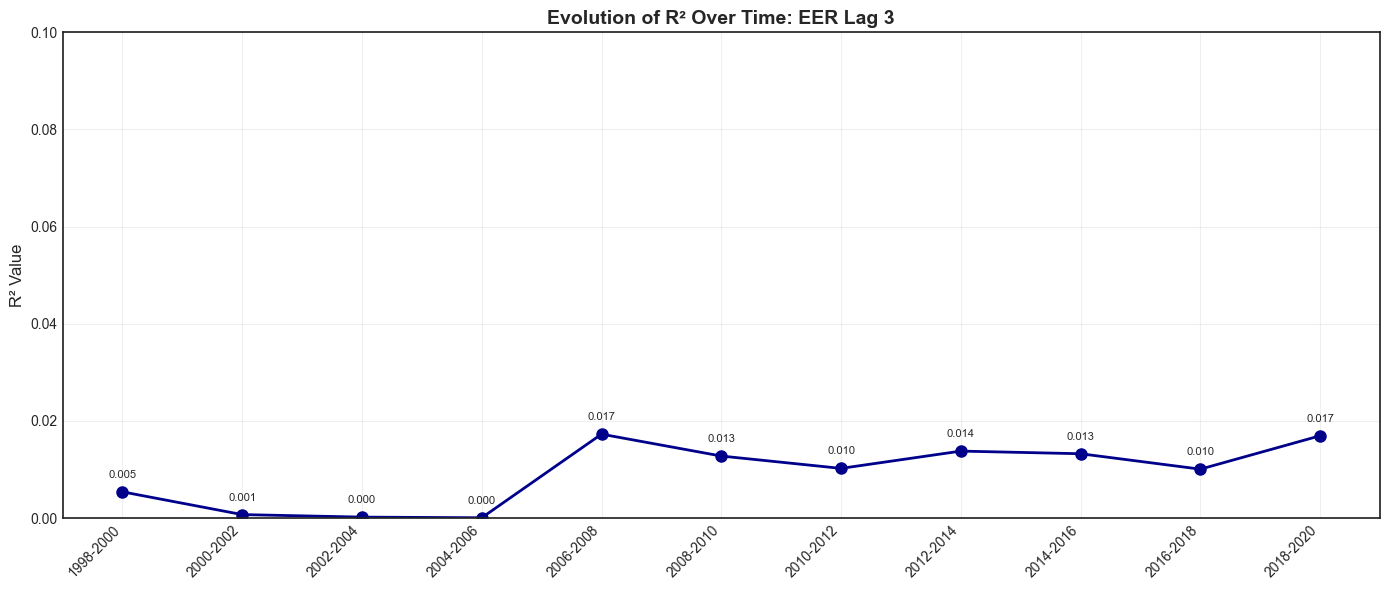

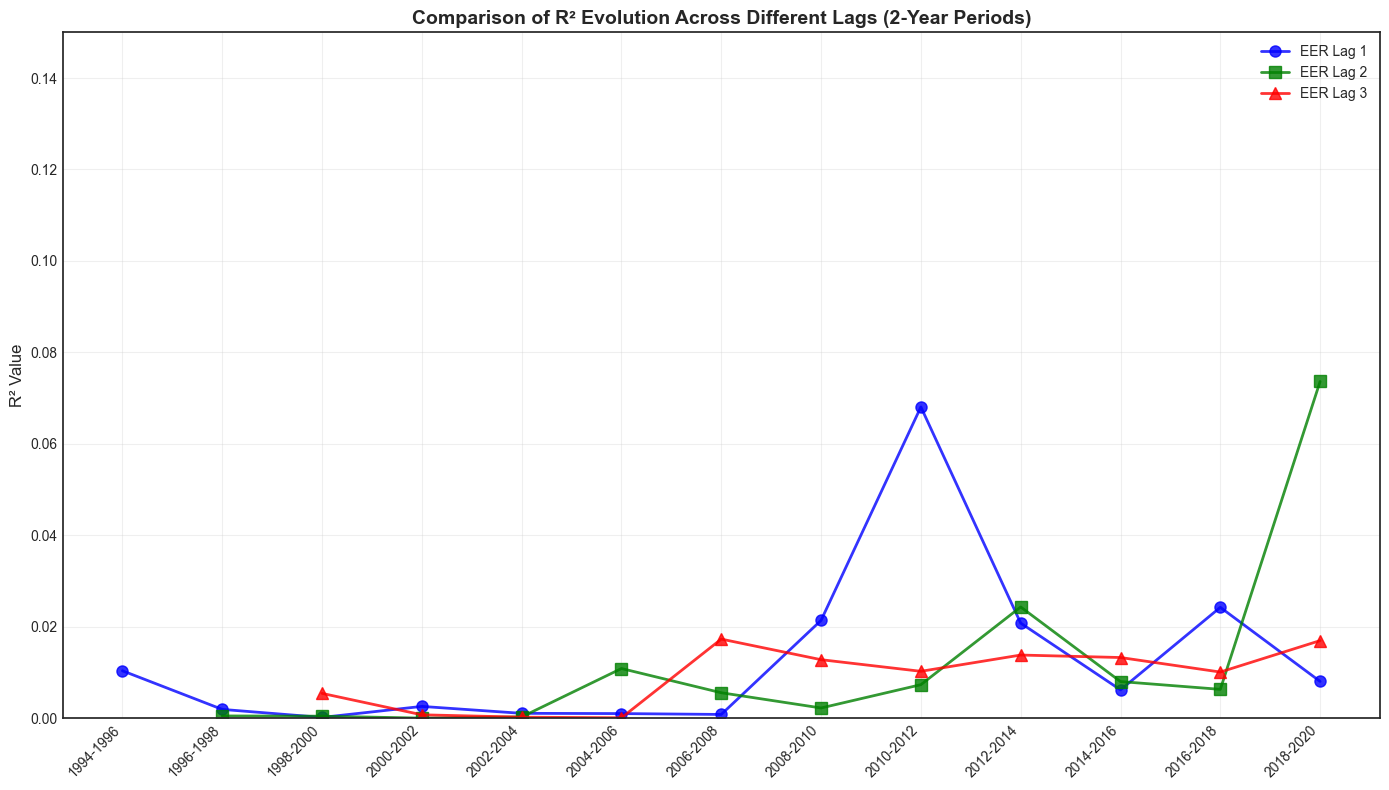


SUMMARY STATISTICS BY 2-YEAR PERIOD
Period       Lag 1 R²     Lag 1 Corr   Lag 2 R²     Lag 2 Corr   Lag 3 R²     Lag 3 Corr  
----------------------------------------------------------------------------------------------------
1994-1996    0.010        -0.102       N/A          N/A          N/A          N/A         
1996-1998    0.002        -0.044       0.000        0.022        N/A          N/A         
1998-2000    0.000        0.012        0.000        0.021        0.005        -0.074      
2000-2002    0.003        -0.051       0.000        -0.002       0.001        -0.027      
2002-2004    0.001        0.032        0.000        -0.016       0.000        0.014       
2004-2006    0.001        0.032        0.011        0.104        0.000        -0.009      
2006-2008    0.001        0.028        0.006        0.075        0.017        0.131       
2008-2010    0.021        0.146        0.002        0.047        0.013        0.113       
2010-2012    0.068        0.261        0.00

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")

# First, create lagged eer variables if they don't exist
if 'eer' in df_merged.columns:
    print("Creating lagged EER variables...")
    
    # Sort by industry and year
    df_merged_sorted = df_merged.sort_values(['naics4', 'window_end_year'])
    
    # Create lags if they don't exist
    if 'eer_lag1' not in df_merged_sorted.columns:
        df_merged_sorted['eer_lag1'] = df_merged_sorted.groupby('naics4')['eer'].shift(1)
        df_merged_sorted['eer_lag2'] = df_merged_sorted.groupby('naics4')['eer'].shift(2)
        df_merged_sorted['eer_lag3'] = df_merged_sorted.groupby('naics4')['eer'].shift(3)
    
    # Update df_merged
    df_merged = df_merged_sorted.copy()
    
    print(f"Lagged variables created/verified:")
    print(f"  eer_lag1: {df_merged['eer_lag1'].notna().sum()} non-missing values")
    print(f"  eer_lag2: {df_merged['eer_lag2'].notna().sum()} non-missing values")
    print(f"  eer_lag3: {df_merged['eer_lag3'].notna().sum()} non-missing values")
    
    # Define 2-year periods
    # Adjust based on your actual year range
    min_year = int(df_merged['window_end_year'].min())
    max_year = int(df_merged['window_end_year'].max())
    
    # Create 2-year periods
    periods_2year = []
    year = 1994  # Starting year
    while year < max_year:
        end_year = min(year + 2, max_year)
        periods_2year.append((year, end_year, f"{year}-{end_year}"))
        year += 2
    
    print(f"\nCreated {len(periods_2year)} two-year periods:")
    for p in periods_2year:
        print(f"  {p[2]}")
    
    # Calculate number of rows and columns for subplot
    n_periods = len(periods_2year)
    n_cols = 6  # Fixed number of columns
    n_rows = (n_periods + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure for each lag
    for lag_idx, (lag_var, lag_name) in enumerate([('eer_lag1', 'EER Lag 1'), 
                                                    ('eer_lag2', 'EER Lag 2'), 
                                                    ('eer_lag3', 'EER Lag 3')]):
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, n_rows * 4))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        # Store R² values
        r_squared_values = []
        period_labels = []
        
        for period_idx, (start_year, end_year, period_name) in enumerate(periods_2year):
            if period_idx < len(axes):
                ax = axes[period_idx]
                
                # Filter data for this period
                period_data = df_merged[(df_merged['window_end_year'] >= start_year) & 
                                       (df_merged['window_end_year'] <= end_year)].copy()
                
                if len(period_data) > 0 and lag_var in period_data.columns:
                    # Separate by tech status
                    hightech = period_data[period_data['hightech'] == 1]
                    nonhightech = period_data[period_data['hightech'] == 0]
                    
                    # Plot non-high-tech
                    ax.scatter(nonhightech['sd'], nonhightech[lag_var], 
                              alpha=0.6, s=30, color='blue', label='Non-High-Tech')
                    
                    # Plot high-tech
                    ax.scatter(hightech['sd'], hightech[lag_var], 
                              alpha=0.6, s=40, color='red', marker='s', label='High-Tech')
                    
                    # Add regression line
                    mask = ~(period_data['sd'].isna() | period_data[lag_var].isna())
                    if mask.sum() > 5:  # Lower threshold for 2-year periods
                        x_clean = period_data.loc[mask, 'sd']
                        y_clean = period_data.loc[mask, lag_var]
                        
                        slope, intercept, r_value, p_value, _ = stats.linregress(x_clean, y_clean)
                        r_squared_values.append(r_value**2)
                        period_labels.append(period_name)
                        
                        # Create regression line
                        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
                        y_line = slope * x_line + intercept
                        ax.plot(x_line, y_line, 'k--', linewidth=1.5, alpha=0.8)
                        
                        # Add title with statistics
                        ax.set_title(f'{period_name}\nR²={r_value**2:.3f}, N={mask.sum()}', fontsize=10)
                    else:
                        ax.set_title(f'{period_name}\nN={mask.sum()}', fontsize=10)
                    
                    # Set labels
                    ax.set_xlabel('Standard Deviation', fontsize=9)
                    ax.set_ylabel(f'{lag_name} (%)', fontsize=9)
                    
                    # Add legend only to first plot
                    if period_idx == 0:
                        ax.legend(loc='upper right', fontsize=8)
                    
                    ax.grid(True, alpha=0.3)
                    ax.tick_params(labelsize=8)
                    
                    # Set consistent axis limits
                    ax.set_xlim(0.2, 1.0)
                    ax.set_ylim(0, 20)
        
        # Hide unused subplots
        for idx in range(len(periods_2year), len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle(f'{lag_name} vs Dispersion Across 2-Year Periods', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Plot R² evolution for this lag
        if len(r_squared_values) > 0:
            fig2, ax2 = plt.subplots(figsize=(14, 6))
            
            ax2.plot(range(len(r_squared_values)), r_squared_values, 'o-', 
                    markersize=8, linewidth=2, color='darkblue')
            
            # Add value labels
            for i, r2 in enumerate(r_squared_values):
                ax2.annotate(f'{r2:.3f}', (i, r2), 
                            textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
            
            ax2.set_xticks(range(len(period_labels)))
            ax2.set_xticklabels(period_labels, rotation=45, ha='right')
            ax2.set_ylabel('R² Value', fontsize=12)
            ax2.set_title(f'Evolution of R² Over Time: {lag_name}', 
                         fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)
            ax2.set_ylim(0, max(0.1, max(r_squared_values) * 1.2))
            
            plt.tight_layout()
            plt.show()
    
    # Create summary comparison plot
    fig3, ax3 = plt.subplots(figsize=(14, 8))
    
    colors = ['blue', 'green', 'red']
    markers = ['o', 's', '^']
    all_r_squared = {lag: [] for lag in ['eer_lag1', 'eer_lag2', 'eer_lag3']}
    
    # Recalculate R² for all lags across all periods
    for lag_idx, (lag_var, lag_name) in enumerate([('eer_lag1', 'EER Lag 1'), 
                                                    ('eer_lag2', 'EER Lag 2'), 
                                                    ('eer_lag3', 'EER Lag 3')]):
        for period_idx, (start_year, end_year, period_name) in enumerate(periods_2year):
            period_data = df_merged[(df_merged['window_end_year'] >= start_year) & 
                                   (df_merged['window_end_year'] <= end_year)]
            
            mask = ~(period_data['sd'].isna() | period_data[lag_var].isna())
            if mask.sum() > 5:
                x_clean = period_data.loc[mask, 'sd']
                y_clean = period_data.loc[mask, lag_var]
                _, _, r_value, _, _ = stats.linregress(x_clean, y_clean)
                all_r_squared[lag_var].append(r_value**2)
            else:
                all_r_squared[lag_var].append(np.nan)
    
    # Plot all lags together
    for idx, (lag_var, lag_name) in enumerate([('eer_lag1', 'EER Lag 1'), 
                                                ('eer_lag2', 'EER Lag 2'), 
                                                ('eer_lag3', 'EER Lag 3')]):
        y_values = all_r_squared[lag_var]
        x_values = range(len(y_values))
        
        # Filter out NaN values for plotting
        valid_idx = [i for i, v in enumerate(y_values) if not np.isnan(v)]
        valid_y = [y_values[i] for i in valid_idx]
        valid_x = valid_idx
        
        ax3.plot(valid_x, valid_y, marker=markers[idx], markersize=8, 
                linewidth=2, color=colors[idx], label=lag_name, alpha=0.8)
    
    ax3.set_xticks(range(len(periods_2year)))
    ax3.set_xticklabels([p[2] for p in periods_2year], rotation=45, ha='right')
    ax3.set_ylabel('R² Value', fontsize=12)
    ax3.set_title('Comparison of R² Evolution Across Different Lags (2-Year Periods)', 
                 fontsize=14, fontweight='bold')
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 0.15)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    print("\nSUMMARY STATISTICS BY 2-YEAR PERIOD")
    print("=" * 100)
    print(f"{'Period':<12} {'Lag 1 R²':<12} {'Lag 1 Corr':<12} {'Lag 2 R²':<12} {'Lag 2 Corr':<12} {'Lag 3 R²':<12} {'Lag 3 Corr':<12}")
    print("-" * 100)
    
    for period_idx, (start_year, end_year, period_name) in enumerate(periods_2year):
        period_data = df_merged[(df_merged['window_end_year'] >= start_year) & 
                               (df_merged['window_end_year'] <= end_year)]
        
        row_data = [period_name]
        
        for lag_var in ['eer_lag1', 'eer_lag2', 'eer_lag3']:
            mask = ~(period_data['sd'].isna() | period_data[lag_var].isna())
            if mask.sum() > 5:
                corr = period_data.loc[mask, ['sd', lag_var]].corr().iloc[0, 1]
                _, _, r_value, _, _ = stats.linregress(
                    period_data.loc[mask, 'sd'], 
                    period_data.loc[mask, lag_var]
                )
                row_data.extend([f"{r_value**2:.3f}", f"{corr:.3f}"])
            else:
                row_data.extend(["N/A", "N/A"])
        
        print(f"{row_data[0]:<12} {row_data[1]:<12} {row_data[2]:<12} {row_data[3]:<12} {row_data[4]:<12} {row_data[5]:<12} {row_data[6]:<12}")
    
    # Overall statistics
    print("\n" + "-" * 100)
    print("OVERALL STATISTICS (All Years)")
    print("-" * 100)
    
    overall_row = ["All Years"]
    for lag_var in ['eer_lag1', 'eer_lag2', 'eer_lag3']:
        mask = ~(df_merged['sd'].isna() | df_merged[lag_var].isna())
        if mask.sum() > 0:
            corr = df_merged.loc[mask, ['sd', lag_var]].corr().iloc[0, 1]
            _, _, r_value, _, _ = stats.linregress(
                df_merged.loc[mask, 'sd'], 
                df_merged.loc[mask, lag_var]
            )
            overall_row.extend([f"{r_value**2:.3f}", f"{corr:.3f}"])
        else:
            overall_row.extend(["N/A", "N/A"])
    
    print(f"{overall_row[0]:<12} {overall_row[1]:<12} {overall_row[2]:<12} {overall_row[3]:<12} {overall_row[4]:<12} {overall_row[5]:<12} {overall_row[6]:<12}")

else:
    print("Error: 'eer' column not found in data. Cannot create lagged variables.")

In [85]:
df_merged.columns

Index(['naics4', 'window_end_year', 'window_id', 'sd', 'd7525', 'd9010',
       'd9990', 'd1001', 'sd*', 'd7525*', 'd9010*', 'd9990*', 'd1001*',
       'firms', 'estabs', 'emp', 'denom', 'estabs_entry', 'estabs_exit',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp',
       'estabs_entry_rate', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'net_job_creation', 'job_creation_rate', 'job_creation_rate_births',
       'job_destruction_rate', 'job_destruction_rate_deaths',
       'net_job_creation_rate', 'reallocation_rate', 'iqr_growth_weighted',
       'd9010_growth_weighted', 'estabs_entry_rate_lag1',
       'estabs_entry_rate_lag2', 'estabs_entry_rate_lag3', 'entry_lag1',
       'entry_lag2', 'entry_lag3', 'naics4_int', 'hightech',
       'entry_lag1_x_hightech', 'entry_lag2_x_hightech',
       'entry_lag3_x_hightech', 'pct_high_growth_emp'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# ============================================
# CONFIGURATION: Choose your dependent variable
# ============================================
# Uncomment the variable you want to use:
DEPENDENT_VAR = 'd9990*'  # Employment Entry Rate
# DEPENDENT_VAR = 'exit_rate'  # Exit Rate
# DEPENDENT_VAR = 'growth_rate'  # Growth Rate
# DEPENDENT_VAR = 'productivity'  # Productivity
# DEPENDENT_VAR = 'avg_wage'  # Average Wage

# Variable display names for labels
VAR_DISPLAY_NAMES = {
    'eer': 'Employment Entry Rate (%)',
    'exit_rate': 'Exit Rate (%)',
    'growth_rate': 'Growth Rate (%)',
    'productivity': 'Productivity',
    'avg_wage': 'Average Wage'
}

# Get display name for the chosen variable
DEPENDENT_VAR_DISPLAY = VAR_DISPLAY_NAMES.get(DEPENDENT_VAR, DEPENDENT_VAR.replace('_', ' ').title())

# ============================================
# MAIN ANALYSIS CODE
# ============================================

# Set style
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")

# Check if dependent variable exists
if DEPENDENT_VAR not in df_merged.columns:
    print(f"Warning: '{DEPENDENT_VAR}' column not found in data")
    print("Available columns:", df_merged.columns.tolist())
    print(f"Please ensure {DEPENDENT_VAR_DISPLAY} is calculated")
else:
    # Create 6 time periods (same as the image shown)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Define the same time periods as in your image
    periods = [
        (1994, 1998, "1994-1998"),
        (1998, 2002, "1998-2002"), 
        (2002, 2006, "2002-2006"),
        (2006, 2012, "2006-2012"),
        (2012, 2016, "2012-2016"),
        (2016, 2020, "2016-2020")
    ]
    
    # Store R² values for trend analysis
    r_squared_values = []
    period_names = []
    
    for idx, (start_year, end_year, period_name) in enumerate(periods):
        ax = axes[idx]
        
        # Filter data for this period
        period_data = df_merged[(df_merged['window_end_year'] >= start_year) & 
                               (df_merged['window_end_year'] <= end_year)].copy()
        
        if len(period_data) > 0:
            # Separate by tech status
            hightech = period_data[period_data['hightech'] == 1]
            nonhightech = period_data[period_data['hightech'] == 0]
            
            # Plot non-high-tech
            ax.scatter(nonhightech['sd'], nonhightech[DEPENDENT_VAR], 
                      alpha=0.6, s=40, color='blue', label='Non-High-Tech')
            
            # Plot high-tech
            ax.scatter(hightech['sd'], hightech[DEPENDENT_VAR], 
                      alpha=0.6, s=60, color='red', marker='s', label='High-Tech')
            
            # Add regression line for all data in period
            if len(period_data) > 10:
                # Remove NaN values
                mask = ~(period_data['sd'].isna() | period_data[DEPENDENT_VAR].isna())
                x_clean = period_data.loc[mask, 'sd']
                y_clean = period_data.loc[mask, DEPENDENT_VAR]
                
                if len(x_clean) > 2:
                    slope, intercept, r_value, p_value, _ = stats.linregress(x_clean, y_clean)
                    
                    # Store R² for trend analysis
                    r_squared_values.append(r_value**2)
                    period_names.append(period_name)
                    
                    # Create regression line
                    x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
                    y_line = slope * x_line + intercept
                    ax.plot(x_line, y_line, 'k--', linewidth=2, alpha=0.8)
                    
                    # Add title with R² and N
                    ax.set_title(f'{period_name} (R² = {r_value**2:.3f}, N = {len(x_clean)})', 
                                fontsize=12, fontweight='bold')
                else:
                    ax.set_title(f'{period_name} (N = {len(period_data)})', 
                                fontsize=12, fontweight='bold')
            
            # Set labels
            ax.set_xlabel('Standard Deviation', fontsize=11)
            ax.set_ylabel(DEPENDENT_VAR_DISPLAY, fontsize=11)
            ax.grid(True, alpha=0.3)
            
            # Add legend only to first plot
            if idx == 0:
                ax.legend(loc='upper right', fontsize=9)
            
            # Set consistent axis limits (adjust based on your data)
            ax.set_xlim(0.2, max(1.0, period_data['sd'].max() + 0.1))
            
            # Dynamic y-axis limits based on the dependent variable
            y_max = period_data[DEPENDENT_VAR].max()
            if DEPENDENT_VAR in ['eer', 'exit_rate']:
                ax.set_ylim(0, max(20, y_max + 2))
            else:
                ax.set_ylim(period_data[DEPENDENT_VAR].min() * 0.9, y_max * 1.1)
    
    plt.suptitle(f'Evolution of {DEPENDENT_VAR_DISPLAY} vs Dispersion Relationship Over Time', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Create a summary plot showing R² evolution
    if len(r_squared_values) > 0:
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        
        ax2.plot(range(len(r_squared_values)), r_squared_values, 'o-', 
                markersize=10, linewidth=2, color='darkblue')
        
        # Add value labels
        for i, (period, r2) in enumerate(zip(period_names, r_squared_values)):
            ax2.annotate(f'{r2:.3f}', (i, r2), 
                        textcoords="offset points", xytext=(0,10), ha='center')
        
        ax2.set_xticks(range(len(period_names)))
        ax2.set_xticklabels(period_names, rotation=45, ha='right')
        ax2.set_ylabel('R² Value', fontsize=12)
        ax2.set_title(f'Evolution of R² Over Time: {DEPENDENT_VAR_DISPLAY} vs Dispersion', 
                     fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, max(0.1, max(r_squared_values) * 1.2))
        
        # Add horizontal line at R²=0
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
    
    # Summary statistics by period
    print(f"\nSUMMARY STATISTICS BY PERIOD - Dependent Variable: {DEPENDENT_VAR_DISPLAY}")
    print("=" * 80)
    print(f"{'Period':<15} {'Avg SD':<10} {f'Avg {DEPENDENT_VAR}':<15} {'Correlation':<12} {'N Obs':<10}")
    print("-" * 80)
    
    for start_year, end_year, period_name in periods:
        period_data = df_merged[(df_merged['window_end_year'] >= start_year) & 
                               (df_merged['window_end_year'] <= end_year)]
        
        if len(period_data) > 0 and DEPENDENT_VAR in period_data.columns:
            avg_sd = period_data['sd'].mean()
            avg_dep = period_data[DEPENDENT_VAR].mean()
            
            # Calculate correlation
            mask = ~(period_data['sd'].isna() | period_data[DEPENDENT_VAR].isna())
            if mask.sum() > 2:
                corr = period_data.loc[mask, ['sd', DEPENDENT_VAR]].corr().iloc[0, 1]
            else:
                corr = np.nan
                
            n_obs = len(period_data)
            
            print(f"{period_name:<15} {avg_sd:<10.3f} {avg_dep:<15.3f} {corr:<12.3f} {n_obs:<10}")
    
    # Overall trend analysis
    print("\n" + "=" * 80)
    print(f"TREND ANALYSIS - {DEPENDENT_VAR_DISPLAY} vs Dispersion")
    print("=" * 80)
    
    # Calculate correlation for first half vs second half
    median_year = df_merged['window_end_year'].median()
    first_half = df_merged[df_merged['window_end_year'] <= median_year]
    second_half = df_merged[df_merged['window_end_year'] > median_year]
    
    if DEPENDENT_VAR in first_half.columns:
        mask1 = ~(first_half['sd'].isna() | first_half[DEPENDENT_VAR].isna())
        mask2 = ~(second_half['sd'].isna() | second_half[DEPENDENT_VAR].isna())
        
        if mask1.sum() > 2 and mask2.sum() > 2:
            corr1 = first_half.loc[mask1, ['sd', DEPENDENT_VAR]].corr().iloc[0, 1]
            corr2 = second_half.loc[mask2, ['sd', DEPENDENT_VAR]].corr().iloc[0, 1]
            
            print(f"First half correlation (before {median_year:.0f}): {corr1:.3f}")
            print(f"Second half correlation (after {median_year:.0f}): {corr2:.3f}")
            print(f"Change in correlation: {corr2 - corr1:.3f}")
            
            if corr2 - corr1 > 0:
                print("The relationship has STRENGTHENED over time")
            else:
                print("The relationship has WEAKENED over time")
    
    # Print summary of what was analyzed
    print("\n" + "=" * 80)
    print(f"Analysis completed for: {DEPENDENT_VAR} ({DEPENDENT_VAR_DISPLAY})")
    print("To analyze a different variable, change DEPENDENT_VAR at the top of the script")
    print("=" * 80)

In [ ]:
'd9990', 'd1001', 'sd*', 'd7525*', 'd9010*', 'd9990*', 'd1001*',

LAGGED PANEL REGRESSION: d1001* ~ eer (with lags)
Created log_emp from emp
Created log_firms from firms
Created eer_lag1_x_hightech
Created eer_lag2_x_hightech
Created eer_lag3_x_hightech

Independent variables in model: ['eer', 'eer_lag1', 'eer_lag2', 'eer_lag3', 'log_emp', 'log_firms', 'eer_x_hightech', 'eer_lag1_x_hightech', 'eer_lag2_x_hightech', 'eer_lag3_x_hightech']

Observations before dropping NAs: 1204
Observations after dropping NAs: 946

MODEL 1: BASIC LAGGED MODEL WITH TWO-WAY FIXED EFFECTS
                          PanelOLS Estimation Summary                           
Dep. Variable:                 d1001*   R-squared:                        0.0223
Estimator:                   PanelOLS   R-squared (Between):             -4.1278
No. Observations:                 946   R-squared (Within):               0.0210
Date:                Mon, May 26 2025   R-squared (Overall):             -3.7391
Time:                        20:05:02   Log-likelihood                    999.98
Cov. 

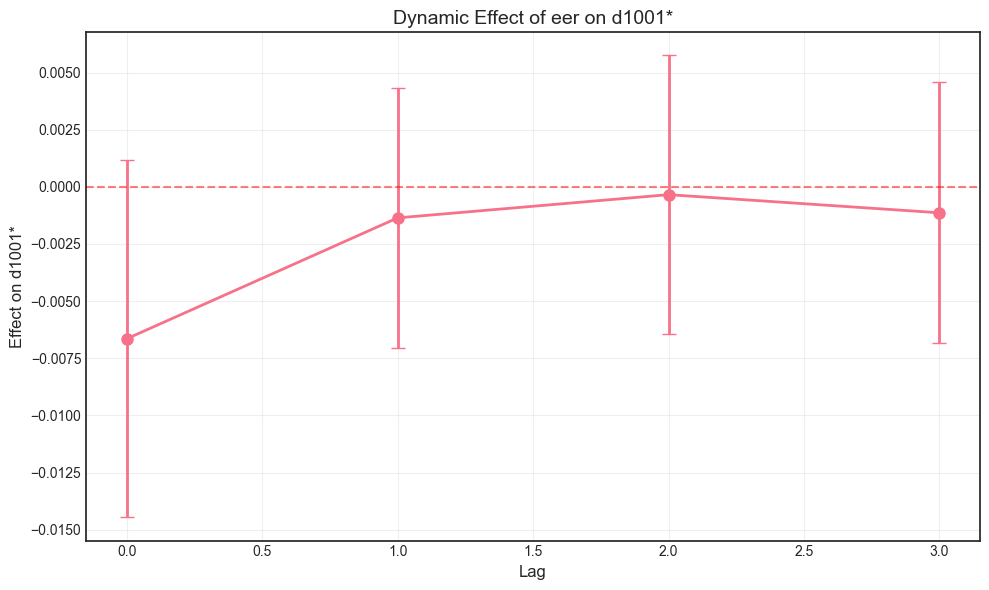


REGRESSION COMPLETE


In [91]:
import pandas as pd
import numpy as np
import linearmodels as lm
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# ==============================================================================
# CONFIGURATION SECTION - EASILY CHANGE VARIABLES HERE
# ==============================================================================

# DEPENDENT VARIABLE OPTIONS (uncomment the one you want):
DEPENDENT_VAR = 'd1001*'                    # Standard deviation of productivity
# DEPENDENT_VAR = 'd9010'               # 90-10 percentile spread
# DEPENDENT_VAR = 'd7525'               # 75-25 percentile spread
# DEPENDENT_VAR = 'iqr_growth_weighted' # IQR growth weighted
# DEPENDENT_VAR = 'reallocation_rate'   # Labor reallocation rate

# INDEPENDENT VARIABLE (regressor):
INDEPENDENT_VAR = 'eer'                 # Employment entry rate
# INDEPENDENT_VAR = 'estabs_entry_rate' # Establishment entry rate
# INDEPENDENT_VAR = 'hgf_lag1'          # High-growth firms (if you have this)

# LAG STRUCTURE:
MAX_LAGS = 3                            # Number of lags to include (1, 2, or 3)
INCLUDE_CONTEMPORANEOUS = True          # Include current period (lag 0)?

# CONTROL VARIABLES (add any controls you want):
CONTROL_VARS = ['log_emp', 'log_firms'] # Will create these if they don't exist
# CONTROL_VARS = []                     # No controls

# INTERACTION WITH HIGH-TECH:
INCLUDE_HIGHTECH_INTERACTION = True     # Include interactions with high-tech dummy?

# OUTPUT OPTIONS:
SHOW_FIRST_STAGE = True                 # Show data preparation details?
EXPORT_TO_LATEX = False                 # Export results to LaTeX?

# ==============================================================================
# DATA PREPARATION
# ==============================================================================

print("=" * 80)
print(f"LAGGED PANEL REGRESSION: {DEPENDENT_VAR} ~ {INDEPENDENT_VAR} (with lags)")
print("=" * 80)

# Create a working copy
df_work = df_merged.copy()

# Sort by industry and time
df_work = df_work.sort_values(['naics4', 'window_end_year'])

# Create log variables if needed and they don't exist
for var in CONTROL_VARS:
    if 'log_' in var and var not in df_work.columns:
        base_var = var.replace('log_', '')
        if base_var in df_work.columns:
            df_work[var] = np.log(df_work[base_var] + 1)
            print(f"Created {var} from {base_var}")

# Create lagged variables
lag_vars = []
for lag in range(1, MAX_LAGS + 1):
    lag_var = f"{INDEPENDENT_VAR}_lag{lag}"
    if lag_var not in df_work.columns:
        df_work[lag_var] = df_work.groupby('naics4')[INDEPENDENT_VAR].shift(lag)
        print(f"Created {lag_var}")
    lag_vars.append(lag_var)

# Create high-tech interaction terms if requested
interaction_vars = []
if INCLUDE_HIGHTECH_INTERACTION:
    # Current period interaction
    if INCLUDE_CONTEMPORANEOUS:
        int_var = f"{INDEPENDENT_VAR}_x_hightech"
        if int_var not in df_work.columns:
            df_work[int_var] = df_work[INDEPENDENT_VAR] * df_work['hightech']
        interaction_vars.append(int_var)
    
    # Lagged interactions
    for lag in range(1, MAX_LAGS + 1):
        lag_var = f"{INDEPENDENT_VAR}_lag{lag}"
        int_var = f"{lag_var}_x_hightech"
        if int_var not in df_work.columns:
            df_work[int_var] = df_work[lag_var] * df_work['hightech']
        interaction_vars.append(int_var)
        print(f"Created {int_var}")

# Build list of all independent variables
all_indep_vars = []
if INCLUDE_CONTEMPORANEOUS:
    all_indep_vars.append(INDEPENDENT_VAR)
all_indep_vars.extend(lag_vars)
all_indep_vars.extend(CONTROL_VARS)
if INCLUDE_HIGHTECH_INTERACTION:
    all_indep_vars.extend(interaction_vars)

print(f"\nIndependent variables in model: {all_indep_vars}")

# Select relevant columns and drop missing
model_vars = [DEPENDENT_VAR] + all_indep_vars + ['naics4', 'window_end_year']
df_model = df_work[model_vars].dropna()

print(f"\nObservations before dropping NAs: {len(df_work)}")
print(f"Observations after dropping NAs: {len(df_model)}")

# Set index for panel regression
df_panel = df_model.set_index(['naics4', 'window_end_year'])

# ==============================================================================
# REGRESSION ANALYSIS
# ==============================================================================

# Model 1: Basic lagged model with fixed effects
print("\n" + "=" * 80)
print("MODEL 1: BASIC LAGGED MODEL WITH TWO-WAY FIXED EFFECTS")
print("=" * 80)

model1 = PanelOLS(
    dependent=df_panel[DEPENDENT_VAR],
    exog=df_panel[all_indep_vars],
    entity_effects=True,
    time_effects=True,
    drop_absorbed=True
)

results1 = model1.fit(cov_type='clustered', cluster_entity=True)
print(results1)

# Calculate total effects for high-tech if interactions included
if INCLUDE_HIGHTECH_INTERACTION:
    print("\n" + "=" * 80)
    print("HIGH-TECH TOTAL EFFECTS (Main + Interaction)")
    print("=" * 80)
    
    # Helper function for linear combinations
    def calculate_total_effect(results, main_var, interaction_var):
        """Calculate total effect and standard error for high-tech industries"""
        beta_main = results.params.get(main_var, 0)
        beta_int = results.params.get(interaction_var, 0)
        total = beta_main + beta_int
        
        # Get variance-covariance matrix
        var_main = results.cov.loc[main_var, main_var] if main_var in results.params else 0
        var_int = results.cov.loc[interaction_var, interaction_var] if interaction_var in results.params else 0
        cov_main_int = results.cov.loc[main_var, interaction_var] if (main_var in results.params and interaction_var in results.params) else 0
        
        # Calculate standard error of sum
        se_total = np.sqrt(var_main + var_int + 2 * cov_main_int)
        t_stat = total / se_total if se_total > 0 else 0
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), results.df_resid))
        
        return total, se_total, t_stat, p_value
    
    # Calculate for contemporaneous effect
    if INCLUDE_CONTEMPORANEOUS:
        total, se, t, p = calculate_total_effect(
            results1, 
            INDEPENDENT_VAR, 
            f"{INDEPENDENT_VAR}_x_hightech"
        )
        print(f"Contemporaneous effect: {total:.4f} (SE: {se:.4f}, t: {t:.2f}, p: {p:.3f})")
    
    # Calculate for each lag
    for lag in range(1, MAX_LAGS + 1):
        total, se, t, p = calculate_total_effect(
            results1, 
            f"{INDEPENDENT_VAR}_lag{lag}", 
            f"{INDEPENDENT_VAR}_lag{lag}_x_hightech"
        )
        print(f"Lag {lag} effect: {total:.4f} (SE: {se:.4f}, t: {t:.2f}, p: {p:.3f})")

# Model 2: Without time effects (for comparison)
print("\n" + "=" * 80)
print("MODEL 2: INDUSTRY FIXED EFFECTS ONLY")
print("=" * 80)

model2 = PanelOLS(
    dependent=df_panel[DEPENDENT_VAR],
    exog=df_panel[all_indep_vars],
    entity_effects=True,
    time_effects=False,
    drop_absorbed=True
)

results2 = model2.fit(cov_type='clustered', cluster_entity=True)
print(results2.summary.tables[1])  # Just show coefficient table

# ==============================================================================
# SUMMARY AND DIAGNOSTICS
# ==============================================================================

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

print(f"{'Metric':<25} {'Model 1 (Two-way FE)':<25} {'Model 2 (Industry FE)':<25}")
print("-" * 75)
print(f"{'R-squared':<25} {results1.rsquared:<25.4f} {results2.rsquared:<25.4f}")
print(f"{'R-squared (within)':<25} {results1.rsquared_within:<25.4f} {results2.rsquared_within:<25.4f}")
print(f"{'Observations':<25} {results1.nobs:<25.0f} {results2.nobs:<25.0f}")
print(f"{'Industries':<25} {results1.entity_info['total']:<25.0f} {results2.entity_info['total']:<25.0f}")

# Test for joint significance of lags
print("\n" + "=" * 80)
print("JOINT SIGNIFICANCE TESTS")
print("=" * 80)

# Test all lags jointly
from scipy import stats
lag_vars_in_model = [var for var in lag_vars if var in results1.params.index]
if len(lag_vars_in_model) > 0:
    R = np.zeros((len(lag_vars_in_model), len(results1.params)))
    for i, var in enumerate(lag_vars_in_model):
        R[i, results1.params.index.get_loc(var)] = 1
    
    # Wald test
    wald_stat = results1.wald_test(R)
    print(f"Joint test of all lags: F({len(lag_vars_in_model)}, {results1.df_resid}) = {wald_stat.stat:.3f}, p-value = {wald_stat.pval:.4f}")

# Create formatted output table
print("\n" + "=" * 80)
print("FORMATTED RESULTS TABLE")
print("=" * 80)

def format_results_table(results, var_names):
    """Create a formatted table of results"""
    print(f"{'Variable':<35} {'Coefficient':<12} {'Std. Error':<12} {'t-stat':<10} {'p-value':<10}")
    print("-" * 80)
    
    for var in var_names:
        if var in results.params.index:
            coef = results.params[var]
            se = results.std_errors[var]
            t = results.tstats[var]
            p = results.pvalues[var]
            
            # Add significance stars
            if p < 0.01:
                sig = "***"
            elif p < 0.05:
                sig = "**"
            elif p < 0.1:
                sig = "*"
            else:
                sig = ""
            
            print(f"{var:<35} {coef:>11.4f}{sig:<1} {se:>11.4f} {t:>9.2f} {p:>9.3f}")

# Show main results
main_vars = []
if INCLUDE_CONTEMPORANEOUS:
    main_vars.append(INDEPENDENT_VAR)
main_vars.extend(lag_vars)

print("\nMain Effects:")
format_results_table(results1, main_vars)

if INCLUDE_HIGHTECH_INTERACTION:
    print("\nInteraction Effects:")
    format_results_table(results1, interaction_vars)

if CONTROL_VARS:
    print("\nControl Variables:")
    format_results_table(results1, CONTROL_VARS)

# Export to LaTeX if requested
if EXPORT_TO_LATEX:
    latex_table = results1.summary.as_latex()
    with open(f'{DEPENDENT_VAR}_regression_results.tex', 'w') as f:
        f.write(latex_table)
    print(f"\nResults exported to {DEPENDENT_VAR}_regression_results.tex")

# Plot impulse response (cumulative effect over lags)
if SHOW_FIRST_STAGE:
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get coefficients for main effects
    lags = []
    coefs = []
    ses = []
    
    if INCLUDE_CONTEMPORANEOUS and INDEPENDENT_VAR in results1.params:
        lags.append(0)
        coefs.append(results1.params[INDEPENDENT_VAR])
        ses.append(results1.std_errors[INDEPENDENT_VAR])
    
    for lag in range(1, MAX_LAGS + 1):
        var = f"{INDEPENDENT_VAR}_lag{lag}"
        if var in results1.params:
            lags.append(lag)
            coefs.append(results1.params[var])
            ses.append(results1.std_errors[var])
    
    # Plot coefficients with confidence intervals
    ax.errorbar(lags, coefs, yerr=[1.96 * se for se in ses], 
                marker='o', markersize=8, capsize=5, linewidth=2)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Lag', fontsize=12)
    ax.set_ylabel(f'Effect on {DEPENDENT_VAR}', fontsize=12)
    ax.set_title(f'Dynamic Effect of {INDEPENDENT_VAR} on {DEPENDENT_VAR}', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)
print("REGRESSION COMPLETE")
print("=" * 80)